# Load libraries

In [1]:
!pip install numdifftools

In [1]:
from __future__ import print_function, division

import itertools
import time

import torch as th
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from sklearn.preprocessing import StandardScaler
from sympy import *
import pathlib
import pdb
import matplotlib.pyplot as plt
import sys

In [2]:
sys.path.append('..')
from third_party.classification import *
from ConformalizedES.method import CES_regression
from ConformalizedES.networks import mse_model, MSE_loss
from ConformalizedES.inference import Conformal_PI
from third_party.coverage import *

2023-01-16 11:59:52.918511: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Define useful functions

In [3]:
# Colors from Colorbrewer Paired_12
colors = [[31, 120, 180], [51, 160, 44], [250,159,181]]
colors = [(r / 255, g / 255, b / 255) for (r, g, b) in colors]

def plot_loss(train_loss, val_loss):
    x = np.arange(1, len(train_loss) + 1)

    plt.figure()
    plt.plot(x, train_loss, color=colors[0], label="Training loss", linewidth=2)
    plt.plot(x, val_loss, color=colors[1], label="Validation loss", linewidth=2)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.title("Evolution of the training, validation and test loss")
    
    plt.show()

In [4]:
class PrepareData(Dataset):

    def __init__(self, X, y, scale_X=False):
        if not torch.is_tensor(X):
            if scale_X:
                X = StandardScaler().fit_transform(X)
                self.X = torch.from_numpy(X)
            self.X = torch.from_numpy(X)
        if not torch.is_tensor(y):
            self.y = torch.from_numpy(y)
        
    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx].float(), self.y[idx].float()


# Generate the data

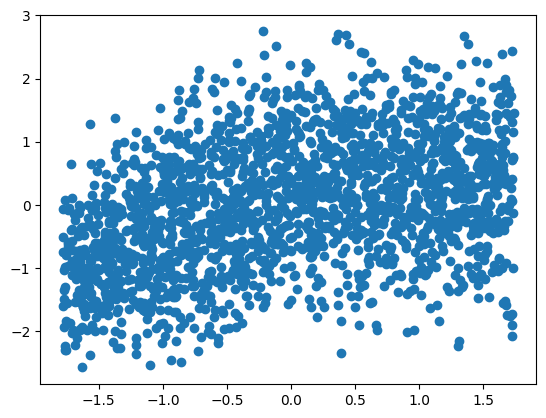

In [97]:
from sklearn.datasets import make_friedman1

n_samples = 2000
n_features = 100

X, Y = make_friedman1(n_samples=n_samples, n_features=n_features, noise=1/100, random_state=None)

# Scale the data
X = StandardScaler().fit_transform(X)
Y = StandardScaler().fit_transform(Y.reshape((len(Y),1))).flatten()

# Find approximate marginal quantiles of Y
y_hat_min, y_hat_max = mquantiles(Y, [0.05,0.95])

plt.scatter(X[:,0], Y)
plt.show()

# Benchmark method

In [98]:
# specify the number of samples in training, validation, calibration and test datasets
n_train = 1000
n_val = 100
n_cal = 100
n_test = 100 
method_ = 'Benchmark'

seed = 1
np.random.seed(seed)
th.manual_seed(seed)

# split the data into proper training, validation, and calibration set, set test data aside 
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=123)
idx_test = np.random.permutation(n_test)
X_test = X_test[idx_test]
y_test = y_test[idx_test]

idx = np.random.permutation(n_train+n_val+n_cal)
idx_train_BM, idx_val_BM, idx_cal_BM = idx[:n_train], idx[n_train:n_val+n_train], idx[n_val+n_train: n_val+n_train + n_cal]
X_train_BM, y_train_BM = X_train[idx_train_BM], y_train[idx_train_BM]
X_val_BM, y_val_BM = X_train[idx_val_BM], y_train[idx_val_BM]
X_cal_BM, y_cal_BM = X_train[idx_cal_BM], y_train[idx_cal_BM]

print("Size (BM): train (%d, %d), validation (%d, %d), calibration (%d, %d), test (%d, %d)" % \
      (X_train_BM.shape[0], X_train_BM.shape[1], 
       X_val_BM.shape[0], X_val_BM.shape[1], 
       X_cal_BM.shape[0], X_cal_BM.shape[1], 
       X_test.shape[0], X_test.shape[1]))

Size (BM): train (1000, 100), validation (100, 100), calibration (100, 100), test (100, 100)


In [108]:
# set the hyperparameters
batch_size = 50
dropout = 0
num_epochs = 1000
lr = 0.001
wd = 0

In [109]:
train_loader = DataLoader(PrepareData(X_train_BM, y_train_BM, scale_X=False), batch_size=batch_size)
val_loader = DataLoader(PrepareData(X_val_BM, y_val_BM, scale_X=False), batch_size=batch_size, drop_last = True) 
calib_loader = DataLoader(PrepareData(X_cal_BM, y_cal_BM, scale_X=False), batch_size=1, shuffle = False, drop_last=True)
test_loader = DataLoader(PrepareData(X_test, y_test, scale_X=False), batch_size= 1, shuffle = False)


# intialize the model
in_shape = X_train_BM.shape[1]
hidden_layer_size = 100

# intialize the model
mod = mse_model(in_shape = in_shape, hidden_size = hidden_layer_size)
optimizer = torch.optim.Adam(mod.parameters(), lr=lr, weight_decay = wd)

if th.cuda.is_available():
    # Make CuDNN Determinist
    th.backends.cudnn.deterministic = True
    th.cuda.manual_seed(seed)

# Define default device, we should use the GPU (cuda) if available
device = th.device("cuda" if th.cuda.is_available() else "cpu")

In [110]:
# initialization
BM_reg = CES_regression(mod, device, train_loader, batch_size=batch_size, max_epoch = num_epochs, 
                        learning_rate=lr, val_loader=val_loader, criterion= MSE_loss,
                        optimizer=optimizer, verbose = True)

===== HYPERPARAMETERS =====
batch_size= 50
n_epochs= 1000
learning_rate= 0.001


In [111]:
# Train the model and save snapshots 
save_every = 1    # Save model after every few epoches
BM_reg.full_train(save_dir = './content', save_every = save_every)

Epoch 1 of 1000, 10% 	 train_loss: 1.37  took: 0.01s
Epoch 1 of 1000, 20% 	 train_loss: 1.35  took: 0.00s
Epoch 1 of 1000, 30% 	 train_loss: 1.25  took: 0.00s
Epoch 1 of 1000, 40% 	 train_loss: 1.31  took: 0.00s
Epoch 1 of 1000, 50% 	 train_loss: 0.86  took: 0.00s
Epoch 1 of 1000, 60% 	 train_loss: 1.01  took: 0.00s
Epoch 1 of 1000, 70% 	 train_loss: 0.95  took: 0.00s
Epoch 1 of 1000, 80% 	 train_loss: 0.95  took: 0.00s
Epoch 1 of 1000, 90% 	 train_loss: 1.17  took: 0.00s
Epoch 1 of 1000, 100% 	 train_loss: 0.97  took: 0.00s
val_loss = 0.85
Snapshot saved at epoch 1.
Epoch 2 of 1000, 10% 	 train_loss: 0.74  took: 0.00s
Epoch 2 of 1000, 20% 	 train_loss: 0.79  took: 0.00s
Epoch 2 of 1000, 30% 	 train_loss: 0.87  took: 0.00s
Epoch 2 of 1000, 40% 	 train_loss: 0.95  took: 0.00s
Epoch 2 of 1000, 50% 	 train_loss: 0.65  took: 0.00s
Epoch 2 of 1000, 60% 	 train_loss: 0.56  took: 0.00s
Epoch 2 of 1000, 70% 	 train_loss: 0.58  took: 0.00s
Epoch 2 of 1000, 80% 	 train_loss: 0.58  took: 0.00s
Ep

Epoch 17 of 1000, 60% 	 train_loss: 0.17  took: 0.01s
Epoch 17 of 1000, 70% 	 train_loss: 0.10  took: 0.00s
Epoch 17 of 1000, 80% 	 train_loss: 0.03  took: 0.00s
Epoch 17 of 1000, 90% 	 train_loss: 0.06  took: 0.00s
Epoch 17 of 1000, 100% 	 train_loss: 0.17  took: 0.00s
val_loss = 0.76
Snapshot saved at epoch 17.
Epoch 18 of 1000, 10% 	 train_loss: 0.26  took: 0.00s
Epoch 18 of 1000, 20% 	 train_loss: 0.21  took: 0.00s
Epoch 18 of 1000, 30% 	 train_loss: 0.09  took: 0.00s
Epoch 18 of 1000, 40% 	 train_loss: 0.03  took: 0.00s
Epoch 18 of 1000, 50% 	 train_loss: 0.11  took: 0.00s
Epoch 18 of 1000, 60% 	 train_loss: 0.26  took: 0.00s
Epoch 18 of 1000, 70% 	 train_loss: 0.34  took: 0.00s
Epoch 18 of 1000, 80% 	 train_loss: 0.23  took: 0.00s
Epoch 18 of 1000, 90% 	 train_loss: 0.09  took: 0.00s
Epoch 18 of 1000, 100% 	 train_loss: 0.05  took: 0.00s
val_loss = 0.68
Snapshot saved at epoch 18.
Epoch 19 of 1000, 10% 	 train_loss: 0.16  took: 0.00s
Epoch 19 of 1000, 20% 	 train_loss: 0.33  took

Epoch 35 of 1000, 10% 	 train_loss: 0.00  took: 0.00s
Epoch 35 of 1000, 20% 	 train_loss: 0.00  took: 0.00s
Epoch 35 of 1000, 30% 	 train_loss: 0.00  took: 0.00s
Epoch 35 of 1000, 40% 	 train_loss: 0.00  took: 0.00s
Epoch 35 of 1000, 50% 	 train_loss: 0.00  took: 0.00s
Epoch 35 of 1000, 60% 	 train_loss: 0.00  took: 0.00s
Epoch 35 of 1000, 70% 	 train_loss: 0.00  took: 0.00s
Epoch 35 of 1000, 80% 	 train_loss: 0.00  took: 0.00s
Epoch 35 of 1000, 90% 	 train_loss: 0.00  took: 0.00s
Epoch 35 of 1000, 100% 	 train_loss: 0.00  took: 0.00s
val_loss = 0.37
Snapshot saved at epoch 35.
Epoch 36 of 1000, 10% 	 train_loss: 0.00  took: 0.00s
Epoch 36 of 1000, 20% 	 train_loss: 0.00  took: 0.00s
Epoch 36 of 1000, 30% 	 train_loss: 0.00  took: 0.00s
Epoch 36 of 1000, 40% 	 train_loss: 0.00  took: 0.00s
Epoch 36 of 1000, 50% 	 train_loss: 0.00  took: 0.00s
Epoch 36 of 1000, 60% 	 train_loss: 0.00  took: 0.00s
Epoch 36 of 1000, 70% 	 train_loss: 0.00  took: 0.00s
Epoch 36 of 1000, 80% 	 train_loss: 0

Epoch 53 of 1000, 10% 	 train_loss: 0.04  took: 0.00s
Epoch 53 of 1000, 20% 	 train_loss: 0.03  took: 0.00s
Epoch 53 of 1000, 30% 	 train_loss: 0.01  took: 0.00s
Epoch 53 of 1000, 40% 	 train_loss: 0.00  took: 0.00s
Epoch 53 of 1000, 50% 	 train_loss: 0.01  took: 0.00s
Epoch 53 of 1000, 60% 	 train_loss: 0.04  took: 0.00s
Epoch 53 of 1000, 70% 	 train_loss: 0.05  took: 0.00s
Epoch 53 of 1000, 80% 	 train_loss: 0.03  took: 0.00s
Epoch 53 of 1000, 90% 	 train_loss: 0.01  took: 0.00s
Epoch 53 of 1000, 100% 	 train_loss: 0.01  took: 0.00s
val_loss = 0.46
Snapshot saved at epoch 53.
Epoch 54 of 1000, 10% 	 train_loss: 0.03  took: 0.00s
Epoch 54 of 1000, 20% 	 train_loss: 0.06  took: 0.00s
Epoch 54 of 1000, 30% 	 train_loss: 0.06  took: 0.00s
Epoch 54 of 1000, 40% 	 train_loss: 0.03  took: 0.00s
Epoch 54 of 1000, 50% 	 train_loss: 0.01  took: 0.00s
Epoch 54 of 1000, 60% 	 train_loss: 0.01  took: 0.00s
Epoch 54 of 1000, 70% 	 train_loss: 0.05  took: 0.00s
Epoch 54 of 1000, 80% 	 train_loss: 0

val_loss = 0.35
Snapshot saved at epoch 70.
Epoch 71 of 1000, 10% 	 train_loss: 0.00  took: 0.00s
Epoch 71 of 1000, 20% 	 train_loss: 0.00  took: 0.00s
Epoch 71 of 1000, 30% 	 train_loss: 0.00  took: 0.00s
Epoch 71 of 1000, 40% 	 train_loss: 0.00  took: 0.00s
Epoch 71 of 1000, 50% 	 train_loss: 0.00  took: 0.00s
Epoch 71 of 1000, 60% 	 train_loss: 0.00  took: 0.00s
Epoch 71 of 1000, 70% 	 train_loss: 0.00  took: 0.00s
Epoch 71 of 1000, 80% 	 train_loss: 0.00  took: 0.00s
Epoch 71 of 1000, 90% 	 train_loss: 0.00  took: 0.00s
Epoch 71 of 1000, 100% 	 train_loss: 0.00  took: 0.00s
val_loss = 0.35
Snapshot saved at epoch 71.
Epoch 72 of 1000, 10% 	 train_loss: 0.00  took: 0.00s
Epoch 72 of 1000, 20% 	 train_loss: 0.00  took: 0.00s
Epoch 72 of 1000, 30% 	 train_loss: 0.00  took: 0.00s
Epoch 72 of 1000, 40% 	 train_loss: 0.00  took: 0.00s
Epoch 72 of 1000, 50% 	 train_loss: 0.00  took: 0.00s
Epoch 72 of 1000, 60% 	 train_loss: 0.00  took: 0.00s
Epoch 72 of 1000, 70% 	 train_loss: 0.00  took:

Epoch 89 of 1000, 40% 	 train_loss: 0.00  took: 0.00s
Epoch 89 of 1000, 50% 	 train_loss: 0.00  took: 0.00s
Epoch 89 of 1000, 60% 	 train_loss: 0.00  took: 0.00s
Epoch 89 of 1000, 70% 	 train_loss: 0.00  took: 0.00s
Epoch 89 of 1000, 80% 	 train_loss: 0.00  took: 0.00s
Epoch 89 of 1000, 90% 	 train_loss: 0.00  took: 0.00s
Epoch 89 of 1000, 100% 	 train_loss: 0.00  took: 0.00s
val_loss = 0.35
Snapshot saved at epoch 89.
Epoch 90 of 1000, 10% 	 train_loss: 0.00  took: 0.00s
Epoch 90 of 1000, 20% 	 train_loss: 0.00  took: 0.00s
Epoch 90 of 1000, 30% 	 train_loss: 0.00  took: 0.00s
Epoch 90 of 1000, 40% 	 train_loss: 0.00  took: 0.00s
Epoch 90 of 1000, 50% 	 train_loss: 0.00  took: 0.00s
Epoch 90 of 1000, 60% 	 train_loss: 0.00  took: 0.00s
Epoch 90 of 1000, 70% 	 train_loss: 0.00  took: 0.00s
Epoch 90 of 1000, 80% 	 train_loss: 0.00  took: 0.00s
Epoch 90 of 1000, 90% 	 train_loss: 0.00  took: 0.00s
Epoch 90 of 1000, 100% 	 train_loss: 0.00  took: 0.00s
val_loss = 0.35
Snapshot saved at ep

val_loss = 0.34
Snapshot saved at epoch 107.
Epoch 108 of 1000, 10% 	 train_loss: 0.01  took: 0.00s
Epoch 108 of 1000, 20% 	 train_loss: 0.00  took: 0.00s
Epoch 108 of 1000, 30% 	 train_loss: 0.00  took: 0.00s
Epoch 108 of 1000, 40% 	 train_loss: 0.00  took: 0.00s
Epoch 108 of 1000, 50% 	 train_loss: 0.00  took: 0.00s
Epoch 108 of 1000, 60% 	 train_loss: 0.01  took: 0.00s
Epoch 108 of 1000, 70% 	 train_loss: 0.01  took: 0.00s
Epoch 108 of 1000, 80% 	 train_loss: 0.00  took: 0.00s
Epoch 108 of 1000, 90% 	 train_loss: 0.00  took: 0.00s
Epoch 108 of 1000, 100% 	 train_loss: 0.00  took: 0.00s
val_loss = 0.33
Snapshot saved at epoch 108.
Epoch 109 of 1000, 10% 	 train_loss: 0.00  took: 0.00s
Epoch 109 of 1000, 20% 	 train_loss: 0.01  took: 0.00s
Epoch 109 of 1000, 30% 	 train_loss: 0.01  took: 0.00s
Epoch 109 of 1000, 40% 	 train_loss: 0.00  took: 0.00s
Epoch 109 of 1000, 50% 	 train_loss: 0.00  took: 0.00s
Epoch 109 of 1000, 60% 	 train_loss: 0.00  took: 0.00s
Epoch 109 of 1000, 70% 	 trai

Epoch 122 of 1000, 60% 	 train_loss: 0.00  took: 0.00s
Epoch 122 of 1000, 70% 	 train_loss: 0.00  took: 0.00s
Epoch 122 of 1000, 80% 	 train_loss: 0.00  took: 0.00s
Epoch 122 of 1000, 90% 	 train_loss: 0.00  took: 0.00s
Epoch 122 of 1000, 100% 	 train_loss: 0.00  took: 0.00s
val_loss = 0.34
Snapshot saved at epoch 122.
Epoch 123 of 1000, 10% 	 train_loss: 0.00  took: 0.00s
Epoch 123 of 1000, 20% 	 train_loss: 0.00  took: 0.00s
Epoch 123 of 1000, 30% 	 train_loss: 0.00  took: 0.00s
Epoch 123 of 1000, 40% 	 train_loss: 0.00  took: 0.00s
Epoch 123 of 1000, 50% 	 train_loss: 0.00  took: 0.00s
Epoch 123 of 1000, 60% 	 train_loss: 0.00  took: 0.00s
Epoch 123 of 1000, 70% 	 train_loss: 0.00  took: 0.00s
Epoch 123 of 1000, 80% 	 train_loss: 0.00  took: 0.00s
Epoch 123 of 1000, 90% 	 train_loss: 0.00  took: 0.00s
Epoch 123 of 1000, 100% 	 train_loss: 0.00  took: 0.00s
val_loss = 0.33
Snapshot saved at epoch 123.
Epoch 124 of 1000, 10% 	 train_loss: 0.00  took: 0.00s
Epoch 124 of 1000, 20% 	 tra

Epoch 140 of 1000, 70% 	 train_loss: 0.00  took: 0.00s
Epoch 140 of 1000, 80% 	 train_loss: 0.00  took: 0.00s
Epoch 140 of 1000, 90% 	 train_loss: 0.01  took: 0.00s
Epoch 140 of 1000, 100% 	 train_loss: 0.01  took: 0.00s
val_loss = 0.34
Snapshot saved at epoch 140.
Epoch 141 of 1000, 10% 	 train_loss: 0.01  took: 0.00s
Epoch 141 of 1000, 20% 	 train_loss: 0.01  took: 0.00s
Epoch 141 of 1000, 30% 	 train_loss: 0.00  took: 0.00s
Epoch 141 of 1000, 40% 	 train_loss: 0.00  took: 0.00s
Epoch 141 of 1000, 50% 	 train_loss: 0.01  took: 0.00s
Epoch 141 of 1000, 60% 	 train_loss: 0.01  took: 0.00s
Epoch 141 of 1000, 70% 	 train_loss: 0.01  took: 0.00s
Epoch 141 of 1000, 80% 	 train_loss: 0.01  took: 0.00s
Epoch 141 of 1000, 90% 	 train_loss: 0.00  took: 0.00s
Epoch 141 of 1000, 100% 	 train_loss: 0.00  took: 0.00s
val_loss = 0.34
Snapshot saved at epoch 141.
Epoch 142 of 1000, 10% 	 train_loss: 0.01  took: 0.00s
Epoch 142 of 1000, 20% 	 train_loss: 0.02  took: 0.00s
Epoch 142 of 1000, 30% 	 tra

Epoch 157 of 1000, 80% 	 train_loss: 0.00  took: 0.00s
Epoch 157 of 1000, 90% 	 train_loss: 0.00  took: 0.00s
Epoch 157 of 1000, 100% 	 train_loss: 0.00  took: 0.00s
val_loss = 0.32
Snapshot saved at epoch 157.
Epoch 158 of 1000, 10% 	 train_loss: 0.00  took: 0.00s
Epoch 158 of 1000, 20% 	 train_loss: 0.00  took: 0.00s
Epoch 158 of 1000, 30% 	 train_loss: 0.00  took: 0.00s
Epoch 158 of 1000, 40% 	 train_loss: 0.00  took: 0.00s
Epoch 158 of 1000, 50% 	 train_loss: 0.00  took: 0.00s
Epoch 158 of 1000, 60% 	 train_loss: 0.00  took: 0.00s
Epoch 158 of 1000, 70% 	 train_loss: 0.00  took: 0.00s
Epoch 158 of 1000, 80% 	 train_loss: 0.00  took: 0.00s
Epoch 158 of 1000, 90% 	 train_loss: 0.00  took: 0.00s
Epoch 158 of 1000, 100% 	 train_loss: 0.00  took: 0.00s
val_loss = 0.33
Snapshot saved at epoch 158.
Epoch 159 of 1000, 10% 	 train_loss: 0.00  took: 0.00s
Epoch 159 of 1000, 20% 	 train_loss: 0.00  took: 0.00s
Epoch 159 of 1000, 30% 	 train_loss: 0.00  took: 0.00s
Epoch 159 of 1000, 40% 	 tra

Epoch 175 of 1000, 40% 	 train_loss: 0.00  took: 0.00s
Epoch 175 of 1000, 50% 	 train_loss: 0.00  took: 0.00s
Epoch 175 of 1000, 60% 	 train_loss: 0.00  took: 0.00s
Epoch 175 of 1000, 70% 	 train_loss: 0.00  took: 0.00s
Epoch 175 of 1000, 80% 	 train_loss: 0.00  took: 0.00s
Epoch 175 of 1000, 90% 	 train_loss: 0.00  took: 0.00s
Epoch 175 of 1000, 100% 	 train_loss: 0.00  took: 0.00s
val_loss = 0.33
Snapshot saved at epoch 175.
Epoch 176 of 1000, 10% 	 train_loss: 0.00  took: 0.00s
Epoch 176 of 1000, 20% 	 train_loss: 0.00  took: 0.00s
Epoch 176 of 1000, 30% 	 train_loss: 0.00  took: 0.00s
Epoch 176 of 1000, 40% 	 train_loss: 0.00  took: 0.00s
Epoch 176 of 1000, 50% 	 train_loss: 0.00  took: 0.00s
Epoch 176 of 1000, 60% 	 train_loss: 0.00  took: 0.00s
Epoch 176 of 1000, 70% 	 train_loss: 0.00  took: 0.00s
Epoch 176 of 1000, 80% 	 train_loss: 0.00  took: 0.00s
Epoch 176 of 1000, 90% 	 train_loss: 0.00  took: 0.00s
Epoch 176 of 1000, 100% 	 train_loss: 0.00  took: 0.00s
val_loss = 0.33
Sn

Epoch 193 of 1000, 70% 	 train_loss: 0.01  took: 0.00s
Epoch 193 of 1000, 80% 	 train_loss: 0.01  took: 0.00s
Epoch 193 of 1000, 90% 	 train_loss: 0.00  took: 0.00s
Epoch 193 of 1000, 100% 	 train_loss: 0.00  took: 0.00s
val_loss = 0.32
Snapshot saved at epoch 193.
Epoch 194 of 1000, 10% 	 train_loss: 0.00  took: 0.00s
Epoch 194 of 1000, 20% 	 train_loss: 0.01  took: 0.00s
Epoch 194 of 1000, 30% 	 train_loss: 0.01  took: 0.00s
Epoch 194 of 1000, 40% 	 train_loss: 0.01  took: 0.00s
Epoch 194 of 1000, 50% 	 train_loss: 0.00  took: 0.00s
Epoch 194 of 1000, 60% 	 train_loss: 0.00  took: 0.00s
Epoch 194 of 1000, 70% 	 train_loss: 0.00  took: 0.00s
Epoch 194 of 1000, 80% 	 train_loss: 0.01  took: 0.00s
Epoch 194 of 1000, 90% 	 train_loss: 0.02  took: 0.00s
Epoch 194 of 1000, 100% 	 train_loss: 0.01  took: 0.00s
val_loss = 0.33
Snapshot saved at epoch 194.
Epoch 195 of 1000, 10% 	 train_loss: 0.01  took: 0.00s
Epoch 195 of 1000, 20% 	 train_loss: 0.00  took: 0.00s
Epoch 195 of 1000, 30% 	 tra

Epoch 211 of 1000, 90% 	 train_loss: 0.00  took: 0.00s
Epoch 211 of 1000, 100% 	 train_loss: 0.00  took: 0.00s
val_loss = 0.33
Snapshot saved at epoch 211.
Epoch 212 of 1000, 10% 	 train_loss: 0.00  took: 0.00s
Epoch 212 of 1000, 20% 	 train_loss: 0.00  took: 0.00s
Epoch 212 of 1000, 30% 	 train_loss: 0.00  took: 0.00s
Epoch 212 of 1000, 40% 	 train_loss: 0.00  took: 0.00s
Epoch 212 of 1000, 50% 	 train_loss: 0.00  took: 0.00s
Epoch 212 of 1000, 60% 	 train_loss: 0.00  took: 0.00s
Epoch 212 of 1000, 70% 	 train_loss: 0.00  took: 0.00s
Epoch 212 of 1000, 80% 	 train_loss: 0.00  took: 0.00s
Epoch 212 of 1000, 90% 	 train_loss: 0.00  took: 0.00s
Epoch 212 of 1000, 100% 	 train_loss: 0.00  took: 0.00s
val_loss = 0.32
Snapshot saved at epoch 212.
Epoch 213 of 1000, 10% 	 train_loss: 0.00  took: 0.00s
Epoch 213 of 1000, 20% 	 train_loss: 0.00  took: 0.00s
Epoch 213 of 1000, 30% 	 train_loss: 0.00  took: 0.00s
Epoch 213 of 1000, 40% 	 train_loss: 0.00  took: 0.00s
Epoch 213 of 1000, 50% 	 tra

val_loss = 0.33
Snapshot saved at epoch 229.
Epoch 230 of 1000, 10% 	 train_loss: 0.00  took: 0.00s
Epoch 230 of 1000, 20% 	 train_loss: 0.00  took: 0.00s
Epoch 230 of 1000, 30% 	 train_loss: 0.00  took: 0.00s
Epoch 230 of 1000, 40% 	 train_loss: 0.00  took: 0.00s
Epoch 230 of 1000, 50% 	 train_loss: 0.00  took: 0.00s
Epoch 230 of 1000, 60% 	 train_loss: 0.00  took: 0.00s
Epoch 230 of 1000, 70% 	 train_loss: 0.00  took: 0.00s
Epoch 230 of 1000, 80% 	 train_loss: 0.00  took: 0.00s
Epoch 230 of 1000, 90% 	 train_loss: 0.00  took: 0.00s
Epoch 230 of 1000, 100% 	 train_loss: 0.00  took: 0.00s
val_loss = 0.32
Snapshot saved at epoch 230.
Epoch 231 of 1000, 10% 	 train_loss: 0.00  took: 0.00s
Epoch 231 of 1000, 20% 	 train_loss: 0.00  took: 0.00s
Epoch 231 of 1000, 30% 	 train_loss: 0.00  took: 0.00s
Epoch 231 of 1000, 40% 	 train_loss: 0.00  took: 0.00s
Epoch 231 of 1000, 50% 	 train_loss: 0.00  took: 0.00s
Epoch 231 of 1000, 60% 	 train_loss: 0.00  took: 0.00s
Epoch 231 of 1000, 70% 	 trai

Epoch 248 of 1000, 20% 	 train_loss: 0.00  took: 0.00s
Epoch 248 of 1000, 30% 	 train_loss: 0.00  took: 0.00s
Epoch 248 of 1000, 40% 	 train_loss: 0.00  took: 0.00s
Epoch 248 of 1000, 50% 	 train_loss: 0.00  took: 0.00s
Epoch 248 of 1000, 60% 	 train_loss: 0.00  took: 0.00s
Epoch 248 of 1000, 70% 	 train_loss: 0.00  took: 0.00s
Epoch 248 of 1000, 80% 	 train_loss: 0.00  took: 0.00s
Epoch 248 of 1000, 90% 	 train_loss: 0.01  took: 0.00s
Epoch 248 of 1000, 100% 	 train_loss: 0.00  took: 0.00s
val_loss = 0.32
Snapshot saved at epoch 248.
Epoch 249 of 1000, 10% 	 train_loss: 0.00  took: 0.00s
Epoch 249 of 1000, 20% 	 train_loss: 0.00  took: 0.00s
Epoch 249 of 1000, 30% 	 train_loss: 0.00  took: 0.00s
Epoch 249 of 1000, 40% 	 train_loss: 0.01  took: 0.00s
Epoch 249 of 1000, 50% 	 train_loss: 0.01  took: 0.00s
Epoch 249 of 1000, 60% 	 train_loss: 0.01  took: 0.00s
Epoch 249 of 1000, 70% 	 train_loss: 0.00  took: 0.00s
Epoch 249 of 1000, 80% 	 train_loss: 0.00  took: 0.00s
Epoch 249 of 1000, 

Epoch 266 of 1000, 70% 	 train_loss: 0.00  took: 0.00s
Epoch 266 of 1000, 80% 	 train_loss: 0.00  took: 0.00s
Epoch 266 of 1000, 90% 	 train_loss: 0.00  took: 0.00s
Epoch 266 of 1000, 100% 	 train_loss: 0.00  took: 0.00s
val_loss = 0.32
Snapshot saved at epoch 266.
Epoch 267 of 1000, 10% 	 train_loss: 0.00  took: 0.00s
Epoch 267 of 1000, 20% 	 train_loss: 0.00  took: 0.00s
Epoch 267 of 1000, 30% 	 train_loss: 0.00  took: 0.00s
Epoch 267 of 1000, 40% 	 train_loss: 0.00  took: 0.00s
Epoch 267 of 1000, 50% 	 train_loss: 0.00  took: 0.00s
Epoch 267 of 1000, 60% 	 train_loss: 0.00  took: 0.00s
Epoch 267 of 1000, 70% 	 train_loss: 0.00  took: 0.00s
Epoch 267 of 1000, 80% 	 train_loss: 0.00  took: 0.00s
Epoch 267 of 1000, 90% 	 train_loss: 0.00  took: 0.00s
Epoch 267 of 1000, 100% 	 train_loss: 0.00  took: 0.00s
val_loss = 0.33
Snapshot saved at epoch 267.
Epoch 268 of 1000, 10% 	 train_loss: 0.00  took: 0.00s
Epoch 268 of 1000, 20% 	 train_loss: 0.00  took: 0.00s
Epoch 268 of 1000, 30% 	 tra

Epoch 284 of 1000, 80% 	 train_loss: 0.00  took: 0.00s
Epoch 284 of 1000, 90% 	 train_loss: 0.00  took: 0.00s
Epoch 284 of 1000, 100% 	 train_loss: 0.00  took: 0.00s
val_loss = 0.33
Snapshot saved at epoch 284.
Epoch 285 of 1000, 10% 	 train_loss: 0.00  took: 0.00s
Epoch 285 of 1000, 20% 	 train_loss: 0.00  took: 0.00s
Epoch 285 of 1000, 30% 	 train_loss: 0.00  took: 0.00s
Epoch 285 of 1000, 40% 	 train_loss: 0.00  took: 0.00s
Epoch 285 of 1000, 50% 	 train_loss: 0.00  took: 0.00s
Epoch 285 of 1000, 60% 	 train_loss: 0.00  took: 0.00s
Epoch 285 of 1000, 70% 	 train_loss: 0.00  took: 0.00s
Epoch 285 of 1000, 80% 	 train_loss: 0.00  took: 0.00s
Epoch 285 of 1000, 90% 	 train_loss: 0.00  took: 0.00s
Epoch 285 of 1000, 100% 	 train_loss: 0.00  took: 0.00s
val_loss = 0.33
Snapshot saved at epoch 285.
Epoch 286 of 1000, 10% 	 train_loss: 0.00  took: 0.00s
Epoch 286 of 1000, 20% 	 train_loss: 0.00  took: 0.00s
Epoch 286 of 1000, 30% 	 train_loss: 0.00  took: 0.00s
Epoch 286 of 1000, 40% 	 tra

Epoch 301 of 1000, 10% 	 train_loss: 0.00  took: 0.00s
Epoch 301 of 1000, 20% 	 train_loss: 0.00  took: 0.00s
Epoch 301 of 1000, 30% 	 train_loss: 0.00  took: 0.00s
Epoch 301 of 1000, 40% 	 train_loss: 0.00  took: 0.00s
Epoch 301 of 1000, 50% 	 train_loss: 0.00  took: 0.00s
Epoch 301 of 1000, 60% 	 train_loss: 0.00  took: 0.00s
Epoch 301 of 1000, 70% 	 train_loss: 0.00  took: 0.00s
Epoch 301 of 1000, 80% 	 train_loss: 0.00  took: 0.00s
Epoch 301 of 1000, 90% 	 train_loss: 0.00  took: 0.00s
Epoch 301 of 1000, 100% 	 train_loss: 0.00  took: 0.00s
val_loss = 0.33
Snapshot saved at epoch 301.
Epoch 302 of 1000, 10% 	 train_loss: 0.00  took: 0.00s
Epoch 302 of 1000, 20% 	 train_loss: 0.00  took: 0.00s
Epoch 302 of 1000, 30% 	 train_loss: 0.00  took: 0.00s
Epoch 302 of 1000, 40% 	 train_loss: 0.00  took: 0.00s
Epoch 302 of 1000, 50% 	 train_loss: 0.00  took: 0.00s
Epoch 302 of 1000, 60% 	 train_loss: 0.00  took: 0.00s
Epoch 302 of 1000, 70% 	 train_loss: 0.00  took: 0.00s
Epoch 302 of 1000, 

Epoch 318 of 1000, 100% 	 train_loss: 0.02  took: 0.00s
val_loss = 0.37
Snapshot saved at epoch 318.
Epoch 319 of 1000, 10% 	 train_loss: 0.03  took: 0.00s
Epoch 319 of 1000, 20% 	 train_loss: 0.06  took: 0.00s
Epoch 319 of 1000, 30% 	 train_loss: 0.05  took: 0.00s
Epoch 319 of 1000, 40% 	 train_loss: 0.04  took: 0.00s
Epoch 319 of 1000, 50% 	 train_loss: 0.01  took: 0.00s
Epoch 319 of 1000, 60% 	 train_loss: 0.01  took: 0.00s
Epoch 319 of 1000, 70% 	 train_loss: 0.02  took: 0.00s
Epoch 319 of 1000, 80% 	 train_loss: 0.02  took: 0.00s
Epoch 319 of 1000, 90% 	 train_loss: 0.04  took: 0.00s
Epoch 319 of 1000, 100% 	 train_loss: 0.03  took: 0.00s
val_loss = 0.35
Snapshot saved at epoch 319.
Epoch 320 of 1000, 10% 	 train_loss: 0.02  took: 0.00s
Epoch 320 of 1000, 20% 	 train_loss: 0.01  took: 0.00s
Epoch 320 of 1000, 30% 	 train_loss: 0.01  took: 0.00s
Epoch 320 of 1000, 40% 	 train_loss: 0.01  took: 0.00s
Epoch 320 of 1000, 50% 	 train_loss: 0.02  took: 0.00s
Epoch 320 of 1000, 60% 	 tra

Epoch 337 of 1000, 40% 	 train_loss: 0.00  took: 0.00s
Epoch 337 of 1000, 50% 	 train_loss: 0.00  took: 0.00s
Epoch 337 of 1000, 60% 	 train_loss: 0.00  took: 0.00s
Epoch 337 of 1000, 70% 	 train_loss: 0.00  took: 0.00s
Epoch 337 of 1000, 80% 	 train_loss: 0.00  took: 0.00s
Epoch 337 of 1000, 90% 	 train_loss: 0.00  took: 0.00s
Epoch 337 of 1000, 100% 	 train_loss: 0.00  took: 0.00s
val_loss = 0.33
Snapshot saved at epoch 337.
Epoch 338 of 1000, 10% 	 train_loss: 0.00  took: 0.00s
Epoch 338 of 1000, 20% 	 train_loss: 0.00  took: 0.00s
Epoch 338 of 1000, 30% 	 train_loss: 0.00  took: 0.00s
Epoch 338 of 1000, 40% 	 train_loss: 0.00  took: 0.00s
Epoch 338 of 1000, 50% 	 train_loss: 0.00  took: 0.00s
Epoch 338 of 1000, 60% 	 train_loss: 0.00  took: 0.00s
Epoch 338 of 1000, 70% 	 train_loss: 0.00  took: 0.00s
Epoch 338 of 1000, 80% 	 train_loss: 0.00  took: 0.00s
Epoch 338 of 1000, 90% 	 train_loss: 0.00  took: 0.00s
Epoch 338 of 1000, 100% 	 train_loss: 0.00  took: 0.00s
val_loss = 0.33
Sn

Epoch 352 of 1000, 50% 	 train_loss: 0.00  took: 0.00s
Epoch 352 of 1000, 60% 	 train_loss: 0.00  took: 0.00s
Epoch 352 of 1000, 70% 	 train_loss: 0.00  took: 0.00s
Epoch 352 of 1000, 80% 	 train_loss: 0.00  took: 0.00s
Epoch 352 of 1000, 90% 	 train_loss: 0.00  took: 0.00s
Epoch 352 of 1000, 100% 	 train_loss: 0.00  took: 0.00s
val_loss = 0.33
Snapshot saved at epoch 352.
Epoch 353 of 1000, 10% 	 train_loss: 0.00  took: 0.00s
Epoch 353 of 1000, 20% 	 train_loss: 0.00  took: 0.00s
Epoch 353 of 1000, 30% 	 train_loss: 0.00  took: 0.00s
Epoch 353 of 1000, 40% 	 train_loss: 0.00  took: 0.00s
Epoch 353 of 1000, 50% 	 train_loss: 0.00  took: 0.00s
Epoch 353 of 1000, 60% 	 train_loss: 0.00  took: 0.00s
Epoch 353 of 1000, 70% 	 train_loss: 0.00  took: 0.00s
Epoch 353 of 1000, 80% 	 train_loss: 0.00  took: 0.00s
Epoch 353 of 1000, 90% 	 train_loss: 0.00  took: 0.00s
Epoch 353 of 1000, 100% 	 train_loss: 0.00  took: 0.00s
val_loss = 0.33
Snapshot saved at epoch 353.
Epoch 354 of 1000, 10% 	 tra

Epoch 368 of 1000, 10% 	 train_loss: 0.00  took: 0.00s
Epoch 368 of 1000, 20% 	 train_loss: 0.00  took: 0.00s
Epoch 368 of 1000, 30% 	 train_loss: 0.00  took: 0.00s
Epoch 368 of 1000, 40% 	 train_loss: 0.00  took: 0.00s
Epoch 368 of 1000, 50% 	 train_loss: 0.00  took: 0.00s
Epoch 368 of 1000, 60% 	 train_loss: 0.00  took: 0.00s
Epoch 368 of 1000, 70% 	 train_loss: 0.00  took: 0.00s
Epoch 368 of 1000, 80% 	 train_loss: 0.00  took: 0.00s
Epoch 368 of 1000, 90% 	 train_loss: 0.00  took: 0.00s
Epoch 368 of 1000, 100% 	 train_loss: 0.00  took: 0.00s
val_loss = 0.33
Snapshot saved at epoch 368.
Epoch 369 of 1000, 10% 	 train_loss: 0.00  took: 0.00s
Epoch 369 of 1000, 20% 	 train_loss: 0.00  took: 0.00s
Epoch 369 of 1000, 30% 	 train_loss: 0.00  took: 0.00s
Epoch 369 of 1000, 40% 	 train_loss: 0.00  took: 0.00s
Epoch 369 of 1000, 50% 	 train_loss: 0.00  took: 0.00s
Epoch 369 of 1000, 60% 	 train_loss: 0.00  took: 0.00s
Epoch 369 of 1000, 70% 	 train_loss: 0.00  took: 0.00s
Epoch 369 of 1000, 

Epoch 386 of 1000, 30% 	 train_loss: 0.00  took: 0.00s
Epoch 386 of 1000, 40% 	 train_loss: 0.00  took: 0.00s
Epoch 386 of 1000, 50% 	 train_loss: 0.00  took: 0.00s
Epoch 386 of 1000, 60% 	 train_loss: 0.00  took: 0.00s
Epoch 386 of 1000, 70% 	 train_loss: 0.00  took: 0.00s
Epoch 386 of 1000, 80% 	 train_loss: 0.00  took: 0.00s
Epoch 386 of 1000, 90% 	 train_loss: 0.00  took: 0.00s
Epoch 386 of 1000, 100% 	 train_loss: 0.00  took: 0.00s
val_loss = 0.32
Snapshot saved at epoch 386.
Epoch 387 of 1000, 10% 	 train_loss: 0.00  took: 0.00s
Epoch 387 of 1000, 20% 	 train_loss: 0.00  took: 0.00s
Epoch 387 of 1000, 30% 	 train_loss: 0.00  took: 0.00s
Epoch 387 of 1000, 40% 	 train_loss: 0.00  took: 0.00s
Epoch 387 of 1000, 50% 	 train_loss: 0.00  took: 0.00s
Epoch 387 of 1000, 60% 	 train_loss: 0.00  took: 0.00s
Epoch 387 of 1000, 70% 	 train_loss: 0.00  took: 0.00s
Epoch 387 of 1000, 80% 	 train_loss: 0.00  took: 0.00s
Epoch 387 of 1000, 90% 	 train_loss: 0.00  took: 0.00s
Epoch 387 of 1000, 

Epoch 405 of 1000, 20% 	 train_loss: 0.00  took: 0.00s
Epoch 405 of 1000, 30% 	 train_loss: 0.00  took: 0.00s
Epoch 405 of 1000, 40% 	 train_loss: 0.00  took: 0.00s
Epoch 405 of 1000, 50% 	 train_loss: 0.00  took: 0.00s
Epoch 405 of 1000, 60% 	 train_loss: 0.00  took: 0.00s
Epoch 405 of 1000, 70% 	 train_loss: 0.00  took: 0.00s
Epoch 405 of 1000, 80% 	 train_loss: 0.00  took: 0.00s
Epoch 405 of 1000, 90% 	 train_loss: 0.00  took: 0.00s
Epoch 405 of 1000, 100% 	 train_loss: 0.00  took: 0.00s
val_loss = 0.32
Snapshot saved at epoch 405.
Epoch 406 of 1000, 10% 	 train_loss: 0.00  took: 0.00s
Epoch 406 of 1000, 20% 	 train_loss: 0.00  took: 0.00s
Epoch 406 of 1000, 30% 	 train_loss: 0.00  took: 0.00s
Epoch 406 of 1000, 40% 	 train_loss: 0.00  took: 0.00s
Epoch 406 of 1000, 50% 	 train_loss: 0.00  took: 0.00s
Epoch 406 of 1000, 60% 	 train_loss: 0.00  took: 0.00s
Epoch 406 of 1000, 70% 	 train_loss: 0.00  took: 0.00s
Epoch 406 of 1000, 80% 	 train_loss: 0.00  took: 0.00s
Epoch 406 of 1000, 

Epoch 424 of 1000, 30% 	 train_loss: 0.00  took: 0.00s
Epoch 424 of 1000, 40% 	 train_loss: 0.00  took: 0.00s
Epoch 424 of 1000, 50% 	 train_loss: 0.00  took: 0.00s
Epoch 424 of 1000, 60% 	 train_loss: 0.00  took: 0.00s
Epoch 424 of 1000, 70% 	 train_loss: 0.00  took: 0.00s
Epoch 424 of 1000, 80% 	 train_loss: 0.00  took: 0.00s
Epoch 424 of 1000, 90% 	 train_loss: 0.00  took: 0.00s
Epoch 424 of 1000, 100% 	 train_loss: 0.00  took: 0.00s
val_loss = 0.32
Snapshot saved at epoch 424.
Epoch 425 of 1000, 10% 	 train_loss: 0.00  took: 0.00s
Epoch 425 of 1000, 20% 	 train_loss: 0.00  took: 0.00s
Epoch 425 of 1000, 30% 	 train_loss: 0.00  took: 0.00s
Epoch 425 of 1000, 40% 	 train_loss: 0.00  took: 0.00s
Epoch 425 of 1000, 50% 	 train_loss: 0.00  took: 0.00s
Epoch 425 of 1000, 60% 	 train_loss: 0.00  took: 0.00s
Epoch 425 of 1000, 70% 	 train_loss: 0.00  took: 0.00s
Epoch 425 of 1000, 80% 	 train_loss: 0.00  took: 0.00s
Epoch 425 of 1000, 90% 	 train_loss: 0.00  took: 0.00s
Epoch 425 of 1000, 

val_loss = 0.33
Snapshot saved at epoch 443.
Epoch 444 of 1000, 10% 	 train_loss: 0.01  took: 0.00s
Epoch 444 of 1000, 20% 	 train_loss: 0.02  took: 0.00s
Epoch 444 of 1000, 30% 	 train_loss: 0.03  took: 0.00s
Epoch 444 of 1000, 40% 	 train_loss: 0.05  took: 0.00s
Epoch 444 of 1000, 50% 	 train_loss: 0.04  took: 0.00s
Epoch 444 of 1000, 60% 	 train_loss: 0.03  took: 0.00s
Epoch 444 of 1000, 70% 	 train_loss: 0.02  took: 0.00s
Epoch 444 of 1000, 80% 	 train_loss: 0.01  took: 0.00s
Epoch 444 of 1000, 90% 	 train_loss: 0.01  took: 0.00s
Epoch 444 of 1000, 100% 	 train_loss: 0.02  took: 0.00s
val_loss = 0.36
Snapshot saved at epoch 444.
Epoch 445 of 1000, 10% 	 train_loss: 0.04  took: 0.00s
Epoch 445 of 1000, 20% 	 train_loss: 0.03  took: 0.00s
Epoch 445 of 1000, 30% 	 train_loss: 0.02  took: 0.00s
Epoch 445 of 1000, 40% 	 train_loss: 0.01  took: 0.00s
Epoch 445 of 1000, 50% 	 train_loss: 0.00  took: 0.00s
Epoch 445 of 1000, 60% 	 train_loss: 0.01  took: 0.00s
Epoch 445 of 1000, 70% 	 trai

Epoch 463 of 1000, 50% 	 train_loss: 0.00  took: 0.00s
Epoch 463 of 1000, 60% 	 train_loss: 0.00  took: 0.00s
Epoch 463 of 1000, 70% 	 train_loss: 0.00  took: 0.00s
Epoch 463 of 1000, 80% 	 train_loss: 0.00  took: 0.00s
Epoch 463 of 1000, 90% 	 train_loss: 0.00  took: 0.00s
Epoch 463 of 1000, 100% 	 train_loss: 0.00  took: 0.00s
val_loss = 0.33
Snapshot saved at epoch 463.
Epoch 464 of 1000, 10% 	 train_loss: 0.00  took: 0.00s
Epoch 464 of 1000, 20% 	 train_loss: 0.00  took: 0.00s
Epoch 464 of 1000, 30% 	 train_loss: 0.00  took: 0.00s
Epoch 464 of 1000, 40% 	 train_loss: 0.00  took: 0.00s
Epoch 464 of 1000, 50% 	 train_loss: 0.00  took: 0.00s
Epoch 464 of 1000, 60% 	 train_loss: 0.00  took: 0.00s
Epoch 464 of 1000, 70% 	 train_loss: 0.00  took: 0.00s
Epoch 464 of 1000, 80% 	 train_loss: 0.00  took: 0.00s
Epoch 464 of 1000, 90% 	 train_loss: 0.00  took: 0.00s
Epoch 464 of 1000, 100% 	 train_loss: 0.00  took: 0.00s
val_loss = 0.33
Snapshot saved at epoch 464.
Epoch 465 of 1000, 10% 	 tra

Epoch 484 of 1000, 50% 	 train_loss: 0.00  took: 0.00s
Epoch 484 of 1000, 60% 	 train_loss: 0.00  took: 0.00s
Epoch 484 of 1000, 70% 	 train_loss: 0.00  took: 0.00s
Epoch 484 of 1000, 80% 	 train_loss: 0.00  took: 0.00s
Epoch 484 of 1000, 90% 	 train_loss: 0.00  took: 0.00s
Epoch 484 of 1000, 100% 	 train_loss: 0.00  took: 0.00s
val_loss = 0.33
Snapshot saved at epoch 484.
Epoch 485 of 1000, 10% 	 train_loss: 0.00  took: 0.00s
Epoch 485 of 1000, 20% 	 train_loss: 0.00  took: 0.00s
Epoch 485 of 1000, 30% 	 train_loss: 0.00  took: 0.00s
Epoch 485 of 1000, 40% 	 train_loss: 0.00  took: 0.00s
Epoch 485 of 1000, 50% 	 train_loss: 0.00  took: 0.00s
Epoch 485 of 1000, 60% 	 train_loss: 0.00  took: 0.00s
Epoch 485 of 1000, 70% 	 train_loss: 0.00  took: 0.00s
Epoch 485 of 1000, 80% 	 train_loss: 0.00  took: 0.00s
Epoch 485 of 1000, 90% 	 train_loss: 0.00  took: 0.00s
Epoch 485 of 1000, 100% 	 train_loss: 0.00  took: 0.00s
val_loss = 0.33
Snapshot saved at epoch 485.
Epoch 486 of 1000, 10% 	 tra

Epoch 498 of 1000, 60% 	 train_loss: 0.00  took: 0.00s
Epoch 498 of 1000, 70% 	 train_loss: 0.00  took: 0.00s
Epoch 498 of 1000, 80% 	 train_loss: 0.01  took: 0.00s
Epoch 498 of 1000, 90% 	 train_loss: 0.01  took: 0.00s
Epoch 498 of 1000, 100% 	 train_loss: 0.01  took: 0.00s
val_loss = 0.33
Snapshot saved at epoch 498.
Epoch 499 of 1000, 10% 	 train_loss: 0.00  took: 0.00s
Epoch 499 of 1000, 20% 	 train_loss: 0.00  took: 0.00s
Epoch 499 of 1000, 30% 	 train_loss: 0.00  took: 0.00s
Epoch 499 of 1000, 40% 	 train_loss: 0.01  took: 0.00s
Epoch 499 of 1000, 50% 	 train_loss: 0.01  took: 0.00s
Epoch 499 of 1000, 60% 	 train_loss: 0.01  took: 0.00s
Epoch 499 of 1000, 70% 	 train_loss: 0.01  took: 0.00s
Epoch 499 of 1000, 80% 	 train_loss: 0.00  took: 0.00s
Epoch 499 of 1000, 90% 	 train_loss: 0.00  took: 0.00s
Epoch 499 of 1000, 100% 	 train_loss: 0.01  took: 0.00s
val_loss = 0.36
Snapshot saved at epoch 499.
Epoch 500 of 1000, 10% 	 train_loss: 0.01  took: 0.00s
Epoch 500 of 1000, 20% 	 tra

Epoch 512 of 1000, 100% 	 train_loss: 0.00  took: 0.00s
val_loss = 0.33
Snapshot saved at epoch 512.
Epoch 513 of 1000, 10% 	 train_loss: 0.00  took: 0.00s
Epoch 513 of 1000, 20% 	 train_loss: 0.00  took: 0.00s
Epoch 513 of 1000, 30% 	 train_loss: 0.00  took: 0.00s
Epoch 513 of 1000, 40% 	 train_loss: 0.00  took: 0.00s
Epoch 513 of 1000, 50% 	 train_loss: 0.00  took: 0.00s
Epoch 513 of 1000, 60% 	 train_loss: 0.00  took: 0.00s
Epoch 513 of 1000, 70% 	 train_loss: 0.00  took: 0.00s
Epoch 513 of 1000, 80% 	 train_loss: 0.00  took: 0.00s
Epoch 513 of 1000, 90% 	 train_loss: 0.00  took: 0.00s
Epoch 513 of 1000, 100% 	 train_loss: 0.00  took: 0.00s
val_loss = 0.33
Snapshot saved at epoch 513.
Epoch 514 of 1000, 10% 	 train_loss: 0.00  took: 0.00s
Epoch 514 of 1000, 20% 	 train_loss: 0.00  took: 0.00s
Epoch 514 of 1000, 30% 	 train_loss: 0.00  took: 0.00s
Epoch 514 of 1000, 40% 	 train_loss: 0.00  took: 0.00s
Epoch 514 of 1000, 50% 	 train_loss: 0.00  took: 0.00s
Epoch 514 of 1000, 60% 	 tra

Epoch 527 of 1000, 40% 	 train_loss: 0.00  took: 0.00s
Epoch 527 of 1000, 50% 	 train_loss: 0.00  took: 0.00s
Epoch 527 of 1000, 60% 	 train_loss: 0.00  took: 0.00s
Epoch 527 of 1000, 70% 	 train_loss: 0.00  took: 0.00s
Epoch 527 of 1000, 80% 	 train_loss: 0.00  took: 0.00s
Epoch 527 of 1000, 90% 	 train_loss: 0.00  took: 0.00s
Epoch 527 of 1000, 100% 	 train_loss: 0.00  took: 0.00s
val_loss = 0.33
Snapshot saved at epoch 527.
Epoch 528 of 1000, 10% 	 train_loss: 0.00  took: 0.00s
Epoch 528 of 1000, 20% 	 train_loss: 0.00  took: 0.00s
Epoch 528 of 1000, 30% 	 train_loss: 0.00  took: 0.00s
Epoch 528 of 1000, 40% 	 train_loss: 0.00  took: 0.00s
Epoch 528 of 1000, 50% 	 train_loss: 0.00  took: 0.00s
Epoch 528 of 1000, 60% 	 train_loss: 0.00  took: 0.00s
Epoch 528 of 1000, 70% 	 train_loss: 0.00  took: 0.00s
Epoch 528 of 1000, 80% 	 train_loss: 0.00  took: 0.00s
Epoch 528 of 1000, 90% 	 train_loss: 0.00  took: 0.00s
Epoch 528 of 1000, 100% 	 train_loss: 0.00  took: 0.00s
val_loss = 0.33
Sn

Epoch 541 of 1000, 100% 	 train_loss: 0.00  took: 0.00s
val_loss = 0.33
Snapshot saved at epoch 541.
Epoch 542 of 1000, 10% 	 train_loss: 0.00  took: 0.01s
Epoch 542 of 1000, 20% 	 train_loss: 0.00  took: 0.01s
Epoch 542 of 1000, 30% 	 train_loss: 0.00  took: 0.00s
Epoch 542 of 1000, 40% 	 train_loss: 0.00  took: 0.00s
Epoch 542 of 1000, 50% 	 train_loss: 0.00  took: 0.00s
Epoch 542 of 1000, 60% 	 train_loss: 0.00  took: 0.00s
Epoch 542 of 1000, 70% 	 train_loss: 0.00  took: 0.00s
Epoch 542 of 1000, 80% 	 train_loss: 0.00  took: 0.00s
Epoch 542 of 1000, 90% 	 train_loss: 0.00  took: 0.00s
Epoch 542 of 1000, 100% 	 train_loss: 0.00  took: 0.00s
val_loss = 0.33
Snapshot saved at epoch 542.
Epoch 543 of 1000, 10% 	 train_loss: 0.00  took: 0.00s
Epoch 543 of 1000, 20% 	 train_loss: 0.00  took: 0.00s
Epoch 543 of 1000, 30% 	 train_loss: 0.00  took: 0.00s
Epoch 543 of 1000, 40% 	 train_loss: 0.00  took: 0.00s
Epoch 543 of 1000, 50% 	 train_loss: 0.00  took: 0.00s
Epoch 543 of 1000, 60% 	 tra

Epoch 555 of 1000, 100% 	 train_loss: 0.00  took: 0.00s
val_loss = 0.32
Snapshot saved at epoch 555.
Epoch 556 of 1000, 10% 	 train_loss: 0.00  took: 0.00s
Epoch 556 of 1000, 20% 	 train_loss: 0.00  took: 0.00s
Epoch 556 of 1000, 30% 	 train_loss: 0.00  took: 0.00s
Epoch 556 of 1000, 40% 	 train_loss: 0.00  took: 0.00s
Epoch 556 of 1000, 50% 	 train_loss: 0.00  took: 0.00s
Epoch 556 of 1000, 60% 	 train_loss: 0.00  took: 0.00s
Epoch 556 of 1000, 70% 	 train_loss: 0.00  took: 0.00s
Epoch 556 of 1000, 80% 	 train_loss: 0.00  took: 0.00s
Epoch 556 of 1000, 90% 	 train_loss: 0.00  took: 0.00s
Epoch 556 of 1000, 100% 	 train_loss: 0.00  took: 0.00s
val_loss = 0.32
Snapshot saved at epoch 556.
Epoch 557 of 1000, 10% 	 train_loss: 0.00  took: 0.00s
Epoch 557 of 1000, 20% 	 train_loss: 0.00  took: 0.00s
Epoch 557 of 1000, 30% 	 train_loss: 0.00  took: 0.00s
Epoch 557 of 1000, 40% 	 train_loss: 0.00  took: 0.00s
Epoch 557 of 1000, 50% 	 train_loss: 0.00  took: 0.00s
Epoch 557 of 1000, 60% 	 tra

Epoch 575 of 1000, 80% 	 train_loss: 0.00  took: 0.00s
Epoch 575 of 1000, 90% 	 train_loss: 0.00  took: 0.00s
Epoch 575 of 1000, 100% 	 train_loss: 0.00  took: 0.00s
val_loss = 0.33
Snapshot saved at epoch 575.
Epoch 576 of 1000, 10% 	 train_loss: 0.00  took: 0.00s
Epoch 576 of 1000, 20% 	 train_loss: 0.00  took: 0.00s
Epoch 576 of 1000, 30% 	 train_loss: 0.00  took: 0.00s
Epoch 576 of 1000, 40% 	 train_loss: 0.00  took: 0.00s
Epoch 576 of 1000, 50% 	 train_loss: 0.00  took: 0.00s
Epoch 576 of 1000, 60% 	 train_loss: 0.00  took: 0.00s
Epoch 576 of 1000, 70% 	 train_loss: 0.00  took: 0.00s
Epoch 576 of 1000, 80% 	 train_loss: 0.00  took: 0.00s
Epoch 576 of 1000, 90% 	 train_loss: 0.00  took: 0.00s
Epoch 576 of 1000, 100% 	 train_loss: 0.00  took: 0.00s
val_loss = 0.33
Snapshot saved at epoch 576.
Epoch 577 of 1000, 10% 	 train_loss: 0.00  took: 0.00s
Epoch 577 of 1000, 20% 	 train_loss: 0.00  took: 0.00s
Epoch 577 of 1000, 30% 	 train_loss: 0.00  took: 0.00s
Epoch 577 of 1000, 40% 	 tra

val_loss = 0.33
Snapshot saved at epoch 594.
Epoch 595 of 1000, 10% 	 train_loss: 0.00  took: 0.00s
Epoch 595 of 1000, 20% 	 train_loss: 0.00  took: 0.00s
Epoch 595 of 1000, 30% 	 train_loss: 0.00  took: 0.00s
Epoch 595 of 1000, 40% 	 train_loss: 0.00  took: 0.00s
Epoch 595 of 1000, 50% 	 train_loss: 0.00  took: 0.00s
Epoch 595 of 1000, 60% 	 train_loss: 0.00  took: 0.00s
Epoch 595 of 1000, 70% 	 train_loss: 0.00  took: 0.00s
Epoch 595 of 1000, 80% 	 train_loss: 0.00  took: 0.00s
Epoch 595 of 1000, 90% 	 train_loss: 0.00  took: 0.00s
Epoch 595 of 1000, 100% 	 train_loss: 0.00  took: 0.00s
val_loss = 0.33
Snapshot saved at epoch 595.
Epoch 596 of 1000, 10% 	 train_loss: 0.00  took: 0.00s
Epoch 596 of 1000, 20% 	 train_loss: 0.00  took: 0.01s
Epoch 596 of 1000, 30% 	 train_loss: 0.00  took: 0.00s
Epoch 596 of 1000, 40% 	 train_loss: 0.00  took: 0.00s
Epoch 596 of 1000, 50% 	 train_loss: 0.00  took: 0.00s
Epoch 596 of 1000, 60% 	 train_loss: 0.00  took: 0.00s
Epoch 596 of 1000, 70% 	 trai

Epoch 609 of 1000, 40% 	 train_loss: 0.00  took: 0.00s
Epoch 609 of 1000, 50% 	 train_loss: 0.00  took: 0.00s
Epoch 609 of 1000, 60% 	 train_loss: 0.00  took: 0.00s
Epoch 609 of 1000, 70% 	 train_loss: 0.00  took: 0.00s
Epoch 609 of 1000, 80% 	 train_loss: 0.00  took: 0.00s
Epoch 609 of 1000, 90% 	 train_loss: 0.00  took: 0.00s
Epoch 609 of 1000, 100% 	 train_loss: 0.00  took: 0.00s
val_loss = 0.33
Snapshot saved at epoch 609.
Epoch 610 of 1000, 10% 	 train_loss: 0.00  took: 0.00s
Epoch 610 of 1000, 20% 	 train_loss: 0.00  took: 0.00s
Epoch 610 of 1000, 30% 	 train_loss: 0.00  took: 0.00s
Epoch 610 of 1000, 40% 	 train_loss: 0.00  took: 0.00s
Epoch 610 of 1000, 50% 	 train_loss: 0.00  took: 0.00s
Epoch 610 of 1000, 60% 	 train_loss: 0.00  took: 0.00s
Epoch 610 of 1000, 70% 	 train_loss: 0.00  took: 0.00s
Epoch 610 of 1000, 80% 	 train_loss: 0.00  took: 0.00s
Epoch 610 of 1000, 90% 	 train_loss: 0.00  took: 0.00s
Epoch 610 of 1000, 100% 	 train_loss: 0.00  took: 0.00s
val_loss = 0.33
Sn

Epoch 623 of 1000, 80% 	 train_loss: 0.02  took: 0.01s
Epoch 623 of 1000, 90% 	 train_loss: 0.02  took: 0.00s
Epoch 623 of 1000, 100% 	 train_loss: 0.01  took: 0.00s
val_loss = 0.32
Snapshot saved at epoch 623.
Epoch 624 of 1000, 10% 	 train_loss: 0.00  took: 0.00s
Epoch 624 of 1000, 20% 	 train_loss: 0.00  took: 0.00s
Epoch 624 of 1000, 30% 	 train_loss: 0.01  took: 0.00s
Epoch 624 of 1000, 40% 	 train_loss: 0.02  took: 0.00s
Epoch 624 of 1000, 50% 	 train_loss: 0.02  took: 0.00s
Epoch 624 of 1000, 60% 	 train_loss: 0.01  took: 0.00s
Epoch 624 of 1000, 70% 	 train_loss: 0.01  took: 0.00s
Epoch 624 of 1000, 80% 	 train_loss: 0.00  took: 0.00s
Epoch 624 of 1000, 90% 	 train_loss: 0.01  took: 0.00s
Epoch 624 of 1000, 100% 	 train_loss: 0.02  took: 0.00s
val_loss = 0.33
Snapshot saved at epoch 624.
Epoch 625 of 1000, 10% 	 train_loss: 0.03  took: 0.00s
Epoch 625 of 1000, 20% 	 train_loss: 0.03  took: 0.00s
Epoch 625 of 1000, 30% 	 train_loss: 0.01  took: 0.00s
Epoch 625 of 1000, 40% 	 tra

Epoch 640 of 1000, 90% 	 train_loss: 0.00  took: 0.00s
Epoch 640 of 1000, 100% 	 train_loss: 0.00  took: 0.00s
val_loss = 0.32
Snapshot saved at epoch 640.
Epoch 641 of 1000, 10% 	 train_loss: 0.00  took: 0.00s
Epoch 641 of 1000, 20% 	 train_loss: 0.00  took: 0.00s
Epoch 641 of 1000, 30% 	 train_loss: 0.00  took: 0.00s
Epoch 641 of 1000, 40% 	 train_loss: 0.00  took: 0.00s
Epoch 641 of 1000, 50% 	 train_loss: 0.00  took: 0.00s
Epoch 641 of 1000, 60% 	 train_loss: 0.00  took: 0.00s
Epoch 641 of 1000, 70% 	 train_loss: 0.00  took: 0.00s
Epoch 641 of 1000, 80% 	 train_loss: 0.00  took: 0.00s
Epoch 641 of 1000, 90% 	 train_loss: 0.00  took: 0.00s
Epoch 641 of 1000, 100% 	 train_loss: 0.00  took: 0.00s
val_loss = 0.32
Snapshot saved at epoch 641.
Epoch 642 of 1000, 10% 	 train_loss: 0.00  took: 0.00s
Epoch 642 of 1000, 20% 	 train_loss: 0.00  took: 0.00s
Epoch 642 of 1000, 30% 	 train_loss: 0.00  took: 0.00s
Epoch 642 of 1000, 40% 	 train_loss: 0.00  took: 0.00s
Epoch 642 of 1000, 50% 	 tra

Epoch 659 of 1000, 20% 	 train_loss: 0.00  took: 0.00s
Epoch 659 of 1000, 30% 	 train_loss: 0.00  took: 0.00s
Epoch 659 of 1000, 40% 	 train_loss: 0.00  took: 0.00s
Epoch 659 of 1000, 50% 	 train_loss: 0.00  took: 0.00s
Epoch 659 of 1000, 60% 	 train_loss: 0.00  took: 0.00s
Epoch 659 of 1000, 70% 	 train_loss: 0.00  took: 0.00s
Epoch 659 of 1000, 80% 	 train_loss: 0.00  took: 0.00s
Epoch 659 of 1000, 90% 	 train_loss: 0.00  took: 0.00s
Epoch 659 of 1000, 100% 	 train_loss: 0.00  took: 0.00s
val_loss = 0.32
Snapshot saved at epoch 659.
Epoch 660 of 1000, 10% 	 train_loss: 0.00  took: 0.00s
Epoch 660 of 1000, 20% 	 train_loss: 0.00  took: 0.00s
Epoch 660 of 1000, 30% 	 train_loss: 0.00  took: 0.00s
Epoch 660 of 1000, 40% 	 train_loss: 0.00  took: 0.00s
Epoch 660 of 1000, 50% 	 train_loss: 0.00  took: 0.00s
Epoch 660 of 1000, 60% 	 train_loss: 0.00  took: 0.00s
Epoch 660 of 1000, 70% 	 train_loss: 0.00  took: 0.00s
Epoch 660 of 1000, 80% 	 train_loss: 0.00  took: 0.00s
Epoch 660 of 1000, 

Epoch 675 of 1000, 80% 	 train_loss: 0.00  took: 0.00s
Epoch 675 of 1000, 90% 	 train_loss: 0.00  took: 0.00s
Epoch 675 of 1000, 100% 	 train_loss: 0.00  took: 0.00s
val_loss = 0.32
Snapshot saved at epoch 675.
Epoch 676 of 1000, 10% 	 train_loss: 0.00  took: 0.00s
Epoch 676 of 1000, 20% 	 train_loss: 0.00  took: 0.00s
Epoch 676 of 1000, 30% 	 train_loss: 0.00  took: 0.00s
Epoch 676 of 1000, 40% 	 train_loss: 0.00  took: 0.00s
Epoch 676 of 1000, 50% 	 train_loss: 0.00  took: 0.00s
Epoch 676 of 1000, 60% 	 train_loss: 0.00  took: 0.01s
Epoch 676 of 1000, 70% 	 train_loss: 0.00  took: 0.00s
Epoch 676 of 1000, 80% 	 train_loss: 0.00  took: 0.00s
Epoch 676 of 1000, 90% 	 train_loss: 0.00  took: 0.00s
Epoch 676 of 1000, 100% 	 train_loss: 0.00  took: 0.00s
val_loss = 0.32
Snapshot saved at epoch 676.
Epoch 677 of 1000, 10% 	 train_loss: 0.00  took: 0.00s
Epoch 677 of 1000, 20% 	 train_loss: 0.00  took: 0.00s
Epoch 677 of 1000, 30% 	 train_loss: 0.00  took: 0.00s
Epoch 677 of 1000, 40% 	 tra

Epoch 694 of 1000, 90% 	 train_loss: 0.01  took: 0.00s
Epoch 694 of 1000, 100% 	 train_loss: 0.01  took: 0.00s
val_loss = 0.33
Snapshot saved at epoch 694.
Epoch 695 of 1000, 10% 	 train_loss: 0.01  took: 0.00s
Epoch 695 of 1000, 20% 	 train_loss: 0.00  took: 0.00s
Epoch 695 of 1000, 30% 	 train_loss: 0.00  took: 0.00s
Epoch 695 of 1000, 40% 	 train_loss: 0.00  took: 0.00s
Epoch 695 of 1000, 50% 	 train_loss: 0.00  took: 0.00s
Epoch 695 of 1000, 60% 	 train_loss: 0.00  took: 0.00s
Epoch 695 of 1000, 70% 	 train_loss: 0.00  took: 0.00s
Epoch 695 of 1000, 80% 	 train_loss: 0.00  took: 0.00s
Epoch 695 of 1000, 90% 	 train_loss: 0.00  took: 0.00s
Epoch 695 of 1000, 100% 	 train_loss: 0.00  took: 0.00s
val_loss = 0.32
Snapshot saved at epoch 695.
Epoch 696 of 1000, 10% 	 train_loss: 0.00  took: 0.00s
Epoch 696 of 1000, 20% 	 train_loss: 0.00  took: 0.00s
Epoch 696 of 1000, 30% 	 train_loss: 0.00  took: 0.00s
Epoch 696 of 1000, 40% 	 train_loss: 0.00  took: 0.00s
Epoch 696 of 1000, 50% 	 tra

Epoch 711 of 1000, 60% 	 train_loss: 0.00  took: 0.00s
Epoch 711 of 1000, 70% 	 train_loss: 0.00  took: 0.00s
Epoch 711 of 1000, 80% 	 train_loss: 0.00  took: 0.00s
Epoch 711 of 1000, 90% 	 train_loss: 0.00  took: 0.00s
Epoch 711 of 1000, 100% 	 train_loss: 0.00  took: 0.00s
val_loss = 0.32
Snapshot saved at epoch 711.
Epoch 712 of 1000, 10% 	 train_loss: 0.00  took: 0.00s
Epoch 712 of 1000, 20% 	 train_loss: 0.00  took: 0.00s
Epoch 712 of 1000, 30% 	 train_loss: 0.00  took: 0.00s
Epoch 712 of 1000, 40% 	 train_loss: 0.00  took: 0.00s
Epoch 712 of 1000, 50% 	 train_loss: 0.00  took: 0.00s
Epoch 712 of 1000, 60% 	 train_loss: 0.00  took: 0.00s
Epoch 712 of 1000, 70% 	 train_loss: 0.00  took: 0.00s
Epoch 712 of 1000, 80% 	 train_loss: 0.00  took: 0.00s
Epoch 712 of 1000, 90% 	 train_loss: 0.00  took: 0.00s
Epoch 712 of 1000, 100% 	 train_loss: 0.00  took: 0.00s
val_loss = 0.32
Snapshot saved at epoch 712.
Epoch 713 of 1000, 10% 	 train_loss: 0.00  took: 0.00s
Epoch 713 of 1000, 20% 	 tra

Epoch 730 of 1000, 100% 	 train_loss: 0.00  took: 0.00s
val_loss = 0.33
Snapshot saved at epoch 730.
Epoch 731 of 1000, 10% 	 train_loss: 0.00  took: 0.00s
Epoch 731 of 1000, 20% 	 train_loss: 0.00  took: 0.00s
Epoch 731 of 1000, 30% 	 train_loss: 0.00  took: 0.00s
Epoch 731 of 1000, 40% 	 train_loss: 0.00  took: 0.00s
Epoch 731 of 1000, 50% 	 train_loss: 0.00  took: 0.00s
Epoch 731 of 1000, 60% 	 train_loss: 0.00  took: 0.00s
Epoch 731 of 1000, 70% 	 train_loss: 0.00  took: 0.00s
Epoch 731 of 1000, 80% 	 train_loss: 0.00  took: 0.00s
Epoch 731 of 1000, 90% 	 train_loss: 0.00  took: 0.00s
Epoch 731 of 1000, 100% 	 train_loss: 0.00  took: 0.00s
val_loss = 0.33
Snapshot saved at epoch 731.
Epoch 732 of 1000, 10% 	 train_loss: 0.00  took: 0.00s
Epoch 732 of 1000, 20% 	 train_loss: 0.00  took: 0.00s
Epoch 732 of 1000, 30% 	 train_loss: 0.00  took: 0.00s
Epoch 732 of 1000, 40% 	 train_loss: 0.00  took: 0.00s
Epoch 732 of 1000, 50% 	 train_loss: 0.00  took: 0.00s
Epoch 732 of 1000, 60% 	 tra

Epoch 749 of 1000, 90% 	 train_loss: 0.02  took: 0.00s
Epoch 749 of 1000, 100% 	 train_loss: 0.01  took: 0.00s
val_loss = 0.33
Snapshot saved at epoch 749.
Epoch 750 of 1000, 10% 	 train_loss: 0.02  took: 0.00s
Epoch 750 of 1000, 20% 	 train_loss: 0.03  took: 0.00s
Epoch 750 of 1000, 30% 	 train_loss: 0.04  took: 0.00s
Epoch 750 of 1000, 40% 	 train_loss: 0.04  took: 0.00s
Epoch 750 of 1000, 50% 	 train_loss: 0.02  took: 0.00s
Epoch 750 of 1000, 60% 	 train_loss: 0.01  took: 0.00s
Epoch 750 of 1000, 70% 	 train_loss: 0.01  took: 0.00s
Epoch 750 of 1000, 80% 	 train_loss: 0.01  took: 0.00s
Epoch 750 of 1000, 90% 	 train_loss: 0.03  took: 0.00s
Epoch 750 of 1000, 100% 	 train_loss: 0.05  took: 0.00s
val_loss = 0.35
Snapshot saved at epoch 750.
Epoch 751 of 1000, 10% 	 train_loss: 0.03  took: 0.00s
Epoch 751 of 1000, 20% 	 train_loss: 0.01  took: 0.00s
Epoch 751 of 1000, 30% 	 train_loss: 0.00  took: 0.00s
Epoch 751 of 1000, 40% 	 train_loss: 0.01  took: 0.00s
Epoch 751 of 1000, 50% 	 tra

Epoch 767 of 1000, 60% 	 train_loss: 0.00  took: 0.00s
Epoch 767 of 1000, 70% 	 train_loss: 0.00  took: 0.00s
Epoch 767 of 1000, 80% 	 train_loss: 0.00  took: 0.00s
Epoch 767 of 1000, 90% 	 train_loss: 0.00  took: 0.00s
Epoch 767 of 1000, 100% 	 train_loss: 0.00  took: 0.00s
val_loss = 0.32
Snapshot saved at epoch 767.
Epoch 768 of 1000, 10% 	 train_loss: 0.00  took: 0.00s
Epoch 768 of 1000, 20% 	 train_loss: 0.00  took: 0.00s
Epoch 768 of 1000, 30% 	 train_loss: 0.00  took: 0.00s
Epoch 768 of 1000, 40% 	 train_loss: 0.00  took: 0.00s
Epoch 768 of 1000, 50% 	 train_loss: 0.00  took: 0.00s
Epoch 768 of 1000, 60% 	 train_loss: 0.00  took: 0.00s
Epoch 768 of 1000, 70% 	 train_loss: 0.00  took: 0.00s
Epoch 768 of 1000, 80% 	 train_loss: 0.00  took: 0.00s
Epoch 768 of 1000, 90% 	 train_loss: 0.00  took: 0.00s
Epoch 768 of 1000, 100% 	 train_loss: 0.00  took: 0.00s
val_loss = 0.32
Snapshot saved at epoch 768.
Epoch 769 of 1000, 10% 	 train_loss: 0.00  took: 0.00s
Epoch 769 of 1000, 20% 	 tra

Epoch 781 of 1000, 50% 	 train_loss: 0.00  took: 0.00s
Epoch 781 of 1000, 60% 	 train_loss: 0.00  took: 0.00s
Epoch 781 of 1000, 70% 	 train_loss: 0.00  took: 0.00s
Epoch 781 of 1000, 80% 	 train_loss: 0.00  took: 0.00s
Epoch 781 of 1000, 90% 	 train_loss: 0.00  took: 0.00s
Epoch 781 of 1000, 100% 	 train_loss: 0.00  took: 0.00s
val_loss = 0.32
Snapshot saved at epoch 781.
Epoch 782 of 1000, 10% 	 train_loss: 0.00  took: 0.00s
Epoch 782 of 1000, 20% 	 train_loss: 0.00  took: 0.00s
Epoch 782 of 1000, 30% 	 train_loss: 0.00  took: 0.00s
Epoch 782 of 1000, 40% 	 train_loss: 0.00  took: 0.00s
Epoch 782 of 1000, 50% 	 train_loss: 0.00  took: 0.00s
Epoch 782 of 1000, 60% 	 train_loss: 0.00  took: 0.00s
Epoch 782 of 1000, 70% 	 train_loss: 0.00  took: 0.00s
Epoch 782 of 1000, 80% 	 train_loss: 0.00  took: 0.00s
Epoch 782 of 1000, 90% 	 train_loss: 0.00  took: 0.00s
Epoch 782 of 1000, 100% 	 train_loss: 0.00  took: 0.00s
val_loss = 0.32
Snapshot saved at epoch 782.
Epoch 783 of 1000, 10% 	 tra

Epoch 799 of 1000, 10% 	 train_loss: 0.00  took: 0.00s
Epoch 799 of 1000, 20% 	 train_loss: 0.00  took: 0.01s
Epoch 799 of 1000, 30% 	 train_loss: 0.00  took: 0.00s
Epoch 799 of 1000, 40% 	 train_loss: 0.00  took: 0.01s
Epoch 799 of 1000, 50% 	 train_loss: 0.00  took: 0.01s
Epoch 799 of 1000, 60% 	 train_loss: 0.00  took: 0.01s
Epoch 799 of 1000, 70% 	 train_loss: 0.00  took: 0.01s
Epoch 799 of 1000, 80% 	 train_loss: 0.00  took: 0.00s
Epoch 799 of 1000, 90% 	 train_loss: 0.00  took: 0.00s
Epoch 799 of 1000, 100% 	 train_loss: 0.00  took: 0.00s
val_loss = 0.32
Snapshot saved at epoch 799.
Epoch 800 of 1000, 10% 	 train_loss: 0.00  took: 0.00s
Epoch 800 of 1000, 20% 	 train_loss: 0.00  took: 0.00s
Epoch 800 of 1000, 30% 	 train_loss: 0.00  took: 0.00s
Epoch 800 of 1000, 40% 	 train_loss: 0.00  took: 0.00s
Epoch 800 of 1000, 50% 	 train_loss: 0.00  took: 0.00s
Epoch 800 of 1000, 60% 	 train_loss: 0.00  took: 0.00s
Epoch 800 of 1000, 70% 	 train_loss: 0.00  took: 0.00s
Epoch 800 of 1000, 

Epoch 818 of 1000, 40% 	 train_loss: 0.00  took: 0.00s
Epoch 818 of 1000, 50% 	 train_loss: 0.00  took: 0.00s
Epoch 818 of 1000, 60% 	 train_loss: 0.00  took: 0.00s
Epoch 818 of 1000, 70% 	 train_loss: 0.00  took: 0.00s
Epoch 818 of 1000, 80% 	 train_loss: 0.00  took: 0.00s
Epoch 818 of 1000, 90% 	 train_loss: 0.00  took: 0.00s
Epoch 818 of 1000, 100% 	 train_loss: 0.00  took: 0.00s
val_loss = 0.32
Snapshot saved at epoch 818.
Epoch 819 of 1000, 10% 	 train_loss: 0.00  took: 0.00s
Epoch 819 of 1000, 20% 	 train_loss: 0.00  took: 0.00s
Epoch 819 of 1000, 30% 	 train_loss: 0.00  took: 0.00s
Epoch 819 of 1000, 40% 	 train_loss: 0.00  took: 0.00s
Epoch 819 of 1000, 50% 	 train_loss: 0.00  took: 0.00s
Epoch 819 of 1000, 60% 	 train_loss: 0.00  took: 0.00s
Epoch 819 of 1000, 70% 	 train_loss: 0.00  took: 0.00s
Epoch 819 of 1000, 80% 	 train_loss: 0.00  took: 0.00s
Epoch 819 of 1000, 90% 	 train_loss: 0.00  took: 0.00s
Epoch 819 of 1000, 100% 	 train_loss: 0.00  took: 0.00s
val_loss = 0.32
Sn

Epoch 832 of 1000, 40% 	 train_loss: 0.00  took: 0.01s
Epoch 832 of 1000, 50% 	 train_loss: 0.00  took: 0.00s
Epoch 832 of 1000, 60% 	 train_loss: 0.00  took: 0.00s
Epoch 832 of 1000, 70% 	 train_loss: 0.00  took: 0.00s
Epoch 832 of 1000, 80% 	 train_loss: 0.00  took: 0.00s
Epoch 832 of 1000, 90% 	 train_loss: 0.00  took: 0.00s
Epoch 832 of 1000, 100% 	 train_loss: 0.00  took: 0.00s
val_loss = 0.32
Snapshot saved at epoch 832.
Epoch 833 of 1000, 10% 	 train_loss: 0.00  took: 0.00s
Epoch 833 of 1000, 20% 	 train_loss: 0.00  took: 0.00s
Epoch 833 of 1000, 30% 	 train_loss: 0.00  took: 0.00s
Epoch 833 of 1000, 40% 	 train_loss: 0.00  took: 0.00s
Epoch 833 of 1000, 50% 	 train_loss: 0.00  took: 0.00s
Epoch 833 of 1000, 60% 	 train_loss: 0.00  took: 0.00s
Epoch 833 of 1000, 70% 	 train_loss: 0.00  took: 0.00s
Epoch 833 of 1000, 80% 	 train_loss: 0.00  took: 0.00s
Epoch 833 of 1000, 90% 	 train_loss: 0.00  took: 0.00s
Epoch 833 of 1000, 100% 	 train_loss: 0.00  took: 0.00s
val_loss = 0.32
Sn

Epoch 846 of 1000, 40% 	 train_loss: 0.00  took: 0.00s
Epoch 846 of 1000, 50% 	 train_loss: 0.00  took: 0.00s
Epoch 846 of 1000, 60% 	 train_loss: 0.00  took: 0.00s
Epoch 846 of 1000, 70% 	 train_loss: 0.00  took: 0.00s
Epoch 846 of 1000, 80% 	 train_loss: 0.00  took: 0.00s
Epoch 846 of 1000, 90% 	 train_loss: 0.00  took: 0.00s
Epoch 846 of 1000, 100% 	 train_loss: 0.00  took: 0.00s
val_loss = 0.32
Snapshot saved at epoch 846.
Epoch 847 of 1000, 10% 	 train_loss: 0.00  took: 0.00s
Epoch 847 of 1000, 20% 	 train_loss: 0.00  took: 0.00s
Epoch 847 of 1000, 30% 	 train_loss: 0.00  took: 0.00s
Epoch 847 of 1000, 40% 	 train_loss: 0.00  took: 0.00s
Epoch 847 of 1000, 50% 	 train_loss: 0.00  took: 0.00s
Epoch 847 of 1000, 60% 	 train_loss: 0.00  took: 0.00s
Epoch 847 of 1000, 70% 	 train_loss: 0.00  took: 0.00s
Epoch 847 of 1000, 80% 	 train_loss: 0.00  took: 0.00s
Epoch 847 of 1000, 90% 	 train_loss: 0.00  took: 0.00s
Epoch 847 of 1000, 100% 	 train_loss: 0.00  took: 0.00s
val_loss = 0.32
Sn

Epoch 863 of 1000, 60% 	 train_loss: 0.00  took: 0.00s
Epoch 863 of 1000, 70% 	 train_loss: 0.00  took: 0.00s
Epoch 863 of 1000, 80% 	 train_loss: 0.00  took: 0.00s
Epoch 863 of 1000, 90% 	 train_loss: 0.00  took: 0.00s
Epoch 863 of 1000, 100% 	 train_loss: 0.00  took: 0.00s
val_loss = 0.33
Snapshot saved at epoch 863.
Epoch 864 of 1000, 10% 	 train_loss: 0.00  took: 0.00s
Epoch 864 of 1000, 20% 	 train_loss: 0.00  took: 0.00s
Epoch 864 of 1000, 30% 	 train_loss: 0.00  took: 0.00s
Epoch 864 of 1000, 40% 	 train_loss: 0.00  took: 0.00s
Epoch 864 of 1000, 50% 	 train_loss: 0.00  took: 0.00s
Epoch 864 of 1000, 60% 	 train_loss: 0.00  took: 0.00s
Epoch 864 of 1000, 70% 	 train_loss: 0.00  took: 0.00s
Epoch 864 of 1000, 80% 	 train_loss: 0.00  took: 0.00s
Epoch 864 of 1000, 90% 	 train_loss: 0.00  took: 0.00s
Epoch 864 of 1000, 100% 	 train_loss: 0.00  took: 0.00s
val_loss = 0.32
Snapshot saved at epoch 864.
Epoch 865 of 1000, 10% 	 train_loss: 0.00  took: 0.00s
Epoch 865 of 1000, 20% 	 tra

Epoch 880 of 1000, 60% 	 train_loss: 0.00  took: 0.00s
Epoch 880 of 1000, 70% 	 train_loss: 0.00  took: 0.00s
Epoch 880 of 1000, 80% 	 train_loss: 0.00  took: 0.00s
Epoch 880 of 1000, 90% 	 train_loss: 0.00  took: 0.00s
Epoch 880 of 1000, 100% 	 train_loss: 0.00  took: 0.00s
val_loss = 0.32
Snapshot saved at epoch 880.
Epoch 881 of 1000, 10% 	 train_loss: 0.00  took: 0.00s
Epoch 881 of 1000, 20% 	 train_loss: 0.00  took: 0.00s
Epoch 881 of 1000, 30% 	 train_loss: 0.00  took: 0.00s
Epoch 881 of 1000, 40% 	 train_loss: 0.00  took: 0.00s
Epoch 881 of 1000, 50% 	 train_loss: 0.00  took: 0.00s
Epoch 881 of 1000, 60% 	 train_loss: 0.00  took: 0.00s
Epoch 881 of 1000, 70% 	 train_loss: 0.00  took: 0.00s
Epoch 881 of 1000, 80% 	 train_loss: 0.00  took: 0.00s
Epoch 881 of 1000, 90% 	 train_loss: 0.00  took: 0.00s
Epoch 881 of 1000, 100% 	 train_loss: 0.00  took: 0.00s
val_loss = 0.32
Snapshot saved at epoch 881.
Epoch 882 of 1000, 10% 	 train_loss: 0.00  took: 0.00s
Epoch 882 of 1000, 20% 	 tra

Epoch 897 of 1000, 70% 	 train_loss: 0.00  took: 0.00s
Epoch 897 of 1000, 80% 	 train_loss: 0.00  took: 0.00s
Epoch 897 of 1000, 90% 	 train_loss: 0.00  took: 0.00s
Epoch 897 of 1000, 100% 	 train_loss: 0.00  took: 0.00s
val_loss = 0.31
Snapshot saved at epoch 897.
Epoch 898 of 1000, 10% 	 train_loss: 0.00  took: 0.00s
Epoch 898 of 1000, 20% 	 train_loss: 0.00  took: 0.00s
Epoch 898 of 1000, 30% 	 train_loss: 0.00  took: 0.00s
Epoch 898 of 1000, 40% 	 train_loss: 0.00  took: 0.00s
Epoch 898 of 1000, 50% 	 train_loss: 0.00  took: 0.00s
Epoch 898 of 1000, 60% 	 train_loss: 0.00  took: 0.00s
Epoch 898 of 1000, 70% 	 train_loss: 0.00  took: 0.00s
Epoch 898 of 1000, 80% 	 train_loss: 0.00  took: 0.00s
Epoch 898 of 1000, 90% 	 train_loss: 0.00  took: 0.00s
Epoch 898 of 1000, 100% 	 train_loss: 0.00  took: 0.00s
val_loss = 0.31
Snapshot saved at epoch 898.
Epoch 899 of 1000, 10% 	 train_loss: 0.00  took: 0.00s
Epoch 899 of 1000, 20% 	 train_loss: 0.00  took: 0.00s
Epoch 899 of 1000, 30% 	 tra

Epoch 914 of 1000, 30% 	 train_loss: 0.00  took: 0.00s
Epoch 914 of 1000, 40% 	 train_loss: 0.00  took: 0.00s
Epoch 914 of 1000, 50% 	 train_loss: 0.00  took: 0.00s
Epoch 914 of 1000, 60% 	 train_loss: 0.00  took: 0.00s
Epoch 914 of 1000, 70% 	 train_loss: 0.00  took: 0.00s
Epoch 914 of 1000, 80% 	 train_loss: 0.00  took: 0.00s
Epoch 914 of 1000, 90% 	 train_loss: 0.00  took: 0.00s
Epoch 914 of 1000, 100% 	 train_loss: 0.00  took: 0.00s
val_loss = 0.31
Snapshot saved at epoch 914.
Epoch 915 of 1000, 10% 	 train_loss: 0.00  took: 0.00s
Epoch 915 of 1000, 20% 	 train_loss: 0.00  took: 0.00s
Epoch 915 of 1000, 30% 	 train_loss: 0.00  took: 0.00s
Epoch 915 of 1000, 40% 	 train_loss: 0.00  took: 0.00s
Epoch 915 of 1000, 50% 	 train_loss: 0.00  took: 0.00s
Epoch 915 of 1000, 60% 	 train_loss: 0.00  took: 0.00s
Epoch 915 of 1000, 70% 	 train_loss: 0.00  took: 0.00s
Epoch 915 of 1000, 80% 	 train_loss: 0.00  took: 0.00s
Epoch 915 of 1000, 90% 	 train_loss: 0.00  took: 0.00s
Epoch 915 of 1000, 

Epoch 929 of 1000, 20% 	 train_loss: 0.00  took: 0.00s
Epoch 929 of 1000, 30% 	 train_loss: 0.00  took: 0.00s
Epoch 929 of 1000, 40% 	 train_loss: 0.00  took: 0.00s
Epoch 929 of 1000, 50% 	 train_loss: 0.00  took: 0.00s
Epoch 929 of 1000, 60% 	 train_loss: 0.00  took: 0.00s
Epoch 929 of 1000, 70% 	 train_loss: 0.00  took: 0.00s
Epoch 929 of 1000, 80% 	 train_loss: 0.00  took: 0.00s
Epoch 929 of 1000, 90% 	 train_loss: 0.00  took: 0.00s
Epoch 929 of 1000, 100% 	 train_loss: 0.00  took: 0.00s
val_loss = 0.33
Snapshot saved at epoch 929.
Epoch 930 of 1000, 10% 	 train_loss: 0.00  took: 0.00s
Epoch 930 of 1000, 20% 	 train_loss: 0.00  took: 0.00s
Epoch 930 of 1000, 30% 	 train_loss: 0.00  took: 0.00s
Epoch 930 of 1000, 40% 	 train_loss: 0.00  took: 0.00s
Epoch 930 of 1000, 50% 	 train_loss: 0.00  took: 0.00s
Epoch 930 of 1000, 60% 	 train_loss: 0.00  took: 0.00s
Epoch 930 of 1000, 70% 	 train_loss: 0.00  took: 0.00s
Epoch 930 of 1000, 80% 	 train_loss: 0.00  took: 0.00s
Epoch 930 of 1000, 

Epoch 946 of 1000, 50% 	 train_loss: 0.00  took: 0.00s
Epoch 946 of 1000, 60% 	 train_loss: 0.00  took: 0.00s
Epoch 946 of 1000, 70% 	 train_loss: 0.00  took: 0.00s
Epoch 946 of 1000, 80% 	 train_loss: 0.00  took: 0.00s
Epoch 946 of 1000, 90% 	 train_loss: 0.00  took: 0.00s
Epoch 946 of 1000, 100% 	 train_loss: 0.00  took: 0.00s
val_loss = 0.32
Snapshot saved at epoch 946.
Epoch 947 of 1000, 10% 	 train_loss: 0.00  took: 0.00s
Epoch 947 of 1000, 20% 	 train_loss: 0.00  took: 0.00s
Epoch 947 of 1000, 30% 	 train_loss: 0.00  took: 0.00s
Epoch 947 of 1000, 40% 	 train_loss: 0.00  took: 0.00s
Epoch 947 of 1000, 50% 	 train_loss: 0.00  took: 0.00s
Epoch 947 of 1000, 60% 	 train_loss: 0.00  took: 0.00s
Epoch 947 of 1000, 70% 	 train_loss: 0.00  took: 0.00s
Epoch 947 of 1000, 80% 	 train_loss: 0.00  took: 0.00s
Epoch 947 of 1000, 90% 	 train_loss: 0.00  took: 0.00s
Epoch 947 of 1000, 100% 	 train_loss: 0.00  took: 0.00s
val_loss = 0.32
Snapshot saved at epoch 947.
Epoch 948 of 1000, 10% 	 tra

val_loss = 0.32
Snapshot saved at epoch 962.
Epoch 963 of 1000, 10% 	 train_loss: 0.00  took: 0.00s
Epoch 963 of 1000, 20% 	 train_loss: 0.00  took: 0.00s
Epoch 963 of 1000, 30% 	 train_loss: 0.00  took: 0.00s
Epoch 963 of 1000, 40% 	 train_loss: 0.00  took: 0.00s
Epoch 963 of 1000, 50% 	 train_loss: 0.00  took: 0.00s
Epoch 963 of 1000, 60% 	 train_loss: 0.00  took: 0.00s
Epoch 963 of 1000, 70% 	 train_loss: 0.00  took: 0.00s
Epoch 963 of 1000, 80% 	 train_loss: 0.00  took: 0.00s
Epoch 963 of 1000, 90% 	 train_loss: 0.00  took: 0.00s
Epoch 963 of 1000, 100% 	 train_loss: 0.00  took: 0.00s
val_loss = 0.32
Snapshot saved at epoch 963.
Epoch 964 of 1000, 10% 	 train_loss: 0.00  took: 0.00s
Epoch 964 of 1000, 20% 	 train_loss: 0.00  took: 0.00s
Epoch 964 of 1000, 30% 	 train_loss: 0.00  took: 0.00s
Epoch 964 of 1000, 40% 	 train_loss: 0.00  took: 0.00s
Epoch 964 of 1000, 50% 	 train_loss: 0.00  took: 0.00s
Epoch 964 of 1000, 60% 	 train_loss: 0.00  took: 0.00s
Epoch 964 of 1000, 70% 	 trai

val_loss = 0.32
Snapshot saved at epoch 979.
Epoch 980 of 1000, 10% 	 train_loss: 0.00  took: 0.00s
Epoch 980 of 1000, 20% 	 train_loss: 0.00  took: 0.00s
Epoch 980 of 1000, 30% 	 train_loss: 0.00  took: 0.00s
Epoch 980 of 1000, 40% 	 train_loss: 0.00  took: 0.00s
Epoch 980 of 1000, 50% 	 train_loss: 0.00  took: 0.00s
Epoch 980 of 1000, 60% 	 train_loss: 0.00  took: 0.00s
Epoch 980 of 1000, 70% 	 train_loss: 0.00  took: 0.00s
Epoch 980 of 1000, 80% 	 train_loss: 0.00  took: 0.00s
Epoch 980 of 1000, 90% 	 train_loss: 0.00  took: 0.00s
Epoch 980 of 1000, 100% 	 train_loss: 0.00  took: 0.00s
val_loss = 0.31
Snapshot saved at epoch 980.
Epoch 981 of 1000, 10% 	 train_loss: 0.00  took: 0.00s
Epoch 981 of 1000, 20% 	 train_loss: 0.00  took: 0.00s
Epoch 981 of 1000, 30% 	 train_loss: 0.00  took: 0.00s
Epoch 981 of 1000, 40% 	 train_loss: 0.00  took: 0.00s
Epoch 981 of 1000, 50% 	 train_loss: 0.00  took: 0.00s
Epoch 981 of 1000, 60% 	 train_loss: 0.00  took: 0.00s
Epoch 981 of 1000, 70% 	 trai

Epoch 997 of 1000, 10% 	 train_loss: 0.01  took: 0.00s
Epoch 997 of 1000, 20% 	 train_loss: 0.01  took: 0.00s
Epoch 997 of 1000, 30% 	 train_loss: 0.00  took: 0.00s
Epoch 997 of 1000, 40% 	 train_loss: 0.00  took: 0.00s
Epoch 997 of 1000, 50% 	 train_loss: 0.00  took: 0.00s
Epoch 997 of 1000, 60% 	 train_loss: 0.01  took: 0.00s
Epoch 997 of 1000, 70% 	 train_loss: 0.01  took: 0.00s
Epoch 997 of 1000, 80% 	 train_loss: 0.01  took: 0.00s
Epoch 997 of 1000, 90% 	 train_loss: 0.01  took: 0.00s
Epoch 997 of 1000, 100% 	 train_loss: 0.00  took: 0.00s
val_loss = 0.32
Snapshot saved at epoch 997.
Epoch 998 of 1000, 10% 	 train_loss: 0.00  took: 0.00s
Epoch 998 of 1000, 20% 	 train_loss: 0.00  took: 0.00s
Epoch 998 of 1000, 30% 	 train_loss: 0.01  took: 0.00s
Epoch 998 of 1000, 40% 	 train_loss: 0.01  took: 0.00s
Epoch 998 of 1000, 50% 	 train_loss: 0.00  took: 0.00s
Epoch 998 of 1000, 60% 	 train_loss: 0.00  took: 0.00s
Epoch 998 of 1000, 70% 	 train_loss: 0.00  took: 0.00s
Epoch 998 of 1000, 

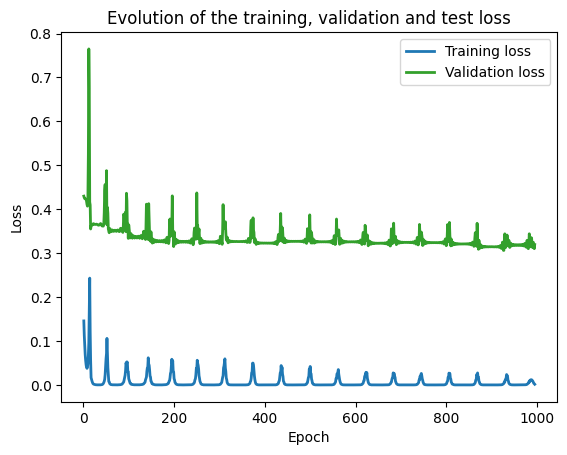

In [112]:
plot_loss(BM_reg.train_loss_history[5:], BM_reg.val_loss_history[5:])

In [113]:
# compute validation loss (burn-out first 20 epochs)
val_loss = np.mean(BM_reg.val_loss_history[-20:])

In [114]:
# Check the best models
bm_loss, bm_model, loss_history = BM_reg.select_model()

In [115]:
# Split conformal prediction 
alpha = 0.1

# store coverage indicator for every test sample
coverage_BM = []
# store size of the prediction interval 
size_BM = []
# store test loss
test_losses_BM = []
# store prediction intervals for every test sample
pi_BM = []

# initialize
C_PI = Conformal_PI(mod, device, calib_loader, alpha, y_hat_min=y_hat_min, y_hat_max=y_hat_max)


for input, response in tqdm(test_loader):
    # find prediction interval
    ci_method = C_PI.benchmark_ICP(input, bm_model)
    
    pi_BM.append(ci_method)
    # find size and coverage indicator
    size_BM.append(ci_method[0]._measure)
    coverage_BM.append(response in ci_method[0])
    # evaluate the out of sample losses
    ## load the best model
    reg_model_tmp = CES_regression(mod, device, train_loader, batch_size=batch_size, max_epoch = num_epochs, learning_rate=lr, 
                                   val_loader=val_loader,
                                   verbose = False, criterion = MSE_loss, optimizer = optimizer)
    reg_model_tmp.net.load_state_dict(torch.load(bm_model, map_location=device))
    ## compute loss on test samples
    test_loss = reg_model_tmp.get_loss(input, response)
    test_losses_BM.append(test_loss)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 53.52it/s]


In [53]:
# store conditional coverage
wsc_coverages_BM = []

# compute conditional coverage
for i in tqdm(np.arange(10)):
    wsc_coverage = wsc_unbiased(X_test, y_test, pi_BM, M=100, delta = 0.1)
    wsc_coverages_BM.append(wsc_coverage)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:17<00:00,  1.75s/it]


In [116]:
print("The marginal coverage rate is (BM) {}".format(sum(coverage_BM)/len(coverage_BM)))
print("The conditional coverage rate is (BM) {}".format(sum(wsc_coverages_BM)/len(wsc_coverages_BM)))
print("The average size is (BM) {}".format(sum(size_BM)/len(size_BM)))
print("The test loss is (BM) {}".format(sum(test_losses_BM)/len(test_losses_BM)))
print("The validation loss is (BM) {}".format(val_loss))

The marginal coverage rate is (BM) 0.92
The conditional coverage rate is (BM) 0.960885306333757
The average size is (BM) 1.87059664160013
The test loss is (BM) 0.30843445658683777
The validation loss is (BM) 0.3214162398129702


# The benchmark method ignoring exchangeability

In [55]:
# specify the number of samples in training, validation, calibration and test datasets
method_ = 'Benchmark_noexc'

seed = 2322
np.random.seed(seed)
th.manual_seed(seed)

# split the data into proper training, validation, and calibration set, set test data aside 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)
idx_test = np.random.permutation(n_test)
X_test = X_test[idx_test]
y_test = y_test[idx_test]

idx = np.random.permutation(n_train+n_val+n_cal)
idx_train_BM_noexc, idx_cal_BM_noexc = idx[:n_train+n_val], idx[n_train+n_val:n_train+n_val+n_cal]
X_train_BM_noexc, y_train_BM_noexc = X_train[idx_train_BM_noexc], y_train[idx_train_BM_noexc]
X_cal_BM_noexc, y_cal_BM_noexc = X_train[idx_cal_BM_noexc], y_train[idx_cal_BM_noexc]

print("Size (BM_noexc): train (%d, %d), calibration (%d, %d), test (%d, %d)" % \
      (X_train_BM_noexc.shape[0], X_train_BM_noexc.shape[1], 
       X_cal_BM_noexc.shape[0], X_cal_BM_noexc.shape[1], 
       X_test.shape[0], X_test.shape[1]))


Size (BM_noexc): train (1050, 100), calibration (100, 100), test (100, 100)


In [56]:
train_loader = DataLoader(PrepareData(X_train_BM_noexc, y_train_BM_noexc, scale_X=False), batch_size=batch_size)
calib_loader = DataLoader(PrepareData(X_cal_BM_noexc, y_cal_BM_noexc, scale_X=False), batch_size=1, drop_last=True)
test_loader = DataLoader(PrepareData(X_test, y_test, scale_X=False), batch_size= 1, shuffle = False)

# intialize the model
in_shape = X_train_BM_noexc.shape[1]
hidden_layer_size = 128

# intialize the model
mod = mse_model(in_shape = in_shape, hidden_size = hidden_layer_size)
optimizer = torch.optim.Adam(mod.parameters(), lr=lr, weight_decay = wd)

if th.cuda.is_available():
    # Make CuDNN Determinist
    th.backends.cudnn.deterministic = True
    th.cuda.manual_seed(seed)

# Define default device, we should use the GPU (cuda) if available
device = th.device("cuda" if th.cuda.is_available() else "cpu")

In [59]:
# intiialization
BM_reg_noexc = CES_regression(mod, 
                              device, 
                              train_loader, 
                              batch_size=batch_size, 
                              max_epoch = num_epochs, 
                              learning_rate=lr, 
                              # using calibration set to choose the best model
                              val_loader=calib_loader, 
                              criterion= MSE_loss, 
                              optimizer=optimizer, 
                              verbose = True)

===== HYPERPARAMETERS =====
batch_size= 50
n_epochs= 1000
learning_rate= 0.05


In [60]:
# Train the model and save snapshots 
save_every = 1    # Save model after every few epoches
BM_reg_noexc.full_train(save_dir = './content', save_every = save_every)

Epoch 1 of 1000, 9% 	 train_loss: 6.04  took: 0.01s
Epoch 1 of 1000, 19% 	 train_loss: 6.45  took: 0.01s
Epoch 1 of 1000, 28% 	 train_loss: 3.19  took: 0.00s
Epoch 1 of 1000, 38% 	 train_loss: 5.43  took: 0.00s
Epoch 1 of 1000, 47% 	 train_loss: 6.19  took: 0.00s
Epoch 1 of 1000, 57% 	 train_loss: 5.28  took: 0.00s
Epoch 1 of 1000, 66% 	 train_loss: 5.05  took: 0.00s
Epoch 1 of 1000, 76% 	 train_loss: 5.13  took: 0.00s
Epoch 1 of 1000, 85% 	 train_loss: 4.05  took: 0.00s
Epoch 1 of 1000, 95% 	 train_loss: 5.37  took: 0.00s
val_loss = 7.39
Snapshot saved at epoch 1.
Epoch 2 of 1000, 9% 	 train_loss: 6.05  took: 0.00s
Epoch 2 of 1000, 19% 	 train_loss: 6.45  took: 0.00s
Epoch 2 of 1000, 28% 	 train_loss: 3.14  took: 0.00s
Epoch 2 of 1000, 38% 	 train_loss: 5.37  took: 0.00s
Epoch 2 of 1000, 47% 	 train_loss: 6.23  took: 0.00s
Epoch 2 of 1000, 57% 	 train_loss: 5.24  took: 0.00s
Epoch 2 of 1000, 66% 	 train_loss: 5.05  took: 0.00s
Epoch 2 of 1000, 76% 	 train_loss: 5.12  took: 0.00s
Epoch

Epoch 16 of 1000, 85% 	 train_loss: 4.03  took: 0.00s
Epoch 16 of 1000, 95% 	 train_loss: 5.35  took: 0.00s
val_loss = 7.41
Snapshot saved at epoch 16.
Epoch 17 of 1000, 9% 	 train_loss: 6.03  took: 0.00s
Epoch 17 of 1000, 19% 	 train_loss: 6.43  took: 0.00s
Epoch 17 of 1000, 28% 	 train_loss: 3.18  took: 0.00s
Epoch 17 of 1000, 38% 	 train_loss: 5.42  took: 0.00s
Epoch 17 of 1000, 47% 	 train_loss: 6.18  took: 0.01s
Epoch 17 of 1000, 57% 	 train_loss: 5.23  took: 0.00s
Epoch 17 of 1000, 66% 	 train_loss: 5.03  took: 0.00s
Epoch 17 of 1000, 76% 	 train_loss: 5.08  took: 0.00s
Epoch 17 of 1000, 85% 	 train_loss: 4.01  took: 0.00s
Epoch 17 of 1000, 95% 	 train_loss: 5.32  took: 0.00s
val_loss = 7.38
Snapshot saved at epoch 17.
Epoch 18 of 1000, 9% 	 train_loss: 6.08  took: 0.00s
Epoch 18 of 1000, 19% 	 train_loss: 6.42  took: 0.00s
Epoch 18 of 1000, 28% 	 train_loss: 3.13  took: 0.00s
Epoch 18 of 1000, 38% 	 train_loss: 5.34  took: 0.00s
Epoch 18 of 1000, 47% 	 train_loss: 6.23  took: 0.

val_loss = 7.40
Snapshot saved at epoch 31.
Epoch 32 of 1000, 9% 	 train_loss: 6.11  took: 0.00s
Epoch 32 of 1000, 19% 	 train_loss: 6.40  took: 0.01s
Epoch 32 of 1000, 28% 	 train_loss: 3.12  took: 0.00s
Epoch 32 of 1000, 38% 	 train_loss: 5.32  took: 0.00s
Epoch 32 of 1000, 47% 	 train_loss: 6.22  took: 0.00s
Epoch 32 of 1000, 57% 	 train_loss: 5.14  took: 0.00s
Epoch 32 of 1000, 66% 	 train_loss: 5.01  took: 0.00s
Epoch 32 of 1000, 76% 	 train_loss: 5.04  took: 0.00s
Epoch 32 of 1000, 85% 	 train_loss: 4.00  took: 0.00s
Epoch 32 of 1000, 95% 	 train_loss: 5.31  took: 0.00s
val_loss = 7.44
Snapshot saved at epoch 32.
Epoch 33 of 1000, 9% 	 train_loss: 6.05  took: 0.00s
Epoch 33 of 1000, 19% 	 train_loss: 6.41  took: 0.00s
Epoch 33 of 1000, 28% 	 train_loss: 3.15  took: 0.00s
Epoch 33 of 1000, 38% 	 train_loss: 5.40  took: 0.00s
Epoch 33 of 1000, 47% 	 train_loss: 6.19  took: 0.00s
Epoch 33 of 1000, 57% 	 train_loss: 5.18  took: 0.00s
Epoch 33 of 1000, 66% 	 train_loss: 4.98  took: 0.

Epoch 49 of 1000, 38% 	 train_loss: 5.33  took: 0.00s
Epoch 49 of 1000, 47% 	 train_loss: 6.21  took: 0.00s
Epoch 49 of 1000, 57% 	 train_loss: 5.12  took: 0.00s
Epoch 49 of 1000, 66% 	 train_loss: 5.00  took: 0.00s
Epoch 49 of 1000, 76% 	 train_loss: 5.00  took: 0.00s
Epoch 49 of 1000, 85% 	 train_loss: 3.98  took: 0.00s
Epoch 49 of 1000, 95% 	 train_loss: 5.27  took: 0.00s
val_loss = 7.40
Snapshot saved at epoch 49.
Epoch 50 of 1000, 9% 	 train_loss: 6.07  took: 0.00s
Epoch 50 of 1000, 19% 	 train_loss: 6.39  took: 0.01s
Epoch 50 of 1000, 28% 	 train_loss: 3.14  took: 0.00s
Epoch 50 of 1000, 38% 	 train_loss: 5.36  took: 0.00s
Epoch 50 of 1000, 47% 	 train_loss: 6.18  took: 0.00s
Epoch 50 of 1000, 57% 	 train_loss: 5.15  took: 0.00s
Epoch 50 of 1000, 66% 	 train_loss: 5.02  took: 0.00s
Epoch 50 of 1000, 76% 	 train_loss: 5.01  took: 0.00s
Epoch 50 of 1000, 85% 	 train_loss: 3.98  took: 0.00s
Epoch 50 of 1000, 95% 	 train_loss: 5.25  took: 0.01s
val_loss = 7.38
Snapshot saved at epoch

Epoch 63 of 1000, 76% 	 train_loss: 4.98  took: 0.00s
Epoch 63 of 1000, 85% 	 train_loss: 3.97  took: 0.00s
Epoch 63 of 1000, 95% 	 train_loss: 5.23  took: 0.00s
val_loss = 7.41
Snapshot saved at epoch 63.
Epoch 64 of 1000, 9% 	 train_loss: 6.09  took: 0.00s
Epoch 64 of 1000, 19% 	 train_loss: 6.37  took: 0.00s
Epoch 64 of 1000, 28% 	 train_loss: 3.11  took: 0.00s
Epoch 64 of 1000, 38% 	 train_loss: 5.32  took: 0.00s
Epoch 64 of 1000, 47% 	 train_loss: 6.19  took: 0.00s
Epoch 64 of 1000, 57% 	 train_loss: 5.10  took: 0.00s
Epoch 64 of 1000, 66% 	 train_loss: 4.99  took: 0.00s
Epoch 64 of 1000, 76% 	 train_loss: 4.96  took: 0.00s
Epoch 64 of 1000, 85% 	 train_loss: 3.97  took: 0.00s
Epoch 64 of 1000, 95% 	 train_loss: 5.23  took: 0.00s
val_loss = 7.42
Snapshot saved at epoch 64.
Epoch 65 of 1000, 9% 	 train_loss: 6.11  took: 0.00s
Epoch 65 of 1000, 19% 	 train_loss: 6.38  took: 0.00s
Epoch 65 of 1000, 28% 	 train_loss: 3.10  took: 0.00s
Epoch 65 of 1000, 38% 	 train_loss: 5.31  took: 0.

val_loss = 7.42
Snapshot saved at epoch 77.
Epoch 78 of 1000, 9% 	 train_loss: 6.12  took: 0.00s
Epoch 78 of 1000, 19% 	 train_loss: 6.36  took: 0.00s
Epoch 78 of 1000, 28% 	 train_loss: 3.10  took: 0.01s
Epoch 78 of 1000, 38% 	 train_loss: 5.31  took: 0.00s
Epoch 78 of 1000, 47% 	 train_loss: 6.20  took: 0.00s
Epoch 78 of 1000, 57% 	 train_loss: 5.08  took: 0.00s
Epoch 78 of 1000, 66% 	 train_loss: 5.00  took: 0.00s
Epoch 78 of 1000, 76% 	 train_loss: 4.95  took: 0.00s
Epoch 78 of 1000, 85% 	 train_loss: 3.96  took: 0.00s
Epoch 78 of 1000, 95% 	 train_loss: 5.21  took: 0.00s
val_loss = 7.44
Snapshot saved at epoch 78.
Epoch 79 of 1000, 9% 	 train_loss: 6.12  took: 0.00s
Epoch 79 of 1000, 19% 	 train_loss: 6.36  took: 0.00s
Epoch 79 of 1000, 28% 	 train_loss: 3.10  took: 0.00s
Epoch 79 of 1000, 38% 	 train_loss: 5.31  took: 0.00s
Epoch 79 of 1000, 47% 	 train_loss: 6.20  took: 0.00s
Epoch 79 of 1000, 57% 	 train_loss: 5.08  took: 0.00s
Epoch 79 of 1000, 66% 	 train_loss: 4.99  took: 0.

val_loss = 7.44
Snapshot saved at epoch 92.
Epoch 93 of 1000, 9% 	 train_loss: 6.11  took: 0.00s
Epoch 93 of 1000, 19% 	 train_loss: 6.35  took: 0.00s
Epoch 93 of 1000, 28% 	 train_loss: 3.10  took: 0.00s
Epoch 93 of 1000, 38% 	 train_loss: 5.33  took: 0.00s
Epoch 93 of 1000, 47% 	 train_loss: 6.19  took: 0.00s
Epoch 93 of 1000, 57% 	 train_loss: 5.08  took: 0.00s
Epoch 93 of 1000, 66% 	 train_loss: 4.99  took: 0.00s
Epoch 93 of 1000, 76% 	 train_loss: 4.93  took: 0.00s
Epoch 93 of 1000, 85% 	 train_loss: 3.95  took: 0.00s
Epoch 93 of 1000, 95% 	 train_loss: 5.19  took: 0.00s
val_loss = 7.44
Snapshot saved at epoch 93.
Epoch 94 of 1000, 9% 	 train_loss: 6.11  took: 0.00s
Epoch 94 of 1000, 19% 	 train_loss: 6.35  took: 0.00s
Epoch 94 of 1000, 28% 	 train_loss: 3.11  took: 0.00s
Epoch 94 of 1000, 38% 	 train_loss: 5.33  took: 0.00s
Epoch 94 of 1000, 47% 	 train_loss: 6.18  took: 0.00s
Epoch 94 of 1000, 57% 	 train_loss: 5.08  took: 0.00s
Epoch 94 of 1000, 66% 	 train_loss: 4.99  took: 0.

val_loss = 7.48
Snapshot saved at epoch 106.
Epoch 107 of 1000, 9% 	 train_loss: 6.13  took: 0.00s
Epoch 107 of 1000, 19% 	 train_loss: 6.34  took: 0.00s
Epoch 107 of 1000, 28% 	 train_loss: 3.09  took: 0.00s
Epoch 107 of 1000, 38% 	 train_loss: 5.32  took: 0.00s
Epoch 107 of 1000, 47% 	 train_loss: 6.20  took: 0.00s
Epoch 107 of 1000, 57% 	 train_loss: 5.06  took: 0.00s
Epoch 107 of 1000, 66% 	 train_loss: 4.99  took: 0.00s
Epoch 107 of 1000, 76% 	 train_loss: 4.91  took: 0.00s
Epoch 107 of 1000, 85% 	 train_loss: 3.94  took: 0.00s
Epoch 107 of 1000, 95% 	 train_loss: 5.17  took: 0.00s
val_loss = 7.49
Snapshot saved at epoch 107.
Epoch 108 of 1000, 9% 	 train_loss: 6.14  took: 0.00s
Epoch 108 of 1000, 19% 	 train_loss: 6.34  took: 0.00s
Epoch 108 of 1000, 28% 	 train_loss: 3.09  took: 0.00s
Epoch 108 of 1000, 38% 	 train_loss: 5.31  took: 0.00s
Epoch 108 of 1000, 47% 	 train_loss: 6.20  took: 0.00s
Epoch 108 of 1000, 57% 	 train_loss: 5.06  took: 0.00s
Epoch 108 of 1000, 66% 	 train_l

Epoch 121 of 1000, 76% 	 train_loss: 4.90  took: 0.00s
Epoch 121 of 1000, 85% 	 train_loss: 3.94  took: 0.00s
Epoch 121 of 1000, 95% 	 train_loss: 5.15  took: 0.00s
val_loss = 7.53
Snapshot saved at epoch 121.
Epoch 122 of 1000, 9% 	 train_loss: 6.15  took: 0.00s
Epoch 122 of 1000, 19% 	 train_loss: 6.34  took: 0.00s
Epoch 122 of 1000, 28% 	 train_loss: 3.10  took: 0.00s
Epoch 122 of 1000, 38% 	 train_loss: 5.33  took: 0.00s
Epoch 122 of 1000, 47% 	 train_loss: 6.19  took: 0.00s
Epoch 122 of 1000, 57% 	 train_loss: 5.06  took: 0.00s
Epoch 122 of 1000, 66% 	 train_loss: 4.99  took: 0.00s
Epoch 122 of 1000, 76% 	 train_loss: 4.90  took: 0.00s
Epoch 122 of 1000, 85% 	 train_loss: 3.94  took: 0.00s
Epoch 122 of 1000, 95% 	 train_loss: 5.14  took: 0.00s
val_loss = 7.54
Snapshot saved at epoch 122.
Epoch 123 of 1000, 9% 	 train_loss: 6.15  took: 0.00s
Epoch 123 of 1000, 19% 	 train_loss: 6.34  took: 0.00s
Epoch 123 of 1000, 28% 	 train_loss: 3.07  took: 0.00s
Epoch 123 of 1000, 38% 	 train_l

Epoch 135 of 1000, 76% 	 train_loss: 4.93  took: 0.00s
Epoch 135 of 1000, 85% 	 train_loss: 3.93  took: 0.00s
Epoch 135 of 1000, 95% 	 train_loss: 5.14  took: 0.00s
val_loss = 7.57
Snapshot saved at epoch 135.
Epoch 136 of 1000, 9% 	 train_loss: 6.15  took: 0.00s
Epoch 136 of 1000, 19% 	 train_loss: 6.33  took: 0.00s
Epoch 136 of 1000, 28% 	 train_loss: 3.09  took: 0.00s
Epoch 136 of 1000, 38% 	 train_loss: 5.35  took: 0.00s
Epoch 136 of 1000, 47% 	 train_loss: 6.19  took: 0.00s
Epoch 136 of 1000, 57% 	 train_loss: 5.07  took: 0.00s
Epoch 136 of 1000, 66% 	 train_loss: 4.95  took: 0.00s
Epoch 136 of 1000, 76% 	 train_loss: 4.87  took: 0.00s
Epoch 136 of 1000, 85% 	 train_loss: 3.92  took: 0.00s
Epoch 136 of 1000, 95% 	 train_loss: 5.11  took: 0.00s
val_loss = 7.64
Snapshot saved at epoch 136.
Epoch 137 of 1000, 9% 	 train_loss: 6.16  took: 0.00s
Epoch 137 of 1000, 19% 	 train_loss: 6.33  took: 0.00s
Epoch 137 of 1000, 28% 	 train_loss: 3.04  took: 0.00s
Epoch 137 of 1000, 38% 	 train_l

val_loss = 7.65
Snapshot saved at epoch 150.
Epoch 151 of 1000, 9% 	 train_loss: 6.19  took: 0.00s
Epoch 151 of 1000, 19% 	 train_loss: 6.34  took: 0.00s
Epoch 151 of 1000, 28% 	 train_loss: 3.01  took: 0.00s
Epoch 151 of 1000, 38% 	 train_loss: 5.41  took: 0.00s
Epoch 151 of 1000, 47% 	 train_loss: 6.28  took: 0.00s
Epoch 151 of 1000, 57% 	 train_loss: 5.08  took: 0.00s
Epoch 151 of 1000, 66% 	 train_loss: 5.05  took: 0.00s
Epoch 151 of 1000, 76% 	 train_loss: 5.00  took: 0.00s
Epoch 151 of 1000, 85% 	 train_loss: 3.89  took: 0.00s
Epoch 151 of 1000, 95% 	 train_loss: 5.09  took: 0.00s
val_loss = 7.63
Snapshot saved at epoch 151.
Epoch 152 of 1000, 9% 	 train_loss: 6.15  took: 0.00s
Epoch 152 of 1000, 19% 	 train_loss: 6.32  took: 0.00s
Epoch 152 of 1000, 28% 	 train_loss: 3.03  took: 0.00s
Epoch 152 of 1000, 38% 	 train_loss: 5.43  took: 0.00s
Epoch 152 of 1000, 47% 	 train_loss: 6.28  took: 0.00s
Epoch 152 of 1000, 57% 	 train_loss: 5.15  took: 0.00s
Epoch 152 of 1000, 66% 	 train_l

val_loss = 8.06
Snapshot saved at epoch 166.
Epoch 167 of 1000, 9% 	 train_loss: 6.28  took: 0.00s
Epoch 167 of 1000, 19% 	 train_loss: 6.40  took: 0.00s
Epoch 167 of 1000, 28% 	 train_loss: 3.09  took: 0.00s
Epoch 167 of 1000, 38% 	 train_loss: 5.63  took: 0.00s
Epoch 167 of 1000, 47% 	 train_loss: 6.29  took: 0.00s
Epoch 167 of 1000, 57% 	 train_loss: 5.24  took: 0.00s
Epoch 167 of 1000, 66% 	 train_loss: 5.09  took: 0.00s
Epoch 167 of 1000, 76% 	 train_loss: 4.99  took: 0.00s
Epoch 167 of 1000, 85% 	 train_loss: 3.94  took: 0.00s
Epoch 167 of 1000, 95% 	 train_loss: 5.04  took: 0.00s
val_loss = 8.04
Snapshot saved at epoch 167.
Epoch 168 of 1000, 9% 	 train_loss: 6.26  took: 0.00s
Epoch 168 of 1000, 19% 	 train_loss: 6.40  took: 0.00s
Epoch 168 of 1000, 28% 	 train_loss: 3.10  took: 0.00s
Epoch 168 of 1000, 38% 	 train_loss: 5.65  took: 0.00s
Epoch 168 of 1000, 47% 	 train_loss: 6.26  took: 0.00s
Epoch 168 of 1000, 57% 	 train_loss: 5.24  took: 0.00s
Epoch 168 of 1000, 66% 	 train_l

val_loss = 8.87
Snapshot saved at epoch 182.
Epoch 183 of 1000, 9% 	 train_loss: 6.44  took: 0.00s
Epoch 183 of 1000, 19% 	 train_loss: 6.82  took: 0.00s
Epoch 183 of 1000, 28% 	 train_loss: 4.56  took: 0.00s
Epoch 183 of 1000, 38% 	 train_loss: 5.78  took: 0.00s
Epoch 183 of 1000, 47% 	 train_loss: 7.56  took: 0.00s
Epoch 183 of 1000, 57% 	 train_loss: 5.37  took: 0.00s
Epoch 183 of 1000, 66% 	 train_loss: 5.10  took: 0.00s
Epoch 183 of 1000, 76% 	 train_loss: 4.84  took: 0.00s
Epoch 183 of 1000, 85% 	 train_loss: 4.19  took: 0.00s
Epoch 183 of 1000, 95% 	 train_loss: 6.61  took: 0.00s
val_loss = 8.11
Snapshot saved at epoch 183.
Epoch 184 of 1000, 9% 	 train_loss: 6.20  took: 0.00s
Epoch 184 of 1000, 19% 	 train_loss: 7.01  took: 0.00s
Epoch 184 of 1000, 28% 	 train_loss: 4.53  took: 0.00s
Epoch 184 of 1000, 38% 	 train_loss: 5.62  took: 0.00s
Epoch 184 of 1000, 47% 	 train_loss: 7.78  took: 0.00s
Epoch 184 of 1000, 57% 	 train_loss: 4.94  took: 0.00s
Epoch 184 of 1000, 66% 	 train_l

Epoch 197 of 1000, 66% 	 train_loss: 4.81  took: 0.00s
Epoch 197 of 1000, 76% 	 train_loss: 4.59  took: 0.00s
Epoch 197 of 1000, 85% 	 train_loss: 3.83  took: 0.00s
Epoch 197 of 1000, 95% 	 train_loss: 5.65  took: 0.00s
val_loss = 7.67
Snapshot saved at epoch 197.
Epoch 198 of 1000, 9% 	 train_loss: 5.88  took: 0.00s
Epoch 198 of 1000, 19% 	 train_loss: 6.52  took: 0.00s
Epoch 198 of 1000, 28% 	 train_loss: 3.38  took: 0.00s
Epoch 198 of 1000, 38% 	 train_loss: 5.23  took: 0.00s
Epoch 198 of 1000, 47% 	 train_loss: 6.64  took: 0.00s
Epoch 198 of 1000, 57% 	 train_loss: 4.73  took: 0.01s
Epoch 198 of 1000, 66% 	 train_loss: 4.80  took: 0.00s
Epoch 198 of 1000, 76% 	 train_loss: 4.58  took: 0.00s
Epoch 198 of 1000, 85% 	 train_loss: 3.83  took: 0.00s
Epoch 198 of 1000, 95% 	 train_loss: 5.64  took: 0.00s
val_loss = 7.63
Snapshot saved at epoch 198.
Epoch 199 of 1000, 9% 	 train_loss: 5.88  took: 0.00s
Epoch 199 of 1000, 19% 	 train_loss: 6.52  took: 0.00s
Epoch 199 of 1000, 28% 	 train_l

Epoch 211 of 1000, 95% 	 train_loss: 5.56  took: 0.00s
val_loss = 7.56
Snapshot saved at epoch 211.
Epoch 212 of 1000, 9% 	 train_loss: 5.86  took: 0.01s
Epoch 212 of 1000, 19% 	 train_loss: 6.49  took: 0.00s
Epoch 212 of 1000, 28% 	 train_loss: 3.32  took: 0.00s
Epoch 212 of 1000, 38% 	 train_loss: 5.23  took: 0.00s
Epoch 212 of 1000, 47% 	 train_loss: 6.60  took: 0.00s
Epoch 212 of 1000, 57% 	 train_loss: 4.71  took: 0.00s
Epoch 212 of 1000, 66% 	 train_loss: 4.80  took: 0.00s
Epoch 212 of 1000, 76% 	 train_loss: 4.60  took: 0.00s
Epoch 212 of 1000, 85% 	 train_loss: 3.81  took: 0.00s
Epoch 212 of 1000, 95% 	 train_loss: 5.57  took: 0.01s
val_loss = 7.54
Snapshot saved at epoch 212.
Epoch 213 of 1000, 9% 	 train_loss: 5.85  took: 0.01s
Epoch 213 of 1000, 19% 	 train_loss: 6.50  took: 0.01s
Epoch 213 of 1000, 28% 	 train_loss: 3.34  took: 0.00s
Epoch 213 of 1000, 38% 	 train_loss: 5.24  took: 0.00s
Epoch 213 of 1000, 47% 	 train_loss: 6.61  took: 0.00s
Epoch 213 of 1000, 57% 	 train_l

Epoch 226 of 1000, 57% 	 train_loss: 4.67  took: 0.00s
Epoch 226 of 1000, 66% 	 train_loss: 4.80  took: 0.00s
Epoch 226 of 1000, 76% 	 train_loss: 4.57  took: 0.00s
Epoch 226 of 1000, 85% 	 train_loss: 3.84  took: 0.00s
Epoch 226 of 1000, 95% 	 train_loss: 5.53  took: 0.00s
val_loss = 7.45
Snapshot saved at epoch 226.
Epoch 227 of 1000, 9% 	 train_loss: 5.75  took: 0.00s
Epoch 227 of 1000, 19% 	 train_loss: 6.53  took: 0.00s
Epoch 227 of 1000, 28% 	 train_loss: 3.27  took: 0.00s
Epoch 227 of 1000, 38% 	 train_loss: 5.26  took: 0.00s
Epoch 227 of 1000, 47% 	 train_loss: 6.53  took: 0.00s
Epoch 227 of 1000, 57% 	 train_loss: 4.67  took: 0.00s
Epoch 227 of 1000, 66% 	 train_loss: 4.81  took: 0.00s
Epoch 227 of 1000, 76% 	 train_loss: 4.55  took: 0.00s
Epoch 227 of 1000, 85% 	 train_loss: 3.77  took: 0.00s
Epoch 227 of 1000, 95% 	 train_loss: 5.51  took: 0.00s
val_loss = 7.49
Snapshot saved at epoch 227.
Epoch 228 of 1000, 9% 	 train_loss: 5.80  took: 0.00s
Epoch 228 of 1000, 19% 	 train_l

Epoch 241 of 1000, 57% 	 train_loss: 4.67  took: 0.00s
Epoch 241 of 1000, 66% 	 train_loss: 4.80  took: 0.00s
Epoch 241 of 1000, 76% 	 train_loss: 4.51  took: 0.00s
Epoch 241 of 1000, 85% 	 train_loss: 3.77  took: 0.00s
Epoch 241 of 1000, 95% 	 train_loss: 5.48  took: 0.00s
val_loss = 7.61
Snapshot saved at epoch 241.
Epoch 242 of 1000, 9% 	 train_loss: 5.81  took: 0.00s
Epoch 242 of 1000, 19% 	 train_loss: 6.38  took: 0.00s
Epoch 242 of 1000, 28% 	 train_loss: 3.31  took: 0.00s
Epoch 242 of 1000, 38% 	 train_loss: 5.32  took: 0.00s
Epoch 242 of 1000, 47% 	 train_loss: 6.59  took: 0.00s
Epoch 242 of 1000, 57% 	 train_loss: 4.66  took: 0.00s
Epoch 242 of 1000, 66% 	 train_loss: 4.83  took: 0.00s
Epoch 242 of 1000, 76% 	 train_loss: 4.54  took: 0.00s
Epoch 242 of 1000, 85% 	 train_loss: 3.92  took: 0.00s
Epoch 242 of 1000, 95% 	 train_loss: 5.58  took: 0.00s
val_loss = 7.32
Snapshot saved at epoch 242.
Epoch 243 of 1000, 9% 	 train_loss: 5.72  took: 0.00s
Epoch 243 of 1000, 19% 	 train_l

Epoch 256 of 1000, 38% 	 train_loss: 5.36  took: 0.01s
Epoch 256 of 1000, 47% 	 train_loss: 6.76  took: 0.00s
Epoch 256 of 1000, 57% 	 train_loss: 4.64  took: 0.00s
Epoch 256 of 1000, 66% 	 train_loss: 4.90  took: 0.00s
Epoch 256 of 1000, 76% 	 train_loss: 4.51  took: 0.00s
Epoch 256 of 1000, 85% 	 train_loss: 3.81  took: 0.00s
Epoch 256 of 1000, 95% 	 train_loss: 5.61  took: 0.00s
val_loss = 7.58
Snapshot saved at epoch 256.
Epoch 257 of 1000, 9% 	 train_loss: 5.81  took: 0.00s
Epoch 257 of 1000, 19% 	 train_loss: 6.45  took: 0.00s
Epoch 257 of 1000, 28% 	 train_loss: 3.31  took: 0.00s
Epoch 257 of 1000, 38% 	 train_loss: 5.33  took: 0.00s
Epoch 257 of 1000, 47% 	 train_loss: 6.61  took: 0.00s
Epoch 257 of 1000, 57% 	 train_loss: 4.61  took: 0.00s
Epoch 257 of 1000, 66% 	 train_loss: 4.81  took: 0.00s
Epoch 257 of 1000, 76% 	 train_loss: 4.45  took: 0.00s
Epoch 257 of 1000, 85% 	 train_loss: 3.81  took: 0.00s
Epoch 257 of 1000, 95% 	 train_loss: 5.47  took: 0.00s
val_loss = 7.48
Snaps

Epoch 273 of 1000, 66% 	 train_loss: 4.80  took: 0.00s
Epoch 273 of 1000, 76% 	 train_loss: 4.50  took: 0.00s
Epoch 273 of 1000, 85% 	 train_loss: 3.79  took: 0.00s
Epoch 273 of 1000, 95% 	 train_loss: 5.46  took: 0.00s
val_loss = 7.55
Snapshot saved at epoch 273.
Epoch 274 of 1000, 9% 	 train_loss: 5.82  took: 0.00s
Epoch 274 of 1000, 19% 	 train_loss: 6.34  took: 0.00s
Epoch 274 of 1000, 28% 	 train_loss: 3.23  took: 0.00s
Epoch 274 of 1000, 38% 	 train_loss: 5.29  took: 0.00s
Epoch 274 of 1000, 47% 	 train_loss: 6.50  took: 0.01s
Epoch 274 of 1000, 57% 	 train_loss: 4.59  took: 0.00s
Epoch 274 of 1000, 66% 	 train_loss: 4.80  took: 0.00s
Epoch 274 of 1000, 76% 	 train_loss: 4.45  took: 0.00s
Epoch 274 of 1000, 85% 	 train_loss: 3.79  took: 0.00s
Epoch 274 of 1000, 95% 	 train_loss: 5.44  took: 0.00s
val_loss = 7.58
Snapshot saved at epoch 274.
Epoch 275 of 1000, 9% 	 train_loss: 5.82  took: 0.00s
Epoch 275 of 1000, 19% 	 train_loss: 6.37  took: 0.00s
Epoch 275 of 1000, 28% 	 train_l

Epoch 289 of 1000, 76% 	 train_loss: 4.50  took: 0.00s
Epoch 289 of 1000, 85% 	 train_loss: 3.89  took: 0.00s
Epoch 289 of 1000, 95% 	 train_loss: 5.54  took: 0.00s
val_loss = 7.38
Snapshot saved at epoch 289.
Epoch 290 of 1000, 9% 	 train_loss: 5.74  took: 0.00s
Epoch 290 of 1000, 19% 	 train_loss: 6.49  took: 0.00s
Epoch 290 of 1000, 28% 	 train_loss: 3.27  took: 0.00s
Epoch 290 of 1000, 38% 	 train_loss: 5.32  took: 0.00s
Epoch 290 of 1000, 47% 	 train_loss: 6.53  took: 0.00s
Epoch 290 of 1000, 57% 	 train_loss: 4.60  took: 0.00s
Epoch 290 of 1000, 66% 	 train_loss: 4.85  took: 0.00s
Epoch 290 of 1000, 76% 	 train_loss: 4.46  took: 0.00s
Epoch 290 of 1000, 85% 	 train_loss: 3.80  took: 0.00s
Epoch 290 of 1000, 95% 	 train_loss: 5.48  took: 0.00s
val_loss = 7.48
Snapshot saved at epoch 290.
Epoch 291 of 1000, 9% 	 train_loss: 5.81  took: 0.00s
Epoch 291 of 1000, 19% 	 train_loss: 6.45  took: 0.00s
Epoch 291 of 1000, 28% 	 train_loss: 3.47  took: 0.00s
Epoch 291 of 1000, 38% 	 train_l

Epoch 304 of 1000, 38% 	 train_loss: 5.24  took: 0.00s
Epoch 304 of 1000, 47% 	 train_loss: 6.36  took: 0.00s
Epoch 304 of 1000, 57% 	 train_loss: 4.65  took: 0.00s
Epoch 304 of 1000, 66% 	 train_loss: 4.77  took: 0.00s
Epoch 304 of 1000, 76% 	 train_loss: 4.48  took: 0.00s
Epoch 304 of 1000, 85% 	 train_loss: 3.79  took: 0.00s
Epoch 304 of 1000, 95% 	 train_loss: 5.43  took: 0.00s
val_loss = 7.74
Snapshot saved at epoch 304.
Epoch 305 of 1000, 9% 	 train_loss: 5.84  took: 0.00s
Epoch 305 of 1000, 19% 	 train_loss: 6.48  took: 0.00s
Epoch 305 of 1000, 28% 	 train_loss: 3.18  took: 0.00s
Epoch 305 of 1000, 38% 	 train_loss: 5.25  took: 0.00s
Epoch 305 of 1000, 47% 	 train_loss: 6.37  took: 0.00s
Epoch 305 of 1000, 57% 	 train_loss: 4.69  took: 0.00s
Epoch 305 of 1000, 66% 	 train_loss: 4.76  took: 0.00s
Epoch 305 of 1000, 76% 	 train_loss: 4.47  took: 0.00s
Epoch 305 of 1000, 85% 	 train_loss: 3.80  took: 0.00s
Epoch 305 of 1000, 95% 	 train_loss: 5.44  took: 0.00s
val_loss = 7.73
Snaps

Epoch 318 of 1000, 38% 	 train_loss: 5.24  took: 0.00s
Epoch 318 of 1000, 47% 	 train_loss: 6.41  took: 0.00s
Epoch 318 of 1000, 57% 	 train_loss: 4.66  took: 0.00s
Epoch 318 of 1000, 66% 	 train_loss: 4.76  took: 0.00s
Epoch 318 of 1000, 76% 	 train_loss: 4.45  took: 0.00s
Epoch 318 of 1000, 85% 	 train_loss: 3.90  took: 0.00s
Epoch 318 of 1000, 95% 	 train_loss: 5.53  took: 0.00s
val_loss = 7.55
Snapshot saved at epoch 318.
Epoch 319 of 1000, 9% 	 train_loss: 5.77  took: 0.00s
Epoch 319 of 1000, 19% 	 train_loss: 6.52  took: 0.00s
Epoch 319 of 1000, 28% 	 train_loss: 3.24  took: 0.00s
Epoch 319 of 1000, 38% 	 train_loss: 5.23  took: 0.00s
Epoch 319 of 1000, 47% 	 train_loss: 6.45  took: 0.00s
Epoch 319 of 1000, 57% 	 train_loss: 4.61  took: 0.00s
Epoch 319 of 1000, 66% 	 train_loss: 4.80  took: 0.00s
Epoch 319 of 1000, 76% 	 train_loss: 4.44  took: 0.00s
Epoch 319 of 1000, 85% 	 train_loss: 3.84  took: 0.00s
Epoch 319 of 1000, 95% 	 train_loss: 5.47  took: 0.00s
val_loss = 7.64
Snaps

Epoch 332 of 1000, 85% 	 train_loss: 3.87  took: 0.00s
Epoch 332 of 1000, 95% 	 train_loss: 5.55  took: 0.00s
val_loss = 7.53
Snapshot saved at epoch 332.
Epoch 333 of 1000, 9% 	 train_loss: 5.74  took: 0.00s
Epoch 333 of 1000, 19% 	 train_loss: 6.56  took: 0.00s
Epoch 333 of 1000, 28% 	 train_loss: 3.23  took: 0.00s
Epoch 333 of 1000, 38% 	 train_loss: 5.24  took: 0.00s
Epoch 333 of 1000, 47% 	 train_loss: 6.41  took: 0.00s
Epoch 333 of 1000, 57% 	 train_loss: 4.61  took: 0.00s
Epoch 333 of 1000, 66% 	 train_loss: 4.79  took: 0.00s
Epoch 333 of 1000, 76% 	 train_loss: 4.35  took: 0.00s
Epoch 333 of 1000, 85% 	 train_loss: 4.01  took: 0.00s
Epoch 333 of 1000, 95% 	 train_loss: 5.51  took: 0.00s
val_loss = 7.35
Snapshot saved at epoch 333.
Epoch 334 of 1000, 9% 	 train_loss: 5.70  took: 0.00s
Epoch 334 of 1000, 19% 	 train_loss: 6.58  took: 0.00s
Epoch 334 of 1000, 28% 	 train_loss: 3.23  took: 0.00s
Epoch 334 of 1000, 38% 	 train_loss: 5.20  took: 0.00s
Epoch 334 of 1000, 47% 	 train_l

Epoch 347 of 1000, 38% 	 train_loss: 5.33  took: 0.00s
Epoch 347 of 1000, 47% 	 train_loss: 6.34  took: 0.00s
Epoch 347 of 1000, 57% 	 train_loss: 4.70  took: 0.00s
Epoch 347 of 1000, 66% 	 train_loss: 4.82  took: 0.00s
Epoch 347 of 1000, 76% 	 train_loss: 4.62  took: 0.00s
Epoch 347 of 1000, 85% 	 train_loss: 3.73  took: 0.00s
Epoch 347 of 1000, 95% 	 train_loss: 5.34  took: 0.00s
val_loss = 7.39
Snapshot saved at epoch 347.
Epoch 348 of 1000, 9% 	 train_loss: 5.82  took: 0.00s
Epoch 348 of 1000, 19% 	 train_loss: 6.50  took: 0.00s
Epoch 348 of 1000, 28% 	 train_loss: 3.20  took: 0.00s
Epoch 348 of 1000, 38% 	 train_loss: 5.27  took: 0.00s
Epoch 348 of 1000, 47% 	 train_loss: 6.27  took: 0.00s
Epoch 348 of 1000, 57% 	 train_loss: 4.86  took: 0.00s
Epoch 348 of 1000, 66% 	 train_loss: 4.77  took: 0.01s
Epoch 348 of 1000, 76% 	 train_loss: 4.65  took: 0.00s
Epoch 348 of 1000, 85% 	 train_loss: 3.67  took: 0.00s
Epoch 348 of 1000, 95% 	 train_loss: 5.37  took: 0.00s
val_loss = 7.68
Snaps

val_loss = 7.75
Snapshot saved at epoch 362.
Epoch 363 of 1000, 9% 	 train_loss: 5.85  took: 0.01s
Epoch 363 of 1000, 19% 	 train_loss: 6.41  took: 0.01s
Epoch 363 of 1000, 28% 	 train_loss: 3.12  took: 0.01s
Epoch 363 of 1000, 38% 	 train_loss: 5.24  took: 0.00s
Epoch 363 of 1000, 47% 	 train_loss: 6.35  took: 0.00s
Epoch 363 of 1000, 57% 	 train_loss: 4.67  took: 0.01s
Epoch 363 of 1000, 66% 	 train_loss: 4.76  took: 0.00s
Epoch 363 of 1000, 76% 	 train_loss: 4.43  took: 0.00s
Epoch 363 of 1000, 85% 	 train_loss: 3.89  took: 0.00s
Epoch 363 of 1000, 95% 	 train_loss: 5.48  took: 0.00s
val_loss = 7.52
Snapshot saved at epoch 363.
Epoch 364 of 1000, 9% 	 train_loss: 5.78  took: 0.00s
Epoch 364 of 1000, 19% 	 train_loss: 6.49  took: 0.00s
Epoch 364 of 1000, 28% 	 train_loss: 3.24  took: 0.00s
Epoch 364 of 1000, 38% 	 train_loss: 5.23  took: 0.00s
Epoch 364 of 1000, 47% 	 train_loss: 6.45  took: 0.01s
Epoch 364 of 1000, 57% 	 train_loss: 4.61  took: 0.00s
Epoch 364 of 1000, 66% 	 train_l

val_loss = 7.83
Snapshot saved at epoch 379.
Epoch 380 of 1000, 9% 	 train_loss: 5.77  took: 0.00s
Epoch 380 of 1000, 19% 	 train_loss: 6.51  took: 0.00s
Epoch 380 of 1000, 28% 	 train_loss: 3.08  took: 0.00s
Epoch 380 of 1000, 38% 	 train_loss: 5.24  took: 0.00s
Epoch 380 of 1000, 47% 	 train_loss: 6.27  took: 0.00s
Epoch 380 of 1000, 57% 	 train_loss: 4.75  took: 0.00s
Epoch 380 of 1000, 66% 	 train_loss: 4.75  took: 0.00s
Epoch 380 of 1000, 76% 	 train_loss: 4.44  took: 0.00s
Epoch 380 of 1000, 85% 	 train_loss: 3.75  took: 0.00s
Epoch 380 of 1000, 95% 	 train_loss: 5.36  took: 0.00s
val_loss = 7.99
Snapshot saved at epoch 380.
Epoch 381 of 1000, 9% 	 train_loss: 5.89  took: 0.01s
Epoch 381 of 1000, 19% 	 train_loss: 6.38  took: 0.00s
Epoch 381 of 1000, 28% 	 train_loss: 3.20  took: 0.00s
Epoch 381 of 1000, 38% 	 train_loss: 5.26  took: 0.00s
Epoch 381 of 1000, 47% 	 train_loss: 6.42  took: 0.00s
Epoch 381 of 1000, 57% 	 train_loss: 4.80  took: 0.00s
Epoch 381 of 1000, 66% 	 train_l

val_loss = 7.50
Snapshot saved at epoch 393.
Epoch 394 of 1000, 9% 	 train_loss: 5.76  took: 0.01s
Epoch 394 of 1000, 19% 	 train_loss: 6.50  took: 0.00s
Epoch 394 of 1000, 28% 	 train_loss: 3.19  took: 0.01s
Epoch 394 of 1000, 38% 	 train_loss: 5.23  took: 0.01s
Epoch 394 of 1000, 47% 	 train_loss: 6.43  took: 0.00s
Epoch 394 of 1000, 57% 	 train_loss: 4.64  took: 0.00s
Epoch 394 of 1000, 66% 	 train_loss: 4.75  took: 0.00s
Epoch 394 of 1000, 76% 	 train_loss: 4.45  took: 0.01s
Epoch 394 of 1000, 85% 	 train_loss: 3.90  took: 0.00s
Epoch 394 of 1000, 95% 	 train_loss: 5.54  took: 0.00s
val_loss = 7.25
Snapshot saved at epoch 394.
Epoch 395 of 1000, 9% 	 train_loss: 5.65  took: 0.00s
Epoch 395 of 1000, 19% 	 train_loss: 6.54  took: 0.00s
Epoch 395 of 1000, 28% 	 train_loss: 3.19  took: 0.00s
Epoch 395 of 1000, 38% 	 train_loss: 5.20  took: 0.00s
Epoch 395 of 1000, 47% 	 train_loss: 6.47  took: 0.00s
Epoch 395 of 1000, 57% 	 train_loss: 4.63  took: 0.00s
Epoch 395 of 1000, 66% 	 train_l

Epoch 408 of 1000, 9% 	 train_loss: 5.79  took: 0.00s
Epoch 408 of 1000, 19% 	 train_loss: 6.38  took: 0.00s
Epoch 408 of 1000, 28% 	 train_loss: 3.17  took: 0.00s
Epoch 408 of 1000, 38% 	 train_loss: 5.24  took: 0.00s
Epoch 408 of 1000, 47% 	 train_loss: 6.42  took: 0.00s
Epoch 408 of 1000, 57% 	 train_loss: 4.74  took: 0.00s
Epoch 408 of 1000, 66% 	 train_loss: 4.71  took: 0.00s
Epoch 408 of 1000, 76% 	 train_loss: 4.39  took: 0.00s
Epoch 408 of 1000, 85% 	 train_loss: 3.73  took: 0.00s
Epoch 408 of 1000, 95% 	 train_loss: 5.48  took: 0.00s
val_loss = 7.76
Snapshot saved at epoch 408.
Epoch 409 of 1000, 9% 	 train_loss: 5.82  took: 0.00s
Epoch 409 of 1000, 19% 	 train_loss: 6.42  took: 0.00s
Epoch 409 of 1000, 28% 	 train_loss: 3.15  took: 0.00s
Epoch 409 of 1000, 38% 	 train_loss: 5.26  took: 0.00s
Epoch 409 of 1000, 47% 	 train_loss: 6.39  took: 0.00s
Epoch 409 of 1000, 57% 	 train_loss: 4.71  took: 0.00s
Epoch 409 of 1000, 66% 	 train_loss: 4.72  took: 0.00s
Epoch 409 of 1000, 76%

Epoch 421 of 1000, 95% 	 train_loss: 5.52  took: 0.00s
val_loss = 7.55
Snapshot saved at epoch 421.
Epoch 422 of 1000, 9% 	 train_loss: 5.78  took: 0.00s
Epoch 422 of 1000, 19% 	 train_loss: 6.49  took: 0.00s
Epoch 422 of 1000, 28% 	 train_loss: 3.20  took: 0.00s
Epoch 422 of 1000, 38% 	 train_loss: 5.25  took: 0.00s
Epoch 422 of 1000, 47% 	 train_loss: 6.50  took: 0.00s
Epoch 422 of 1000, 57% 	 train_loss: 4.62  took: 0.00s
Epoch 422 of 1000, 66% 	 train_loss: 4.72  took: 0.00s
Epoch 422 of 1000, 76% 	 train_loss: 4.48  took: 0.00s
Epoch 422 of 1000, 85% 	 train_loss: 3.79  took: 0.00s
Epoch 422 of 1000, 95% 	 train_loss: 5.55  took: 0.00s
val_loss = 7.50
Snapshot saved at epoch 422.
Epoch 423 of 1000, 9% 	 train_loss: 5.77  took: 0.00s
Epoch 423 of 1000, 19% 	 train_loss: 6.48  took: 0.01s
Epoch 423 of 1000, 28% 	 train_loss: 3.20  took: 0.00s
Epoch 423 of 1000, 38% 	 train_loss: 5.23  took: 0.00s
Epoch 423 of 1000, 47% 	 train_loss: 6.50  took: 0.00s
Epoch 423 of 1000, 57% 	 train_l

Epoch 436 of 1000, 95% 	 train_loss: 5.48  took: 0.00s
val_loss = 7.32
Snapshot saved at epoch 436.
Epoch 437 of 1000, 9% 	 train_loss: 5.78  took: 0.00s
Epoch 437 of 1000, 19% 	 train_loss: 6.51  took: 0.00s
Epoch 437 of 1000, 28% 	 train_loss: 3.22  took: 0.00s
Epoch 437 of 1000, 38% 	 train_loss: 5.27  took: 0.00s
Epoch 437 of 1000, 47% 	 train_loss: 6.43  took: 0.00s
Epoch 437 of 1000, 57% 	 train_loss: 4.58  took: 0.00s
Epoch 437 of 1000, 66% 	 train_loss: 4.78  took: 0.00s
Epoch 437 of 1000, 76% 	 train_loss: 4.51  took: 0.00s
Epoch 437 of 1000, 85% 	 train_loss: 3.79  took: 0.00s
Epoch 437 of 1000, 95% 	 train_loss: 5.46  took: 0.00s
val_loss = 7.40
Snapshot saved at epoch 437.
Epoch 438 of 1000, 9% 	 train_loss: 5.80  took: 0.00s
Epoch 438 of 1000, 19% 	 train_loss: 6.67  took: 0.00s
Epoch 438 of 1000, 28% 	 train_loss: 3.26  took: 0.00s
Epoch 438 of 1000, 38% 	 train_loss: 5.34  took: 0.01s
Epoch 438 of 1000, 47% 	 train_loss: 6.43  took: 0.01s
Epoch 438 of 1000, 57% 	 train_l

Epoch 451 of 1000, 19% 	 train_loss: 6.47  took: 0.01s
Epoch 451 of 1000, 28% 	 train_loss: 3.15  took: 0.01s
Epoch 451 of 1000, 38% 	 train_loss: 5.22  took: 0.00s
Epoch 451 of 1000, 47% 	 train_loss: 6.39  took: 0.00s
Epoch 451 of 1000, 57% 	 train_loss: 4.62  took: 0.00s
Epoch 451 of 1000, 66% 	 train_loss: 4.75  took: 0.00s
Epoch 451 of 1000, 76% 	 train_loss: 4.51  took: 0.00s
Epoch 451 of 1000, 85% 	 train_loss: 3.79  took: 0.00s
Epoch 451 of 1000, 95% 	 train_loss: 5.45  took: 0.00s
val_loss = 7.52
Snapshot saved at epoch 451.
Epoch 452 of 1000, 9% 	 train_loss: 5.80  took: 0.00s
Epoch 452 of 1000, 19% 	 train_loss: 6.45  took: 0.00s
Epoch 452 of 1000, 28% 	 train_loss: 3.17  took: 0.00s
Epoch 452 of 1000, 38% 	 train_loss: 5.23  took: 0.00s
Epoch 452 of 1000, 47% 	 train_loss: 6.40  took: 0.00s
Epoch 452 of 1000, 57% 	 train_loss: 4.62  took: 0.00s
Epoch 452 of 1000, 66% 	 train_loss: 4.74  took: 0.00s
Epoch 452 of 1000, 76% 	 train_loss: 4.49  took: 0.00s
Epoch 452 of 1000, 85

val_loss = 7.35
Snapshot saved at epoch 465.
Epoch 466 of 1000, 9% 	 train_loss: 5.72  took: 0.00s
Epoch 466 of 1000, 19% 	 train_loss: 6.51  took: 0.00s
Epoch 466 of 1000, 28% 	 train_loss: 3.12  took: 0.00s
Epoch 466 of 1000, 38% 	 train_loss: 5.17  took: 0.00s
Epoch 466 of 1000, 47% 	 train_loss: 6.41  took: 0.00s
Epoch 466 of 1000, 57% 	 train_loss: 4.62  took: 0.00s
Epoch 466 of 1000, 66% 	 train_loss: 4.74  took: 0.00s
Epoch 466 of 1000, 76% 	 train_loss: 4.50  took: 0.00s
Epoch 466 of 1000, 85% 	 train_loss: 3.80  took: 0.00s
Epoch 466 of 1000, 95% 	 train_loss: 5.43  took: 0.00s
val_loss = 7.44
Snapshot saved at epoch 466.
Epoch 467 of 1000, 9% 	 train_loss: 5.77  took: 0.00s
Epoch 467 of 1000, 19% 	 train_loss: 6.47  took: 0.00s
Epoch 467 of 1000, 28% 	 train_loss: 3.15  took: 0.00s
Epoch 467 of 1000, 38% 	 train_loss: 5.21  took: 0.00s
Epoch 467 of 1000, 47% 	 train_loss: 6.40  took: 0.00s
Epoch 467 of 1000, 57% 	 train_loss: 4.62  took: 0.00s
Epoch 467 of 1000, 66% 	 train_l

Epoch 480 of 1000, 38% 	 train_loss: 5.24  took: 0.00s
Epoch 480 of 1000, 47% 	 train_loss: 6.46  took: 0.00s
Epoch 480 of 1000, 57% 	 train_loss: 4.60  took: 0.00s
Epoch 480 of 1000, 66% 	 train_loss: 4.77  took: 0.00s
Epoch 480 of 1000, 76% 	 train_loss: 4.46  took: 0.00s
Epoch 480 of 1000, 85% 	 train_loss: 3.83  took: 0.00s
Epoch 480 of 1000, 95% 	 train_loss: 5.44  took: 0.00s
val_loss = 7.53
Snapshot saved at epoch 480.
Epoch 481 of 1000, 9% 	 train_loss: 5.74  took: 0.00s
Epoch 481 of 1000, 19% 	 train_loss: 6.49  took: 0.00s
Epoch 481 of 1000, 28% 	 train_loss: 3.19  took: 0.00s
Epoch 481 of 1000, 38% 	 train_loss: 5.24  took: 0.00s
Epoch 481 of 1000, 47% 	 train_loss: 6.45  took: 0.00s
Epoch 481 of 1000, 57% 	 train_loss: 4.60  took: 0.00s
Epoch 481 of 1000, 66% 	 train_loss: 4.78  took: 0.00s
Epoch 481 of 1000, 76% 	 train_loss: 4.48  took: 0.00s
Epoch 481 of 1000, 85% 	 train_loss: 3.83  took: 0.00s
Epoch 481 of 1000, 95% 	 train_loss: 5.46  took: 0.00s
val_loss = 7.53
Snaps

Epoch 495 of 1000, 38% 	 train_loss: 5.22  took: 0.01s
Epoch 495 of 1000, 47% 	 train_loss: 6.41  took: 0.01s
Epoch 495 of 1000, 57% 	 train_loss: 4.61  took: 0.00s
Epoch 495 of 1000, 66% 	 train_loss: 4.76  took: 0.00s
Epoch 495 of 1000, 76% 	 train_loss: 4.46  took: 0.00s
Epoch 495 of 1000, 85% 	 train_loss: 3.81  took: 0.00s
Epoch 495 of 1000, 95% 	 train_loss: 5.42  took: 0.00s
val_loss = 7.55
Snapshot saved at epoch 495.
Epoch 496 of 1000, 9% 	 train_loss: 5.75  took: 0.00s
Epoch 496 of 1000, 19% 	 train_loss: 6.48  took: 0.00s
Epoch 496 of 1000, 28% 	 train_loss: 3.17  took: 0.00s
Epoch 496 of 1000, 38% 	 train_loss: 5.24  took: 0.00s
Epoch 496 of 1000, 47% 	 train_loss: 6.43  took: 0.00s
Epoch 496 of 1000, 57% 	 train_loss: 4.60  took: 0.00s
Epoch 496 of 1000, 66% 	 train_loss: 4.77  took: 0.00s
Epoch 496 of 1000, 76% 	 train_loss: 4.47  took: 0.00s
Epoch 496 of 1000, 85% 	 train_loss: 3.83  took: 0.00s
Epoch 496 of 1000, 95% 	 train_loss: 5.45  took: 0.00s
val_loss = 7.56
Snaps

Epoch 510 of 1000, 57% 	 train_loss: 4.57  took: 0.01s
Epoch 510 of 1000, 66% 	 train_loss: 4.79  took: 0.00s
Epoch 510 of 1000, 76% 	 train_loss: 4.44  took: 0.00s
Epoch 510 of 1000, 85% 	 train_loss: 3.85  took: 0.00s
Epoch 510 of 1000, 95% 	 train_loss: 5.44  took: 0.00s
val_loss = 7.55
Snapshot saved at epoch 510.
Epoch 511 of 1000, 9% 	 train_loss: 5.74  took: 0.00s
Epoch 511 of 1000, 19% 	 train_loss: 6.49  took: 0.00s
Epoch 511 of 1000, 28% 	 train_loss: 3.17  took: 0.00s
Epoch 511 of 1000, 38% 	 train_loss: 5.22  took: 0.00s
Epoch 511 of 1000, 47% 	 train_loss: 6.44  took: 0.00s
Epoch 511 of 1000, 57% 	 train_loss: 4.58  took: 0.00s
Epoch 511 of 1000, 66% 	 train_loss: 4.78  took: 0.00s
Epoch 511 of 1000, 76% 	 train_loss: 4.44  took: 0.00s
Epoch 511 of 1000, 85% 	 train_loss: 3.85  took: 0.00s
Epoch 511 of 1000, 95% 	 train_loss: 5.43  took: 0.00s
val_loss = 7.53
Snapshot saved at epoch 511.
Epoch 512 of 1000, 9% 	 train_loss: 5.75  took: 0.00s
Epoch 512 of 1000, 19% 	 train_l

val_loss = 7.53
Snapshot saved at epoch 527.
Epoch 528 of 1000, 9% 	 train_loss: 5.76  took: 0.00s
Epoch 528 of 1000, 19% 	 train_loss: 6.46  took: 0.01s
Epoch 528 of 1000, 28% 	 train_loss: 3.17  took: 0.01s
Epoch 528 of 1000, 38% 	 train_loss: 5.22  took: 0.00s
Epoch 528 of 1000, 47% 	 train_loss: 6.43  took: 0.00s
Epoch 528 of 1000, 57% 	 train_loss: 4.58  took: 0.00s
Epoch 528 of 1000, 66% 	 train_loss: 4.79  took: 0.01s
Epoch 528 of 1000, 76% 	 train_loss: 4.46  took: 0.00s
Epoch 528 of 1000, 85% 	 train_loss: 3.84  took: 0.00s
Epoch 528 of 1000, 95% 	 train_loss: 5.45  took: 0.00s
val_loss = 7.56
Snapshot saved at epoch 528.
Epoch 529 of 1000, 9% 	 train_loss: 5.75  took: 0.00s
Epoch 529 of 1000, 19% 	 train_loss: 6.47  took: 0.00s
Epoch 529 of 1000, 28% 	 train_loss: 3.16  took: 0.00s
Epoch 529 of 1000, 38% 	 train_loss: 5.21  took: 0.00s
Epoch 529 of 1000, 47% 	 train_loss: 6.43  took: 0.00s
Epoch 529 of 1000, 57% 	 train_loss: 4.58  took: 0.00s
Epoch 529 of 1000, 66% 	 train_l

Epoch 542 of 1000, 57% 	 train_loss: 4.54  took: 0.00s
Epoch 542 of 1000, 66% 	 train_loss: 4.86  took: 0.00s
Epoch 542 of 1000, 76% 	 train_loss: 4.59  took: 0.00s
Epoch 542 of 1000, 85% 	 train_loss: 4.29  took: 0.00s
Epoch 542 of 1000, 95% 	 train_loss: 5.59  took: 0.00s
val_loss = 6.77
Snapshot saved at epoch 542.
Epoch 543 of 1000, 9% 	 train_loss: 5.67  took: 0.00s
Epoch 543 of 1000, 19% 	 train_loss: 6.84  took: 0.00s
Epoch 543 of 1000, 28% 	 train_loss: 3.31  took: 0.00s
Epoch 543 of 1000, 38% 	 train_loss: 5.38  took: 0.00s
Epoch 543 of 1000, 47% 	 train_loss: 6.38  took: 0.00s
Epoch 543 of 1000, 57% 	 train_loss: 4.64  took: 0.00s
Epoch 543 of 1000, 66% 	 train_loss: 4.88  took: 0.00s
Epoch 543 of 1000, 76% 	 train_loss: 4.76  took: 0.00s
Epoch 543 of 1000, 85% 	 train_loss: 3.72  took: 0.00s
Epoch 543 of 1000, 95% 	 train_loss: 5.48  took: 0.00s
val_loss = 7.72
Snapshot saved at epoch 543.
Epoch 544 of 1000, 9% 	 train_loss: 5.97  took: 0.00s
Epoch 544 of 1000, 19% 	 train_l

Epoch 556 of 1000, 38% 	 train_loss: 5.21  took: 0.01s
Epoch 556 of 1000, 47% 	 train_loss: 6.42  took: 0.00s
Epoch 556 of 1000, 57% 	 train_loss: 4.60  took: 0.00s
Epoch 556 of 1000, 66% 	 train_loss: 4.77  took: 0.01s
Epoch 556 of 1000, 76% 	 train_loss: 4.47  took: 0.00s
Epoch 556 of 1000, 85% 	 train_loss: 3.82  took: 0.00s
Epoch 556 of 1000, 95% 	 train_loss: 5.41  took: 0.00s
val_loss = 7.52
Snapshot saved at epoch 556.
Epoch 557 of 1000, 9% 	 train_loss: 5.74  took: 0.01s
Epoch 557 of 1000, 19% 	 train_loss: 6.47  took: 0.00s
Epoch 557 of 1000, 28% 	 train_loss: 3.16  took: 0.01s
Epoch 557 of 1000, 38% 	 train_loss: 5.22  took: 0.01s
Epoch 557 of 1000, 47% 	 train_loss: 6.43  took: 0.00s
Epoch 557 of 1000, 57% 	 train_loss: 4.59  took: 0.01s
Epoch 557 of 1000, 66% 	 train_loss: 4.78  took: 0.01s
Epoch 557 of 1000, 76% 	 train_loss: 4.48  took: 0.01s
Epoch 557 of 1000, 85% 	 train_loss: 3.82  took: 0.00s
Epoch 557 of 1000, 95% 	 train_loss: 5.42  took: 0.01s
val_loss = 7.51
Snaps

val_loss = 7.48
Snapshot saved at epoch 570.
Epoch 571 of 1000, 9% 	 train_loss: 5.72  took: 0.00s
Epoch 571 of 1000, 19% 	 train_loss: 6.46  took: 0.00s
Epoch 571 of 1000, 28% 	 train_loss: 3.09  took: 0.00s
Epoch 571 of 1000, 38% 	 train_loss: 5.19  took: 0.00s
Epoch 571 of 1000, 47% 	 train_loss: 6.31  took: 0.00s
Epoch 571 of 1000, 57% 	 train_loss: 4.58  took: 0.00s
Epoch 571 of 1000, 66% 	 train_loss: 4.76  took: 0.00s
Epoch 571 of 1000, 76% 	 train_loss: 4.50  took: 0.00s
Epoch 571 of 1000, 85% 	 train_loss: 3.78  took: 0.00s
Epoch 571 of 1000, 95% 	 train_loss: 5.33  took: 0.00s
val_loss = 7.50
Snapshot saved at epoch 571.
Epoch 572 of 1000, 9% 	 train_loss: 5.75  took: 0.00s
Epoch 572 of 1000, 19% 	 train_loss: 6.44  took: 0.00s
Epoch 572 of 1000, 28% 	 train_loss: 3.11  took: 0.00s
Epoch 572 of 1000, 38% 	 train_loss: 5.21  took: 0.00s
Epoch 572 of 1000, 47% 	 train_loss: 6.34  took: 0.00s
Epoch 572 of 1000, 57% 	 train_loss: 4.61  took: 0.00s
Epoch 572 of 1000, 66% 	 train_l

val_loss = 7.54
Snapshot saved at epoch 585.
Epoch 586 of 1000, 9% 	 train_loss: 5.74  took: 0.00s
Epoch 586 of 1000, 19% 	 train_loss: 6.47  took: 0.00s
Epoch 586 of 1000, 28% 	 train_loss: 3.16  took: 0.00s
Epoch 586 of 1000, 38% 	 train_loss: 5.21  took: 0.00s
Epoch 586 of 1000, 47% 	 train_loss: 6.44  took: 0.00s
Epoch 586 of 1000, 57% 	 train_loss: 4.58  took: 0.00s
Epoch 586 of 1000, 66% 	 train_loss: 4.78  took: 0.00s
Epoch 586 of 1000, 76% 	 train_loss: 4.45  took: 0.00s
Epoch 586 of 1000, 85% 	 train_loss: 3.85  took: 0.00s
Epoch 586 of 1000, 95% 	 train_loss: 5.42  took: 0.00s
val_loss = 7.54
Snapshot saved at epoch 586.
Epoch 587 of 1000, 9% 	 train_loss: 5.74  took: 0.00s
Epoch 587 of 1000, 19% 	 train_loss: 6.46  took: 0.00s
Epoch 587 of 1000, 28% 	 train_loss: 3.16  took: 0.00s
Epoch 587 of 1000, 38% 	 train_loss: 5.21  took: 0.00s
Epoch 587 of 1000, 47% 	 train_loss: 6.43  took: 0.00s
Epoch 587 of 1000, 57% 	 train_loss: 4.57  took: 0.00s
Epoch 587 of 1000, 66% 	 train_l

Epoch 601 of 1000, 47% 	 train_loss: 6.42  took: 0.00s
Epoch 601 of 1000, 57% 	 train_loss: 4.54  took: 0.00s
Epoch 601 of 1000, 66% 	 train_loss: 4.77  took: 0.00s
Epoch 601 of 1000, 76% 	 train_loss: 4.43  took: 0.01s
Epoch 601 of 1000, 85% 	 train_loss: 3.89  took: 0.00s
Epoch 601 of 1000, 95% 	 train_loss: 5.39  took: 0.00s
val_loss = 7.39
Snapshot saved at epoch 601.
Epoch 602 of 1000, 9% 	 train_loss: 5.70  took: 0.00s
Epoch 602 of 1000, 19% 	 train_loss: 6.45  took: 0.00s
Epoch 602 of 1000, 28% 	 train_loss: 3.14  took: 0.00s
Epoch 602 of 1000, 38% 	 train_loss: 5.22  took: 0.00s
Epoch 602 of 1000, 47% 	 train_loss: 6.41  took: 0.00s
Epoch 602 of 1000, 57% 	 train_loss: 4.54  took: 0.00s
Epoch 602 of 1000, 66% 	 train_loss: 4.78  took: 0.00s
Epoch 602 of 1000, 76% 	 train_loss: 4.47  took: 0.00s
Epoch 602 of 1000, 85% 	 train_loss: 3.89  took: 0.00s
Epoch 602 of 1000, 95% 	 train_loss: 5.43  took: 0.00s
val_loss = 7.39
Snapshot saved at epoch 602.
Epoch 603 of 1000, 9% 	 train_l

Epoch 616 of 1000, 38% 	 train_loss: 5.23  took: 0.00s
Epoch 616 of 1000, 47% 	 train_loss: 6.42  took: 0.00s
Epoch 616 of 1000, 57% 	 train_loss: 4.51  took: 0.00s
Epoch 616 of 1000, 66% 	 train_loss: 4.77  took: 0.00s
Epoch 616 of 1000, 76% 	 train_loss: 4.44  took: 0.00s
Epoch 616 of 1000, 85% 	 train_loss: 3.89  took: 0.00s
Epoch 616 of 1000, 95% 	 train_loss: 5.39  took: 0.00s
val_loss = 7.35
Snapshot saved at epoch 616.
Epoch 617 of 1000, 9% 	 train_loss: 5.69  took: 0.00s
Epoch 617 of 1000, 19% 	 train_loss: 6.45  took: 0.00s
Epoch 617 of 1000, 28% 	 train_loss: 3.12  took: 0.00s
Epoch 617 of 1000, 38% 	 train_loss: 5.23  took: 0.00s
Epoch 617 of 1000, 47% 	 train_loss: 6.39  took: 0.00s
Epoch 617 of 1000, 57% 	 train_loss: 4.55  took: 0.00s
Epoch 617 of 1000, 66% 	 train_loss: 4.80  took: 0.00s
Epoch 617 of 1000, 76% 	 train_loss: 4.50  took: 0.00s
Epoch 617 of 1000, 85% 	 train_loss: 3.84  took: 0.00s
Epoch 617 of 1000, 95% 	 train_loss: 5.44  took: 0.00s
val_loss = 7.45
Snaps

val_loss = 7.44
Snapshot saved at epoch 631.
Epoch 632 of 1000, 9% 	 train_loss: 5.72  took: 0.00s
Epoch 632 of 1000, 19% 	 train_loss: 6.47  took: 0.00s
Epoch 632 of 1000, 28% 	 train_loss: 3.15  took: 0.00s
Epoch 632 of 1000, 38% 	 train_loss: 5.21  took: 0.00s
Epoch 632 of 1000, 47% 	 train_loss: 6.43  took: 0.00s
Epoch 632 of 1000, 57% 	 train_loss: 4.58  took: 0.00s
Epoch 632 of 1000, 66% 	 train_loss: 4.78  took: 0.00s
Epoch 632 of 1000, 76% 	 train_loss: 4.47  took: 0.00s
Epoch 632 of 1000, 85% 	 train_loss: 3.83  took: 0.00s
Epoch 632 of 1000, 95% 	 train_loss: 5.42  took: 0.00s
val_loss = 7.46
Snapshot saved at epoch 632.
Epoch 633 of 1000, 9% 	 train_loss: 5.73  took: 0.00s
Epoch 633 of 1000, 19% 	 train_loss: 6.46  took: 0.00s
Epoch 633 of 1000, 28% 	 train_loss: 3.15  took: 0.00s
Epoch 633 of 1000, 38% 	 train_loss: 5.20  took: 0.00s
Epoch 633 of 1000, 47% 	 train_loss: 6.42  took: 0.00s
Epoch 633 of 1000, 57% 	 train_loss: 4.58  took: 0.00s
Epoch 633 of 1000, 66% 	 train_l

val_loss = 7.45
Snapshot saved at epoch 646.
Epoch 647 of 1000, 9% 	 train_loss: 5.73  took: 0.00s
Epoch 647 of 1000, 19% 	 train_loss: 6.46  took: 0.00s
Epoch 647 of 1000, 28% 	 train_loss: 3.15  took: 0.00s
Epoch 647 of 1000, 38% 	 train_loss: 5.20  took: 0.00s
Epoch 647 of 1000, 47% 	 train_loss: 6.42  took: 0.00s
Epoch 647 of 1000, 57% 	 train_loss: 4.58  took: 0.00s
Epoch 647 of 1000, 66% 	 train_loss: 4.78  took: 0.00s
Epoch 647 of 1000, 76% 	 train_loss: 4.49  took: 0.00s
Epoch 647 of 1000, 85% 	 train_loss: 3.84  took: 0.00s
Epoch 647 of 1000, 95% 	 train_loss: 5.43  took: 0.00s
val_loss = 7.41
Snapshot saved at epoch 647.
Epoch 648 of 1000, 9% 	 train_loss: 5.70  took: 0.00s
Epoch 648 of 1000, 19% 	 train_loss: 6.49  took: 0.00s
Epoch 648 of 1000, 28% 	 train_loss: 3.15  took: 0.00s
Epoch 648 of 1000, 38% 	 train_loss: 5.21  took: 0.00s
Epoch 648 of 1000, 47% 	 train_loss: 6.42  took: 0.00s
Epoch 648 of 1000, 57% 	 train_loss: 4.57  took: 0.00s
Epoch 648 of 1000, 66% 	 train_l

val_loss = 7.42
Snapshot saved at epoch 662.
Epoch 663 of 1000, 9% 	 train_loss: 5.70  took: 0.00s
Epoch 663 of 1000, 19% 	 train_loss: 6.49  took: 0.00s
Epoch 663 of 1000, 28% 	 train_loss: 3.14  took: 0.00s
Epoch 663 of 1000, 38% 	 train_loss: 5.20  took: 0.00s
Epoch 663 of 1000, 47% 	 train_loss: 6.41  took: 0.00s
Epoch 663 of 1000, 57% 	 train_loss: 4.58  took: 0.00s
Epoch 663 of 1000, 66% 	 train_loss: 4.77  took: 0.00s
Epoch 663 of 1000, 76% 	 train_loss: 4.48  took: 0.00s
Epoch 663 of 1000, 85% 	 train_loss: 3.82  took: 0.00s
Epoch 663 of 1000, 95% 	 train_loss: 5.40  took: 0.00s
val_loss = 7.44
Snapshot saved at epoch 663.
Epoch 664 of 1000, 9% 	 train_loss: 5.73  took: 0.00s
Epoch 664 of 1000, 19% 	 train_loss: 6.46  took: 0.00s
Epoch 664 of 1000, 28% 	 train_loss: 3.14  took: 0.00s
Epoch 664 of 1000, 38% 	 train_loss: 5.20  took: 0.00s
Epoch 664 of 1000, 47% 	 train_loss: 6.40  took: 0.00s
Epoch 664 of 1000, 57% 	 train_loss: 4.58  took: 0.00s
Epoch 664 of 1000, 66% 	 train_l

val_loss = 7.47
Snapshot saved at epoch 678.
Epoch 679 of 1000, 9% 	 train_loss: 5.74  took: 0.00s
Epoch 679 of 1000, 19% 	 train_loss: 6.45  took: 0.00s
Epoch 679 of 1000, 28% 	 train_loss: 3.14  took: 0.00s
Epoch 679 of 1000, 38% 	 train_loss: 5.20  took: 0.00s
Epoch 679 of 1000, 47% 	 train_loss: 6.40  took: 0.00s
Epoch 679 of 1000, 57% 	 train_loss: 4.60  took: 0.00s
Epoch 679 of 1000, 66% 	 train_loss: 4.78  took: 0.00s
Epoch 679 of 1000, 76% 	 train_loss: 4.49  took: 0.00s
Epoch 679 of 1000, 85% 	 train_loss: 3.82  took: 0.00s
Epoch 679 of 1000, 95% 	 train_loss: 5.41  took: 0.00s
val_loss = 7.42
Snapshot saved at epoch 679.
Epoch 680 of 1000, 9% 	 train_loss: 5.71  took: 0.00s
Epoch 680 of 1000, 19% 	 train_loss: 6.47  took: 0.00s
Epoch 680 of 1000, 28% 	 train_loss: 3.15  took: 0.00s
Epoch 680 of 1000, 38% 	 train_loss: 5.21  took: 0.00s
Epoch 680 of 1000, 47% 	 train_loss: 6.41  took: 0.00s
Epoch 680 of 1000, 57% 	 train_loss: 4.58  took: 0.00s
Epoch 680 of 1000, 66% 	 train_l

val_loss = 7.41
Snapshot saved at epoch 693.
Epoch 694 of 1000, 9% 	 train_loss: 5.72  took: 0.00s
Epoch 694 of 1000, 19% 	 train_loss: 6.48  took: 0.00s
Epoch 694 of 1000, 28% 	 train_loss: 3.14  took: 0.00s
Epoch 694 of 1000, 38% 	 train_loss: 5.21  took: 0.00s
Epoch 694 of 1000, 47% 	 train_loss: 6.40  took: 0.00s
Epoch 694 of 1000, 57% 	 train_loss: 4.58  took: 0.00s
Epoch 694 of 1000, 66% 	 train_loss: 4.78  took: 0.00s
Epoch 694 of 1000, 76% 	 train_loss: 4.48  took: 0.00s
Epoch 694 of 1000, 85% 	 train_loss: 3.81  took: 0.00s
Epoch 694 of 1000, 95% 	 train_loss: 5.38  took: 0.00s
val_loss = 7.43
Snapshot saved at epoch 694.
Epoch 695 of 1000, 9% 	 train_loss: 5.74  took: 0.00s
Epoch 695 of 1000, 19% 	 train_loss: 6.46  took: 0.00s
Epoch 695 of 1000, 28% 	 train_loss: 3.15  took: 0.00s
Epoch 695 of 1000, 38% 	 train_loss: 5.21  took: 0.00s
Epoch 695 of 1000, 47% 	 train_loss: 6.40  took: 0.00s
Epoch 695 of 1000, 57% 	 train_loss: 4.59  took: 0.00s
Epoch 695 of 1000, 66% 	 train_l

val_loss = 7.41
Snapshot saved at epoch 708.
Epoch 709 of 1000, 9% 	 train_loss: 5.72  took: 0.00s
Epoch 709 of 1000, 19% 	 train_loss: 6.47  took: 0.00s
Epoch 709 of 1000, 28% 	 train_loss: 3.15  took: 0.00s
Epoch 709 of 1000, 38% 	 train_loss: 5.22  took: 0.00s
Epoch 709 of 1000, 47% 	 train_loss: 6.41  took: 0.00s
Epoch 709 of 1000, 57% 	 train_loss: 4.57  took: 0.00s
Epoch 709 of 1000, 66% 	 train_loss: 4.79  took: 0.00s
Epoch 709 of 1000, 76% 	 train_loss: 4.48  took: 0.00s
Epoch 709 of 1000, 85% 	 train_loss: 3.83  took: 0.00s
Epoch 709 of 1000, 95% 	 train_loss: 5.41  took: 0.00s
val_loss = 7.38
Snapshot saved at epoch 709.
Epoch 710 of 1000, 9% 	 train_loss: 5.69  took: 0.00s
Epoch 710 of 1000, 19% 	 train_loss: 6.49  took: 0.00s
Epoch 710 of 1000, 28% 	 train_loss: 3.14  took: 0.00s
Epoch 710 of 1000, 38% 	 train_loss: 5.22  took: 0.00s
Epoch 710 of 1000, 47% 	 train_loss: 6.40  took: 0.00s
Epoch 710 of 1000, 57% 	 train_loss: 4.56  took: 0.00s
Epoch 710 of 1000, 66% 	 train_l

Epoch 723 of 1000, 66% 	 train_loss: 4.79  took: 0.00s
Epoch 723 of 1000, 76% 	 train_loss: 4.49  took: 0.01s
Epoch 723 of 1000, 85% 	 train_loss: 3.82  took: 0.01s
Epoch 723 of 1000, 95% 	 train_loss: 5.41  took: 0.00s
val_loss = 7.40
Snapshot saved at epoch 723.
Epoch 724 of 1000, 9% 	 train_loss: 5.70  took: 0.00s
Epoch 724 of 1000, 19% 	 train_loss: 6.48  took: 0.00s
Epoch 724 of 1000, 28% 	 train_loss: 3.14  took: 0.00s
Epoch 724 of 1000, 38% 	 train_loss: 5.22  took: 0.00s
Epoch 724 of 1000, 47% 	 train_loss: 6.39  took: 0.00s
Epoch 724 of 1000, 57% 	 train_loss: 4.56  took: 0.00s
Epoch 724 of 1000, 66% 	 train_loss: 4.79  took: 0.00s
Epoch 724 of 1000, 76% 	 train_loss: 4.49  took: 0.00s
Epoch 724 of 1000, 85% 	 train_loss: 3.82  took: 0.00s
Epoch 724 of 1000, 95% 	 train_loss: 5.39  took: 0.00s
val_loss = 7.38
Snapshot saved at epoch 724.
Epoch 725 of 1000, 9% 	 train_loss: 5.69  took: 0.00s
Epoch 725 of 1000, 19% 	 train_loss: 6.49  took: 0.00s
Epoch 725 of 1000, 28% 	 train_l

val_loss = 7.41
Snapshot saved at epoch 737.
Epoch 738 of 1000, 9% 	 train_loss: 5.72  took: 0.01s
Epoch 738 of 1000, 19% 	 train_loss: 6.46  took: 0.01s
Epoch 738 of 1000, 28% 	 train_loss: 3.14  took: 0.00s
Epoch 738 of 1000, 38% 	 train_loss: 5.20  took: 0.00s
Epoch 738 of 1000, 47% 	 train_loss: 6.39  took: 0.00s
Epoch 738 of 1000, 57% 	 train_loss: 4.59  took: 0.00s
Epoch 738 of 1000, 66% 	 train_loss: 4.78  took: 0.01s
Epoch 738 of 1000, 76% 	 train_loss: 4.50  took: 0.01s
Epoch 738 of 1000, 85% 	 train_loss: 3.82  took: 0.00s
Epoch 738 of 1000, 95% 	 train_loss: 5.42  took: 0.00s
val_loss = 7.40
Snapshot saved at epoch 738.
Epoch 739 of 1000, 9% 	 train_loss: 5.71  took: 0.00s
Epoch 739 of 1000, 19% 	 train_loss: 6.48  took: 0.00s
Epoch 739 of 1000, 28% 	 train_loss: 3.14  took: 0.00s
Epoch 739 of 1000, 38% 	 train_loss: 5.21  took: 0.00s
Epoch 739 of 1000, 47% 	 train_loss: 6.39  took: 0.00s
Epoch 739 of 1000, 57% 	 train_loss: 4.57  took: 0.00s
Epoch 739 of 1000, 66% 	 train_l

val_loss = 7.41
Snapshot saved at epoch 751.
Epoch 752 of 1000, 9% 	 train_loss: 5.71  took: 0.00s
Epoch 752 of 1000, 19% 	 train_loss: 6.48  took: 0.00s
Epoch 752 of 1000, 28% 	 train_loss: 3.15  took: 0.00s
Epoch 752 of 1000, 38% 	 train_loss: 5.21  took: 0.00s
Epoch 752 of 1000, 47% 	 train_loss: 6.40  took: 0.00s
Epoch 752 of 1000, 57% 	 train_loss: 4.57  took: 0.00s
Epoch 752 of 1000, 66% 	 train_loss: 4.79  took: 0.00s
Epoch 752 of 1000, 76% 	 train_loss: 4.49  took: 0.00s
Epoch 752 of 1000, 85% 	 train_loss: 3.81  took: 0.00s
Epoch 752 of 1000, 95% 	 train_loss: 5.38  took: 0.00s
val_loss = 7.37
Snapshot saved at epoch 752.
Epoch 753 of 1000, 9% 	 train_loss: 5.70  took: 0.00s
Epoch 753 of 1000, 19% 	 train_loss: 6.49  took: 0.00s
Epoch 753 of 1000, 28% 	 train_loss: 3.13  took: 0.00s
Epoch 753 of 1000, 38% 	 train_loss: 5.22  took: 0.00s
Epoch 753 of 1000, 47% 	 train_loss: 6.38  took: 0.01s
Epoch 753 of 1000, 57% 	 train_loss: 4.56  took: 0.00s
Epoch 753 of 1000, 66% 	 train_l

Epoch 768 of 1000, 95% 	 train_loss: 5.36  took: 0.01s
val_loss = 7.41
Snapshot saved at epoch 768.
Epoch 769 of 1000, 9% 	 train_loss: 5.73  took: 0.01s
Epoch 769 of 1000, 19% 	 train_loss: 6.46  took: 0.00s
Epoch 769 of 1000, 28% 	 train_loss: 3.14  took: 0.00s
Epoch 769 of 1000, 38% 	 train_loss: 5.21  took: 0.00s
Epoch 769 of 1000, 47% 	 train_loss: 6.39  took: 0.00s
Epoch 769 of 1000, 57% 	 train_loss: 4.58  took: 0.00s
Epoch 769 of 1000, 66% 	 train_loss: 4.79  took: 0.00s
Epoch 769 of 1000, 76% 	 train_loss: 4.49  took: 0.00s
Epoch 769 of 1000, 85% 	 train_loss: 3.81  took: 0.00s
Epoch 769 of 1000, 95% 	 train_loss: 5.39  took: 0.00s
val_loss = 7.41
Snapshot saved at epoch 769.
Epoch 770 of 1000, 9% 	 train_loss: 5.71  took: 0.00s
Epoch 770 of 1000, 19% 	 train_loss: 6.47  took: 0.00s
Epoch 770 of 1000, 28% 	 train_loss: 3.13  took: 0.00s
Epoch 770 of 1000, 38% 	 train_loss: 5.20  took: 0.00s
Epoch 770 of 1000, 47% 	 train_loss: 6.39  took: 0.00s
Epoch 770 of 1000, 57% 	 train_l

Epoch 782 of 1000, 95% 	 train_loss: 5.38  took: 0.00s
val_loss = 7.39
Snapshot saved at epoch 782.
Epoch 783 of 1000, 9% 	 train_loss: 5.70  took: 0.00s
Epoch 783 of 1000, 19% 	 train_loss: 6.48  took: 0.00s
Epoch 783 of 1000, 28% 	 train_loss: 3.13  took: 0.00s
Epoch 783 of 1000, 38% 	 train_loss: 5.21  took: 0.00s
Epoch 783 of 1000, 47% 	 train_loss: 6.39  took: 0.00s
Epoch 783 of 1000, 57% 	 train_loss: 4.57  took: 0.00s
Epoch 783 of 1000, 66% 	 train_loss: 4.78  took: 0.00s
Epoch 783 of 1000, 76% 	 train_loss: 4.47  took: 0.00s
Epoch 783 of 1000, 85% 	 train_loss: 3.81  took: 0.00s
Epoch 783 of 1000, 95% 	 train_loss: 5.36  took: 0.00s
val_loss = 7.40
Snapshot saved at epoch 783.
Epoch 784 of 1000, 9% 	 train_loss: 5.71  took: 0.00s
Epoch 784 of 1000, 19% 	 train_loss: 6.47  took: 0.00s
Epoch 784 of 1000, 28% 	 train_loss: 3.14  took: 0.00s
Epoch 784 of 1000, 38% 	 train_loss: 5.21  took: 0.00s
Epoch 784 of 1000, 47% 	 train_loss: 6.39  took: 0.00s
Epoch 784 of 1000, 57% 	 train_l

Epoch 800 of 1000, 19% 	 train_loss: 6.47  took: 0.00s
Epoch 800 of 1000, 28% 	 train_loss: 3.14  took: 0.00s
Epoch 800 of 1000, 38% 	 train_loss: 5.21  took: 0.00s
Epoch 800 of 1000, 47% 	 train_loss: 6.39  took: 0.00s
Epoch 800 of 1000, 57% 	 train_loss: 4.56  took: 0.00s
Epoch 800 of 1000, 66% 	 train_loss: 4.79  took: 0.00s
Epoch 800 of 1000, 76% 	 train_loss: 4.48  took: 0.00s
Epoch 800 of 1000, 85% 	 train_loss: 3.81  took: 0.00s
Epoch 800 of 1000, 95% 	 train_loss: 5.37  took: 0.00s
val_loss = 7.38
Snapshot saved at epoch 800.
Epoch 801 of 1000, 9% 	 train_loss: 5.69  took: 0.00s
Epoch 801 of 1000, 19% 	 train_loss: 6.49  took: 0.00s
Epoch 801 of 1000, 28% 	 train_loss: 3.11  took: 0.00s
Epoch 801 of 1000, 38% 	 train_loss: 5.19  took: 0.00s
Epoch 801 of 1000, 47% 	 train_loss: 6.38  took: 0.00s
Epoch 801 of 1000, 57% 	 train_loss: 4.58  took: 0.00s
Epoch 801 of 1000, 66% 	 train_loss: 4.77  took: 0.00s
Epoch 801 of 1000, 76% 	 train_loss: 4.48  took: 0.00s
Epoch 801 of 1000, 85

Epoch 814 of 1000, 85% 	 train_loss: 3.80  took: 0.00s
Epoch 814 of 1000, 95% 	 train_loss: 5.37  took: 0.00s
val_loss = 7.42
Snapshot saved at epoch 814.
Epoch 815 of 1000, 9% 	 train_loss: 5.71  took: 0.00s
Epoch 815 of 1000, 19% 	 train_loss: 6.46  took: 0.00s
Epoch 815 of 1000, 28% 	 train_loss: 3.13  took: 0.00s
Epoch 815 of 1000, 38% 	 train_loss: 5.21  took: 0.00s
Epoch 815 of 1000, 47% 	 train_loss: 6.39  took: 0.00s
Epoch 815 of 1000, 57% 	 train_loss: 4.58  took: 0.00s
Epoch 815 of 1000, 66% 	 train_loss: 4.79  took: 0.00s
Epoch 815 of 1000, 76% 	 train_loss: 4.50  took: 0.00s
Epoch 815 of 1000, 85% 	 train_loss: 3.80  took: 0.00s
Epoch 815 of 1000, 95% 	 train_loss: 5.38  took: 0.00s
val_loss = 7.40
Snapshot saved at epoch 815.
Epoch 816 of 1000, 9% 	 train_loss: 5.70  took: 0.00s
Epoch 816 of 1000, 19% 	 train_loss: 6.48  took: 0.00s
Epoch 816 of 1000, 28% 	 train_loss: 3.14  took: 0.00s
Epoch 816 of 1000, 38% 	 train_loss: 5.21  took: 0.00s
Epoch 816 of 1000, 47% 	 train_l

val_loss = 7.41
Snapshot saved at epoch 828.
Epoch 829 of 1000, 9% 	 train_loss: 5.72  took: 0.00s
Epoch 829 of 1000, 19% 	 train_loss: 6.46  took: 0.00s
Epoch 829 of 1000, 28% 	 train_loss: 3.14  took: 0.00s
Epoch 829 of 1000, 38% 	 train_loss: 5.21  took: 0.00s
Epoch 829 of 1000, 47% 	 train_loss: 6.39  took: 0.00s
Epoch 829 of 1000, 57% 	 train_loss: 4.58  took: 0.00s
Epoch 829 of 1000, 66% 	 train_loss: 4.79  took: 0.01s
Epoch 829 of 1000, 76% 	 train_loss: 4.49  took: 0.00s
Epoch 829 of 1000, 85% 	 train_loss: 3.80  took: 0.00s
Epoch 829 of 1000, 95% 	 train_loss: 5.36  took: 0.00s
val_loss = 7.40
Snapshot saved at epoch 829.
Epoch 830 of 1000, 9% 	 train_loss: 5.70  took: 0.00s
Epoch 830 of 1000, 19% 	 train_loss: 6.46  took: 0.00s
Epoch 830 of 1000, 28% 	 train_loss: 3.13  took: 0.00s
Epoch 830 of 1000, 38% 	 train_loss: 5.20  took: 0.00s
Epoch 830 of 1000, 47% 	 train_loss: 6.38  took: 0.00s
Epoch 830 of 1000, 57% 	 train_loss: 4.58  took: 0.00s
Epoch 830 of 1000, 66% 	 train_l

Epoch 843 of 1000, 85% 	 train_loss: 3.80  took: 0.00s
Epoch 843 of 1000, 95% 	 train_loss: 5.36  took: 0.00s
val_loss = 7.40
Snapshot saved at epoch 843.
Epoch 844 of 1000, 9% 	 train_loss: 5.71  took: 0.00s
Epoch 844 of 1000, 19% 	 train_loss: 6.46  took: 0.00s
Epoch 844 of 1000, 28% 	 train_loss: 3.14  took: 0.00s
Epoch 844 of 1000, 38% 	 train_loss: 5.21  took: 0.00s
Epoch 844 of 1000, 47% 	 train_loss: 6.38  took: 0.00s
Epoch 844 of 1000, 57% 	 train_loss: 4.58  took: 0.00s
Epoch 844 of 1000, 66% 	 train_loss: 4.78  took: 0.00s
Epoch 844 of 1000, 76% 	 train_loss: 4.50  took: 0.00s
Epoch 844 of 1000, 85% 	 train_loss: 3.80  took: 0.00s
Epoch 844 of 1000, 95% 	 train_loss: 5.35  took: 0.00s
val_loss = 7.40
Snapshot saved at epoch 844.
Epoch 845 of 1000, 9% 	 train_loss: 5.71  took: 0.00s
Epoch 845 of 1000, 19% 	 train_loss: 6.46  took: 0.00s
Epoch 845 of 1000, 28% 	 train_loss: 3.14  took: 0.00s
Epoch 845 of 1000, 38% 	 train_loss: 5.21  took: 0.00s
Epoch 845 of 1000, 47% 	 train_l

Epoch 858 of 1000, 38% 	 train_loss: 5.21  took: 0.00s
Epoch 858 of 1000, 47% 	 train_loss: 6.39  took: 0.00s
Epoch 858 of 1000, 57% 	 train_loss: 4.57  took: 0.00s
Epoch 858 of 1000, 66% 	 train_loss: 4.78  took: 0.00s
Epoch 858 of 1000, 76% 	 train_loss: 4.49  took: 0.00s
Epoch 858 of 1000, 85% 	 train_loss: 3.80  took: 0.00s
Epoch 858 of 1000, 95% 	 train_loss: 5.35  took: 0.00s
val_loss = 7.39
Snapshot saved at epoch 858.
Epoch 859 of 1000, 9% 	 train_loss: 5.69  took: 0.00s
Epoch 859 of 1000, 19% 	 train_loss: 6.47  took: 0.00s
Epoch 859 of 1000, 28% 	 train_loss: 3.13  took: 0.00s
Epoch 859 of 1000, 38% 	 train_loss: 5.20  took: 0.00s
Epoch 859 of 1000, 47% 	 train_loss: 6.39  took: 0.00s
Epoch 859 of 1000, 57% 	 train_loss: 4.58  took: 0.00s
Epoch 859 of 1000, 66% 	 train_loss: 4.78  took: 0.00s
Epoch 859 of 1000, 76% 	 train_loss: 4.50  took: 0.00s
Epoch 859 of 1000, 85% 	 train_loss: 3.80  took: 0.00s
Epoch 859 of 1000, 95% 	 train_loss: 5.35  took: 0.00s
val_loss = 7.40
Snaps

Epoch 872 of 1000, 95% 	 train_loss: 5.35  took: 0.00s
val_loss = 7.41
Snapshot saved at epoch 872.
Epoch 873 of 1000, 9% 	 train_loss: 5.71  took: 0.00s
Epoch 873 of 1000, 19% 	 train_loss: 6.45  took: 0.00s
Epoch 873 of 1000, 28% 	 train_loss: 3.13  took: 0.00s
Epoch 873 of 1000, 38% 	 train_loss: 5.20  took: 0.00s
Epoch 873 of 1000, 47% 	 train_loss: 6.38  took: 0.00s
Epoch 873 of 1000, 57% 	 train_loss: 4.59  took: 0.00s
Epoch 873 of 1000, 66% 	 train_loss: 4.78  took: 0.00s
Epoch 873 of 1000, 76% 	 train_loss: 4.50  took: 0.00s
Epoch 873 of 1000, 85% 	 train_loss: 3.81  took: 0.00s
Epoch 873 of 1000, 95% 	 train_loss: 5.37  took: 0.00s
val_loss = 7.40
Snapshot saved at epoch 873.
Epoch 874 of 1000, 9% 	 train_loss: 5.71  took: 0.00s
Epoch 874 of 1000, 19% 	 train_loss: 6.46  took: 0.00s
Epoch 874 of 1000, 28% 	 train_loss: 3.14  took: 0.00s
Epoch 874 of 1000, 38% 	 train_loss: 5.20  took: 0.00s
Epoch 874 of 1000, 47% 	 train_loss: 6.39  took: 0.00s
Epoch 874 of 1000, 57% 	 train_l

Epoch 887 of 1000, 9% 	 train_loss: 5.70  took: 0.00s
Epoch 887 of 1000, 19% 	 train_loss: 6.45  took: 0.00s
Epoch 887 of 1000, 28% 	 train_loss: 3.13  took: 0.00s
Epoch 887 of 1000, 38% 	 train_loss: 5.20  took: 0.00s
Epoch 887 of 1000, 47% 	 train_loss: 6.38  took: 0.00s
Epoch 887 of 1000, 57% 	 train_loss: 4.58  took: 0.00s
Epoch 887 of 1000, 66% 	 train_loss: 4.78  took: 0.00s
Epoch 887 of 1000, 76% 	 train_loss: 4.49  took: 0.00s
Epoch 887 of 1000, 85% 	 train_loss: 3.80  took: 0.00s
Epoch 887 of 1000, 95% 	 train_loss: 5.34  took: 0.00s
val_loss = 7.40
Snapshot saved at epoch 887.
Epoch 888 of 1000, 9% 	 train_loss: 5.70  took: 0.00s
Epoch 888 of 1000, 19% 	 train_loss: 6.46  took: 0.00s
Epoch 888 of 1000, 28% 	 train_loss: 3.13  took: 0.00s
Epoch 888 of 1000, 38% 	 train_loss: 5.21  took: 0.00s
Epoch 888 of 1000, 47% 	 train_loss: 6.38  took: 0.00s
Epoch 888 of 1000, 57% 	 train_loss: 4.57  took: 0.00s
Epoch 888 of 1000, 66% 	 train_loss: 4.78  took: 0.00s
Epoch 888 of 1000, 76%

val_loss = 7.40
Snapshot saved at epoch 902.
Epoch 903 of 1000, 9% 	 train_loss: 5.70  took: 0.00s
Epoch 903 of 1000, 19% 	 train_loss: 6.46  took: 0.00s
Epoch 903 of 1000, 28% 	 train_loss: 3.13  took: 0.00s
Epoch 903 of 1000, 38% 	 train_loss: 5.20  took: 0.00s
Epoch 903 of 1000, 47% 	 train_loss: 6.38  took: 0.00s
Epoch 903 of 1000, 57% 	 train_loss: 4.58  took: 0.00s
Epoch 903 of 1000, 66% 	 train_loss: 4.78  took: 0.00s
Epoch 903 of 1000, 76% 	 train_loss: 4.49  took: 0.00s
Epoch 903 of 1000, 85% 	 train_loss: 3.80  took: 0.00s
Epoch 903 of 1000, 95% 	 train_loss: 5.34  took: 0.00s
val_loss = 7.40
Snapshot saved at epoch 903.
Epoch 904 of 1000, 9% 	 train_loss: 5.70  took: 0.00s
Epoch 904 of 1000, 19% 	 train_loss: 6.46  took: 0.00s
Epoch 904 of 1000, 28% 	 train_loss: 3.13  took: 0.00s
Epoch 904 of 1000, 38% 	 train_loss: 5.21  took: 0.00s
Epoch 904 of 1000, 47% 	 train_loss: 6.38  took: 0.00s
Epoch 904 of 1000, 57% 	 train_loss: 4.57  took: 0.00s
Epoch 904 of 1000, 66% 	 train_l

val_loss = 7.40
Snapshot saved at epoch 916.
Epoch 917 of 1000, 9% 	 train_loss: 5.69  took: 0.00s
Epoch 917 of 1000, 19% 	 train_loss: 6.45  took: 0.00s
Epoch 917 of 1000, 28% 	 train_loss: 3.11  took: 0.00s
Epoch 917 of 1000, 38% 	 train_loss: 5.18  took: 0.00s
Epoch 917 of 1000, 47% 	 train_loss: 6.36  took: 0.00s
Epoch 917 of 1000, 57% 	 train_loss: 4.59  took: 0.00s
Epoch 917 of 1000, 66% 	 train_loss: 4.78  took: 0.00s
Epoch 917 of 1000, 76% 	 train_loss: 4.49  took: 0.00s
Epoch 917 of 1000, 85% 	 train_loss: 3.80  took: 0.00s
Epoch 917 of 1000, 95% 	 train_loss: 5.35  took: 0.00s
val_loss = 7.40
Snapshot saved at epoch 917.
Epoch 918 of 1000, 9% 	 train_loss: 5.71  took: 0.00s
Epoch 918 of 1000, 19% 	 train_loss: 6.46  took: 0.00s
Epoch 918 of 1000, 28% 	 train_loss: 3.12  took: 0.00s
Epoch 918 of 1000, 38% 	 train_loss: 5.20  took: 0.00s
Epoch 918 of 1000, 47% 	 train_loss: 6.38  took: 0.00s
Epoch 918 of 1000, 57% 	 train_loss: 4.58  took: 0.00s
Epoch 918 of 1000, 66% 	 train_l

val_loss = 7.40
Snapshot saved at epoch 932.
Epoch 933 of 1000, 9% 	 train_loss: 5.70  took: 0.01s
Epoch 933 of 1000, 19% 	 train_loss: 6.45  took: 0.00s
Epoch 933 of 1000, 28% 	 train_loss: 3.13  took: 0.01s
Epoch 933 of 1000, 38% 	 train_loss: 5.19  took: 0.00s
Epoch 933 of 1000, 47% 	 train_loss: 6.38  took: 0.00s
Epoch 933 of 1000, 57% 	 train_loss: 4.58  took: 0.00s
Epoch 933 of 1000, 66% 	 train_loss: 4.78  took: 0.00s
Epoch 933 of 1000, 76% 	 train_loss: 4.50  took: 0.00s
Epoch 933 of 1000, 85% 	 train_loss: 3.80  took: 0.00s
Epoch 933 of 1000, 95% 	 train_loss: 5.34  took: 0.00s
val_loss = 7.40
Snapshot saved at epoch 933.
Epoch 934 of 1000, 9% 	 train_loss: 5.70  took: 0.00s
Epoch 934 of 1000, 19% 	 train_loss: 6.45  took: 0.00s
Epoch 934 of 1000, 28% 	 train_loss: 3.13  took: 0.00s
Epoch 934 of 1000, 38% 	 train_loss: 5.19  took: 0.00s
Epoch 934 of 1000, 47% 	 train_loss: 6.38  took: 0.00s
Epoch 934 of 1000, 57% 	 train_loss: 4.58  took: 0.00s
Epoch 934 of 1000, 66% 	 train_l

Epoch 947 of 1000, 76% 	 train_loss: 4.51  took: 0.00s
Epoch 947 of 1000, 85% 	 train_loss: 3.80  took: 0.00s
Epoch 947 of 1000, 95% 	 train_loss: 5.34  took: 0.00s
val_loss = 7.40
Snapshot saved at epoch 947.
Epoch 948 of 1000, 9% 	 train_loss: 5.70  took: 0.00s
Epoch 948 of 1000, 19% 	 train_loss: 6.45  took: 0.00s
Epoch 948 of 1000, 28% 	 train_loss: 3.12  took: 0.00s
Epoch 948 of 1000, 38% 	 train_loss: 5.19  took: 0.00s
Epoch 948 of 1000, 47% 	 train_loss: 6.38  took: 0.00s
Epoch 948 of 1000, 57% 	 train_loss: 4.58  took: 0.00s
Epoch 948 of 1000, 66% 	 train_loss: 4.78  took: 0.00s
Epoch 948 of 1000, 76% 	 train_loss: 4.51  took: 0.00s
Epoch 948 of 1000, 85% 	 train_loss: 3.80  took: 0.00s
Epoch 948 of 1000, 95% 	 train_loss: 5.34  took: 0.00s
val_loss = 7.40
Snapshot saved at epoch 948.
Epoch 949 of 1000, 9% 	 train_loss: 5.70  took: 0.00s
Epoch 949 of 1000, 19% 	 train_loss: 6.45  took: 0.00s
Epoch 949 of 1000, 28% 	 train_loss: 3.12  took: 0.00s
Epoch 949 of 1000, 38% 	 train_l

Epoch 962 of 1000, 19% 	 train_loss: 6.45  took: 0.00s
Epoch 962 of 1000, 28% 	 train_loss: 3.12  took: 0.00s
Epoch 962 of 1000, 38% 	 train_loss: 5.19  took: 0.00s
Epoch 962 of 1000, 47% 	 train_loss: 6.38  took: 0.00s
Epoch 962 of 1000, 57% 	 train_loss: 4.57  took: 0.00s
Epoch 962 of 1000, 66% 	 train_loss: 4.78  took: 0.00s
Epoch 962 of 1000, 76% 	 train_loss: 4.51  took: 0.00s
Epoch 962 of 1000, 85% 	 train_loss: 3.80  took: 0.01s
Epoch 962 of 1000, 95% 	 train_loss: 5.34  took: 0.00s
val_loss = 7.40
Snapshot saved at epoch 962.
Epoch 963 of 1000, 9% 	 train_loss: 5.70  took: 0.00s
Epoch 963 of 1000, 19% 	 train_loss: 6.45  took: 0.00s
Epoch 963 of 1000, 28% 	 train_loss: 3.12  took: 0.00s
Epoch 963 of 1000, 38% 	 train_loss: 5.19  took: 0.00s
Epoch 963 of 1000, 47% 	 train_loss: 6.38  took: 0.00s
Epoch 963 of 1000, 57% 	 train_loss: 4.57  took: 0.00s
Epoch 963 of 1000, 66% 	 train_loss: 4.78  took: 0.00s
Epoch 963 of 1000, 76% 	 train_loss: 4.51  took: 0.00s
Epoch 963 of 1000, 85

Epoch 977 of 1000, 57% 	 train_loss: 4.57  took: 0.00s
Epoch 977 of 1000, 66% 	 train_loss: 4.78  took: 0.00s
Epoch 977 of 1000, 76% 	 train_loss: 4.51  took: 0.00s
Epoch 977 of 1000, 85% 	 train_loss: 3.79  took: 0.00s
Epoch 977 of 1000, 95% 	 train_loss: 5.33  took: 0.00s
val_loss = 7.39
Snapshot saved at epoch 977.
Epoch 978 of 1000, 9% 	 train_loss: 5.70  took: 0.00s
Epoch 978 of 1000, 19% 	 train_loss: 6.45  took: 0.00s
Epoch 978 of 1000, 28% 	 train_loss: 3.12  took: 0.00s
Epoch 978 of 1000, 38% 	 train_loss: 5.19  took: 0.00s
Epoch 978 of 1000, 47% 	 train_loss: 6.38  took: 0.00s
Epoch 978 of 1000, 57% 	 train_loss: 4.57  took: 0.00s
Epoch 978 of 1000, 66% 	 train_loss: 4.78  took: 0.00s
Epoch 978 of 1000, 76% 	 train_loss: 4.51  took: 0.00s
Epoch 978 of 1000, 85% 	 train_loss: 3.79  took: 0.00s
Epoch 978 of 1000, 95% 	 train_loss: 5.33  took: 0.00s
val_loss = 7.39
Snapshot saved at epoch 978.
Epoch 979 of 1000, 9% 	 train_loss: 5.70  took: 0.00s
Epoch 979 of 1000, 19% 	 train_l

val_loss = 7.39
Snapshot saved at epoch 991.
Epoch 992 of 1000, 9% 	 train_loss: 5.70  took: 0.00s
Epoch 992 of 1000, 19% 	 train_loss: 6.45  took: 0.00s
Epoch 992 of 1000, 28% 	 train_loss: 3.12  took: 0.00s
Epoch 992 of 1000, 38% 	 train_loss: 5.19  took: 0.00s
Epoch 992 of 1000, 47% 	 train_loss: 6.38  took: 0.00s
Epoch 992 of 1000, 57% 	 train_loss: 4.57  took: 0.01s
Epoch 992 of 1000, 66% 	 train_loss: 4.78  took: 0.00s
Epoch 992 of 1000, 76% 	 train_loss: 4.52  took: 0.00s
Epoch 992 of 1000, 85% 	 train_loss: 3.79  took: 0.00s
Epoch 992 of 1000, 95% 	 train_loss: 5.33  took: 0.00s
val_loss = 7.39
Snapshot saved at epoch 992.
Epoch 993 of 1000, 9% 	 train_loss: 5.70  took: 0.00s
Epoch 993 of 1000, 19% 	 train_loss: 6.45  took: 0.01s
Epoch 993 of 1000, 28% 	 train_loss: 3.12  took: 0.00s
Epoch 993 of 1000, 38% 	 train_loss: 5.19  took: 0.00s
Epoch 993 of 1000, 47% 	 train_loss: 6.38  took: 0.00s
Epoch 993 of 1000, 57% 	 train_loss: 4.57  took: 0.00s
Epoch 993 of 1000, 66% 	 train_l

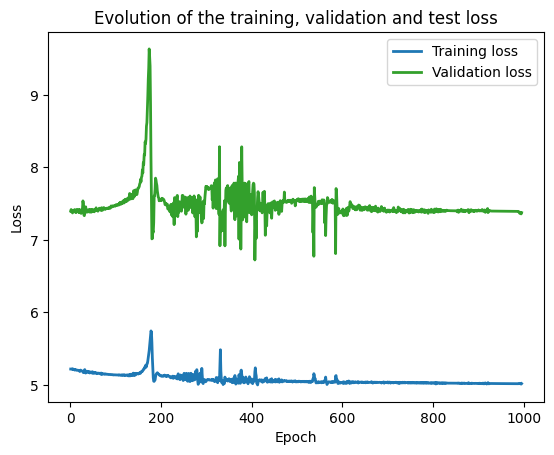

In [61]:
plot_loss(BM_reg_noexc.train_loss_history[5:], BM_reg_noexc.val_loss_history[5:])

In [62]:
# compute validation loss (burn-out first 20 epochs)
val_loss = np.mean(BM_reg_noexc.val_loss_history[-20:])

In [63]:
# Check the best models
# using calibration set to choose the best model
bm_loss_noexc, bm_model_noexc, loss_history_noexc = BM_reg_noexc.select_model()

In [66]:
# Split conformal prediction 
alpha = 0.1

# store coverage indicator for every test sample
coverage_BM_noexc = []
# store size of the prediction interval 
size_BM_noexc = []
# store test loss
test_losses_BM_noexc = []
# store prediction intervals for every test sample
pi_BM_noexc = []

# initialize
C_PI = Conformal_PI(mod, device, calib_loader, alpha, y_hat_min=y_hat_min, y_hat_max=y_hat_max)

for input, response in tqdm(test_loader):
    # find prediction interval
    benchmarkPI = C_PI.benchmark_ICP(input, bm_model_noexc)
    pi_BM_noexc.append(benchmarkPI)
    # find size and coverage indicator
    size_BM_noexc.append(benchmarkPI[0]._measure)
    coverage_BM_noexc.append(response in benchmarkPI[0])
    # evaluate the out of sample losses
    ## load the best model
    BM_reg_noexc_temp = CES_regression(mod, device, train_loader, batch_size=batch_size, max_epoch = num_epochs, learning_rate=lr, val_loader=calib_loader, verbose = False, criterion= MSE_loss, optimizer=optimizer)  
    BM_reg_noexc_temp.net.load_state_dict(torch.load(bm_model_noexc, map_location=device))
    ## compute loss on test samples
    test_loss = BM_reg_noexc_temp.get_loss(input, response)
    test_losses_BM_noexc.append(test_loss)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 49.55it/s]


In [67]:
wsc_coverages_BM_noexc = []

for i in tqdm(np.arange(10)):
    wsc_coverage = wsc_unbiased(X_test, y_test, pi_BM_noexc, M=100, delta = 0.1)
    wsc_coverages_BM_noexc.append(wsc_coverage)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:18<00:00,  1.81s/it]


In [68]:
print("The marginal coverage rate is (BM no exc) {}".format(sum(coverage_BM_noexc)/len(coverage_BM_noexc)))
print("The conditional coverage rate is (BM no exc) {}".format(np.nanmean(wsc_coverages_BM_noexc)))
print("The average size is (BM no exc) {}".format(sum(size_BM_noexc)/len(size_BM_noexc)))
print("The test loss is (BM no exc) {}".format(sum(test_losses_BM_noexc)/len(test_losses_BM_noexc)))
print("The validation loss is (BM no exc) {}".format(val_loss)) 

The marginal coverage rate is (BM no exc) 0.96
The conditional coverage rate is (BM no exc) 0.9478243077360956
The average size is (BM no exc) 9.55419156551361
The test loss is (BM no exc) 4.9871745109558105
The validation loss is (BM no exc) 7.386207396690645
